# Segmentation Subsetting Notebook

## Introduction
This notebook contains the Feature Selection and NaN handling for the Demographic data.  
It will be the base for the preprocessing steps taken.  

In this stage, one of the most important parts is feature selection for clustering, since there are many possible variables.  
Selecting the most important features will help us avoid the "curse of dimensionality" for clustering and also help gain computation time.

## Steps contained
1. Missing values handling
2. Duplicates check/ handling
3. Feature Selection 
    - Too unpopulated columns
    - Multicolinearities (Using Cramer's V)
    - Manual exclusion of variables not relevant based on their definition and description
4. Exploring Corrletions
    - Correlations might happen on variables outside their groups
5. Exploring Distributions
    - It might be more interesting to some variables to encode them differently
    - There are some columns within groups that seem to share information

**Note: To select manually the variables that will be kept, the informations in the DIAS Information Levels - Attributes Spreadsheet will be used** 

## Context/ Business Goal
The targeted company for this project is an **Organics** company that is selling **mail-ordered** products.

# Imports

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Utils
import itertools
import csv
import os

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# ML and Statistics
import scipy.stats as stats

In [2]:
sns.set(rc={'figure.figsize':(10,5)})

# Reading Data

In [3]:
census = pd.read_csv('data/raw/Udacity_AZDIAS_052018.csv', sep = ';')

C:\Users\Lucca\AppData\Local\Temp\ipykernel_12204\1330055611.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  census = pd.read_csv('data/raw/Udacity_AZDIAS_052018.csv', sep = ';')


# Type handling on warned columns by Pandas

In [4]:
col_check = census.iloc[:, [18,19]].applymap(type)

In [5]:
census.iloc[:, [18,19]].head(10)

CAMEO_DEUG_2015 CAMEO_INTL_2015
0             NaN             NaN
1             8.0            51.0
2             4.0            24.0
3             2.0            12.0
4             6.0            43.0
5             8.0            54.0
6             4.0            22.0
7             2.0            14.0
8             1.0            13.0
9             1.0            15.0

Probably, what is happening for these columns is that not encoded NaN Values are making pandas read the file as `float`.  
This will be temporarily fixed, so the columns can be preprocessed along with the others.  

In [6]:
col_check[col_check['CAMEO_DEUG_2015'] != float]

CAMEO_DEUG_2015 CAMEO_INTL_2015
2048     <class 'str'>   <class 'str'>
2050     <class 'str'>   <class 'str'>
2052     <class 'str'>   <class 'str'>
2053     <class 'str'>   <class 'str'>
2054     <class 'str'>   <class 'str'>
...                ...             ...
886779   <class 'str'>   <class 'str'>
886780   <class 'str'>   <class 'str'>
886781   <class 'str'>   <class 'str'>
886782   <class 'str'>   <class 'str'>
886783   <class 'str'>   <class 'str'>

[459358 rows x 2 columns]

In [7]:
census.loc[[2048,2050,2052], ['CAMEO_DEUG_2015']]

CAMEO_DEUG_2015
2048               4
2050               3
2052               7

In [8]:
# Including detailed classification, since it belongs along the two indicated columns
census[census['CAMEO_DEUG_2015'] == 'X'][['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']].drop_duplicates()

CAMEO_DEUG_2015 CAMEO_INTL_2015 CAMEO_DEU_2015
2511               X              XX             XX

'X's will be treated as `NaN`

In [9]:
census['CAMEO_DEUG_2015'] = census['CAMEO_DEUG_2015'].replace('X',np.nan)

census['CAMEO_INTL_2015'] = census['CAMEO_INTL_2015'].replace('XX',np.nan)

census['CAMEO_DEU_2015'] = census['CAMEO_DEU_2015'].replace('XX',np.nan)

In [10]:
census['CAMEO_DEUG_2015'] = census['CAMEO_DEUG_2015'].fillna(-1).astype(int)

census['CAMEO_INTL_2015'] = census['CAMEO_INTL_2015'].fillna(-1).astype(int)

census['CAMEO_DEU_2015'] = census['CAMEO_DEU_2015'].fillna('-1')

In [11]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int32(2), int64(93), object(4)
memory usage: 2.4+ GB


# Missing Values Handling

Handling NaNs especially to avoid 

## Creating replacements for NaN Values in each column

We will replace NaN only for those cols that explicitly state a value for "Unknown". "No transactions known" will be considered as 0, given that the classification follow a research methodology and probably would have found transactions, when relevant.

In [12]:
df_attributes = pd.read_excel('data/raw/DIAS Attributes - Values 2017.xlsx', header = 1, usecols = 'B:F', dtype = str)

df_attributes[['Attribute','Description']] = df_attributes[['Attribute','Description']].fillna(method='ffill')

# Assuming, from manual inspection from the 'Values' Spreadsheet, that NaNs are represented with substrings in Meaning col
nan_val_df = df_attributes[df_attributes['Meaning'].str.contains('unknown',regex=True,na  = False)].copy()

nan_val_df['Value'] = nan_val_df['Value'].str.replace('\s','', regex = True)

nan_val_df['Value'] = nan_val_df['Value'].str.split(',')

nan_val_map = dict(zip(nan_val_df['Attribute'], nan_val_df['Value']))

In [13]:
diff_cols = np.setdiff1d(nan_val_df['Attribute'], census.columns)

In [14]:
print('Columns with "unknown" not found in data: \n',diff_cols)

Columns with "unknown" not found in data: 
 ['BIP_FLAG' 'CAMEO_DEUINTL_2015' 'D19_KK_KUNDENTYP' 'GEOSCORE_KLS7'
 'HAUSHALTSSTRUKTUR' 'KBA13_CCM_1400_2500' 'SOHO_FLAG'
 'WACHSTUMSGEBIET_NB']


In [15]:
nested_nan_map = {}

for k, v in nan_val_map.items():

    nested_nan_map[k] = {int(val):np.nan for val in v}

In [16]:
nan_val_df[nan_val_df['Attribute'].isin(diff_cols)]

Attribute      Type  \
48               BIP_FLAG    binary   
105    CAMEO_DEUINTL_2015  interval   
391      D19_KK_KUNDENTYP   nominal   
724         GEOSCORE_KLS7  interval   
734     HAUSHALTSSTRUKTUR   nominal   
1266  KBA13_CCM_1400_2500  interval   
2207            SOHO_FLAG    binary   
2238   WACHSTUMSGEBIET_NB  interval   

                                            Description    Value  Meaning  
48    business-flag indicating companies in the buil...     [-1]  unknown  
105   CAMEO classification 2015 - international typo...     [-1]  unknown  
391          consumption movement in the last 12 months     [-1]  unknown  
724   microgeographical risk index concerning popula...  [-1, 0]  unknown  
734   structure of the household (single-hh, couple ...  [-1, 0]  unknown  
1266  share of cars with 1400ccm to 2499ccm within t...     [-1]  unknown  
2207                      small office/home office flag     [-1]  unknown  
2238  growing area (population growth in the last 5 ...  [-1, 0]  unknown

In [17]:
# Manually setting columns that have other name in Data
nested_nan_map['SOHO_KZ'] = {-1:np.nan}

nested_nan_map['KK_KUNDENTYP'] = {-1:np.nan}

nested_nan_map['KBA13_CCM_1401_2500'] = {-1:np.nan}

In [18]:
census = census.replace(nested_nan_map)

census['CAMEO_DEU_2015'] = census['CAMEO_DEU_2015'].replace('-1',np.nan)

# Checking for duplicates on census Data

In [19]:
# Full duplicates
census.duplicated().sum()

0

In [20]:
# Checking if an ID shows up more than once
census.LNR.duplicated().sum()

0

It seems as there are no duplicates

## NaN Values on columns

In [21]:
nan_proportion = census.isna()\
                        .mean()\
                        .sort_values(ascending = False)

In [22]:
nan_proportion.head()

ALTER_KIND4    0.998648
TITEL_KZ       0.997576
ALTER_KIND3    0.993077
ALTER_KIND2    0.966900
ALTER_KIND1    0.909048
dtype: float64

In [23]:
for t in np.arange(0.1, 1, 0.1):

    print(f'Amount of columns with more than {t:.0%} of NaNs')

    print((nan_proportion >= t).sum(), end = '\n\n')

Amount of columns with more than 10% of NaNs
244

Amount of columns with more than 20% of NaNs
20

Amount of columns with more than 30% of NaNs
10

Amount of columns with more than 40% of NaNs
9

Amount of columns with more than 50% of NaNs
9

Amount of columns with more than 60% of NaNs
8

Amount of columns with more than 70% of NaNs
7

Amount of columns with more than 80% of NaNs
5

Amount of columns with more than 90% of NaNs
5



In [24]:
nan_proportion[nan_proportion >= 0.3]

ALTER_KIND4     0.998648
TITEL_KZ        0.997576
ALTER_KIND3     0.993077
ALTER_KIND2     0.966900
ALTER_KIND1     0.909048
AGER_TYP        0.760196
EXTSEL992       0.733996
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
ALTER_HH        0.348137
dtype: float64

Using 30% as threshold for eliminating because having too many empty values on a column might skew its distribution after imputation

In [25]:
census.drop(columns = nan_proportion[nan_proportion >= 0.3].index, inplace=True)

# Checking for multicolinearity

We should check especially for multicolinearity for categorical variables (ordinals are categorical nontheless), since there are so many of them.  
In this context, too many variables can lead to the Curse of Dimensionality so that it is hard to set entries apart in the feature space.  

To compare approx. 300 variables with themselves would generate a result too expensive computationally (approx. 44850 unique combinations), since we have to evaluate all variables against themselves.  
As a proxy, we will use the information-levels to calculate the colinearities within each level to keep only the most important features for each level. 

## Fetching level-information data by column

In [26]:
att_info = pd.read_excel('data/raw/DIAS Information Levels - Attributes 2017.xlsx', usecols = 'B:E', header = 1)

In [27]:
att_info['Information level'] = att_info['Information level'].fillna(method='ffill')\
                                                            .fillna(method='backfill')

In [28]:
att_info['Information level'].unique()

array(['Person', 'Household', 'Building', 'Microcell (RR4_ID)',
       'Microcell (RR3_ID)', '125m x 125m Grid', 'Postcode ', 'RR1_ID',
       'PLZ8', 'Community'], dtype=object)

In [29]:
att_info['Information level'] = att_info['Information level'].str.strip()

In [30]:
att_info['Information level'].nunique()

10

In [31]:
att_info = att_info[['Information level','Attribute']]

display(att_info)

Information level             Attribute
0              Person              AGER_TYP
1              Person  ALTERSKATEGORIE_GROB
2              Person             ANREDE_KZ
3              Person         CJT_GESAMTTYP
4              Person     FINANZ_MINIMALIST
..                ...                   ...
308         Community                ARBEIT
309         Community             EINWOHNER
310         Community                   GKZ
311         Community           ORTSGR_KLS9
312         Community              RELAT_AB

[313 rows x 2 columns]

In [32]:
att_info[att_info['Attribute'].str.endswith('RZ')]

Information level                  Attribute
152  125m x 125m Grid       D19_BANKEN_DIREKT_RZ
153  125m x 125m Grid        D19_BANKEN_GROSS_RZ
154  125m x 125m Grid        D19_BANKEN_LOKAL_RZ
155  125m x 125m Grid         D19_BANKEN_REST_RZ
156  125m x 125m Grid      D19_BEKLEIDUNG_GEH_RZ
157  125m x 125m Grid     D19_BEKLEIDUNG_REST_RZ
158  125m x 125m Grid            D19_BIO_OEKO_RZ
159  125m x 125m Grid             D19_BILDUNG_RZ
160  125m x 125m Grid                D19_BUCH_RZ
161  125m x 125m Grid          D19_DIGIT_SERV_RZ
162  125m x 125m Grid     D19_DROGERIEARTIKEL_RZ
163  125m x 125m Grid             D19_ENERGIE_RZ
164  125m x 125m Grid            D19_FREIZEIT_RZ
165  125m x 125m Grid              D19_GARTEN_RZ
166  125m x 125m Grid            D19_HANDWERK_RZ
167  125m x 125m Grid           D19_HAUS_DEKO_RZ
168  125m x 125m Grid       D19_KINDERARTIKEL_RZ
169  125m x 125m Grid            D19_KOSMETIK_RZ
170  125m x 125m Grid        D19_LEBENSMITTEL_RZ
171  125m x 125m Grid  D19_NAHRUNGSERGAENZUNG_RZ
172  125m x 125m Grid            D19_RATGEBER_RZ
173  125m x 125m Grid              D19_REISEN_RZ
174  125m x 125m Grid       D19_SAMMELARTIKEL_RZ
175  125m x 125m Grid              D19_SCHUHE_RZ
176  125m x 125m Grid            D19_SONSTIGE_RZ
177  125m x 125m Grid             D19_TECHNIK_RZ
178  125m x 125m Grid        D19_TELKO_MOBILE_RZ
179  125m x 125m Grid          D19_TELKO_REST_RZ
180  125m x 125m Grid         D19_TIERARTIKEL_RZ
181  125m x 125m Grid      D19_VERSICHERUNGEN_RZ
182  125m x 125m Grid       D19_VOLLSORTIMENT_RZ
183  125m x 125m Grid        D19_VERSAND_REST_RZ
184  125m x 125m Grid       D19_WEIN_FEINKOST_RZ

In [33]:
att_info['Information level'].unique()

array(['Person', 'Household', 'Building', 'Microcell (RR4_ID)',
       'Microcell (RR3_ID)', '125m x 125m Grid', 'Postcode', 'RR1_ID',
       'PLZ8', 'Community'], dtype=object)

In [34]:
# Fixing the names for 125 grid because in the data they dont have _RZ in their name
att_info['Attribute'] = att_info['Attribute'].str.replace('_RZ','')

In [35]:
diff_cols = list(np.setdiff1d(census.columns.values, att_info['Attribute'].values))

print(diff_cols)

['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BUCH_CD', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG',

Not all variables are described in the Information Levels.

In [36]:
# Removing ID
diff_cols.remove('LNR')

Even though these columns are not assigned to any information group, the majority has a prefix that helps manually assigning them to a group.  
Also, the `CJT_TYP_X` columns are actually dummyfied versions of a column in the dataset

In [37]:
[col for col in diff_cols if col.startswith('D19')]

['D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BUCH_CD',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_ONLINE_QUOTE_12']

In [38]:
grid_cols = ['D19_BUCH_CD',
            'D19_LETZTER_KAUF_BRANCHE',
            'D19_LOTTO',
            'D19_SOZIALES']

In [39]:
household_cols = ['D19_TELKO_ONLINE_QUOTE_12',
                    'D19_VERSAND_ANZ_12',
                    'D19_VERSAND_ANZ_24',
                    'D19_VERSI_ONLINE_QUOTE_12',
                    'D19_GESAMT_ANZ_12',
                    'D19_GESAMT_ANZ_24',
                    'D19_KONSUMTYP_MAX',
                    'D19_BANKEN_ANZ_12',
                    'D19_BANKEN_ANZ_24',
                    'D19_TELKO_ANZ_12',
                    'D19_TELKO_ANZ_24',
                    'D19_VERSI_ANZ_12',
                    'D19_VERSI_ANZ_24']

### Fixing columns that respect the name structure and/or are in the documentation

In [40]:
new_rows = []

for col in diff_cols:

    if col in household_cols:

        new_val = ('Household', col)

        new_rows.append(new_val)

    if col in grid_cols:

        new_val = ('125m x 125m Grid', col)

        new_rows.append(new_val)

    if col.startswith('KBA13'):

        new_val = ('PLZ8',col)

        new_rows.append(new_val)

    if col.startswith('CJT'):

        new_val = ('Person',col)

        new_rows.append(new_val)

for _, name in new_rows:

    diff_cols.remove(name)

In [41]:
diff_cols

['AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KOMBIALTER',
 'KONSUMZELLE',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'SOHO_KZ',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11']

Some columns still are to be accounted for. This will be done by manually inspecting each case to check if the columns exist in the dictionary or have problems in their name.

In [42]:
# Exporting column names for classification

with open('data/raw/unaccounted_cols.csv','w', newline='') as file:

    writer = csv.writer(file, delimiter=';')

    writer.writerow(['col_name'])

    for col in diff_cols:

        writer.writerow([col])

### Building final classification

In [43]:
diff_cols_remainder = pd.read_csv('data/trusted/unaccounted_cols.csv', sep = ';')

In [44]:
print('Columns unaccounted for:',diff_cols_remainder.shape[0])

Columns unaccounted for: 28


In [45]:
diff_cols_remainder['information'].value_counts()

UNDOCUMENTED          21
Household              3
Person                 2
Microcell (RR4_ID)     1
RR1_ID                 1
Name: information, dtype: int64

From 30 columns that were still unaccounted for, 22 **WERE NOT FOUND IN THE DOCUMENTATION**.  
In a real-life scenario, these would be brought to the knowledge of the business or data-sourcing team responsible so that they could be documented.  
In the context of this project, **these columns will be dropped** since we cannot safely interpret for our segmentation, if they come to be useful.

In [46]:
columns_to_drop = diff_cols_remainder[diff_cols_remainder['information'] == 'UNDOCUMENTED']['col_name'].values

In [47]:
census.drop(columns = columns_to_drop, inplace = True)

In [48]:
cols_to_keep_list = list(zip(diff_cols_remainder[diff_cols_remainder['information'] != 'UNDOCUMENTED']['information'],
                         diff_cols_remainder[diff_cols_remainder['information'] != 'UNDOCUMENTED']['col_name']))

In [49]:
new_rows.extend(cols_to_keep_list)

In [50]:
new_rows_frame = pd.DataFrame(new_rows, columns= ['Information level', 'Attribute'])

In [51]:
new_rows_frame

Information level                   Attribute
0               Person           CJT_KATALOGNUTZER
1               Person                   CJT_TYP_1
2               Person                   CJT_TYP_2
3               Person                   CJT_TYP_3
4               Person                   CJT_TYP_4
5               Person                   CJT_TYP_5
6               Person                   CJT_TYP_6
7            Household           D19_BANKEN_ANZ_12
8            Household           D19_BANKEN_ANZ_24
9     125m x 125m Grid                 D19_BUCH_CD
10           Household           D19_GESAMT_ANZ_12
11           Household           D19_GESAMT_ANZ_24
12           Household           D19_KONSUMTYP_MAX
13    125m x 125m Grid    D19_LETZTER_KAUF_BRANCHE
14    125m x 125m Grid                   D19_LOTTO
15    125m x 125m Grid                D19_SOZIALES
16           Household            D19_TELKO_ANZ_12
17           Household            D19_TELKO_ANZ_24
18           Household   D19_TELKO_ONLINE_QUOTE_12
19           Household          D19_VERSAND_ANZ_12
20           Household          D19_VERSAND_ANZ_24
21           Household            D19_VERSI_ANZ_12
22           Household            D19_VERSI_ANZ_24
23           Household   D19_VERSI_ONLINE_QUOTE_12
24                PLZ8                 KBA13_ANTG1
25                PLZ8                 KBA13_ANTG2
26                PLZ8                 KBA13_ANTG3
27                PLZ8                 KBA13_ANTG4
28                PLZ8                KBA13_BAUMAX
29                PLZ8         KBA13_CCM_1401_2500
30                PLZ8              KBA13_CCM_3000
31                PLZ8              KBA13_CCM_3001
32                PLZ8                   KBA13_GBZ
33                PLZ8                   KBA13_HHZ
34                PLZ8               KBA13_KMH_210
35              Person        ALTERSKATEGORIE_FEIN
36           Household                  ANZ_KINDER
37           Household  ANZ_STATISTISCHE_HAUSHALTE
38  Microcell (RR4_ID)             CAMEO_INTL_2015
39              RR1_ID                 MOBI_RASTER
40              Person                     SOHO_KZ
41           Household                 STRUKTURTYP

In [52]:
att_info.shape

(313, 2)

In [53]:
att_info_updated = pd.concat([att_info,new_rows_frame], axis = 0)

In [54]:
# Are the columns in the census table contained in the informations table?
np.setdiff1d(census.columns, att_info_updated['Attribute'])

array(['LNR'], dtype=object)

This is ok since this is the ID column

In [55]:
class_census_cols = np.intersect1d(census.columns, att_info_updated['Attribute'])

In [56]:
len(class_census_cols)

334

In [57]:
col_classification = att_info_updated[att_info_updated['Attribute'].isin(class_census_cols)]

In [58]:
col_classification['Information level'].value_counts()

PLZ8                  123
Microcell (RR3_ID)     53
Person                 49
Household              40
125m x 125m Grid       36
Microcell (RR4_ID)     12
Building                9
RR1_ID                  6
Postcode                3
Community               3
Name: Information level, dtype: int64

## Calculating Multicolinearities by Information Group

In [59]:
# We wont use numeric vars to calculate Cramer's V

numeric_vars = ['ANZ_HAUSHALTE_AKTIV',
                'ANZ_HH_TITEL',
                'ANZ_PERSONEN',
                'ANZ_TITEL',
                'GEBURTSJAHR',
                'KBA13_ANZAHL_PKW',
                'MIN_GEBAEUDEJAHR']

In [60]:
num_var_filter = ~col_classification['Attribute'].isin(numeric_vars)

In [61]:
def calculate_cramers_v(arr1, arr2):

    '''
    Calculates Cramer's V for two arrays.
    The value lies between 0 and 1 (inclusive)

    :param arr1: Array of categorical variable
    :param arr2: Array of categorical variable

    :return v: Cramer's V index value
    '''

    crosstab = stats.contingency.crosstab(arr1, arr2)[1]

    chi2 = stats.chi2_contingency(crosstab)[0]

    # calculating the total number of observations
    n = np.sum(crosstab)

    # getting the degrees of freedom
    dof = min(crosstab.shape)-1
    
    # calculating cramer's v
    v = np.sqrt(chi2/(n*dof))

    return v

def calculate_frame_cramer_coefs(dataframe):

    '''
    Calculates pairwise Cramer's V for all possible combinations of categorical variables in 'dataframe'.
    Similar behaviour to pandas' .corr() method.

    :param dataframe: Pandas DataFrame columns with categorical variables

    :return matrix: Pairwise matrix with all variable combinations
    '''
    
    numpy_frame = dataframe.dropna().values

    matrix = np.diag([1.0] * numpy_frame.shape[1])

    table_range = list(range(0,numpy_frame.shape[1]))

    # Getting unique index combinations to minimize iterations
    combos = [combo for combo in itertools.combinations(table_range,2)]

    for i, j in combos:
        
        v = calculate_cramers_v(numpy_frame[:,i], numpy_frame[:,j])

        matrix[i,j] = v

        matrix[j,i] = v

    return matrix

**WARNING: Running the cells below can take a while. That is why the values are exported to csv, so we can use them later without going through these calculations**

In [62]:
# # Sorting information levels by amount of columns to generate results faster
# sorted_col_classes = col_classification['Information level'].value_counts(ascending=True)

In [63]:
# for i, c in enumerate(sorted_col_classes.index): : #  enumerate(['125m x 125m Grid','Household'])

#     relevant_cols = col_classification[(col_classification['Information level'] == c) & num_var_filter]['Attribute']

#     v_matrix = calculate_frame_cramer_coefs(census[relevant_cols])

#     v_frame = pd.DataFrame(v_matrix, columns = relevant_cols, index = relevant_cols)

#     v_frame.name = c

#     v_frame.to_csv(f'data/trusted/{v_frame.name}_cramer.csv', sep = ';')

#     if i == 0:

#         v_frame_list = [v_frame]

#     else:

#         v_frame_list.append(v_frame)

---

In [64]:
DATA_PATH = 'data/trusted/'

In [65]:
cramer_frame_list = []

for file in os.listdir(DATA_PATH):

    # Skipping to use updated version
    if file == 'Microcell (RR3_ID)_cramer.csv':

        continue

    if file.endswith('_cramer.csv'):

        name = file.replace('_cramer.csv','')

        frame = pd.read_csv(os.path.join(DATA_PATH, file), sep = ';', index_col = 0)

        if file == 'Microcell (RR3_ID)_updated_cramer.csv':

            frame = pd.read_csv(os.path.join(DATA_PATH, file), index_col = 0)

        frame.name = name
    
        cramer_frame_list.append(frame)

# Feature Selection
Based on multicolinearity and business definitions of columns within each group

## 125m x 125m Grid
For this information level, what does not relate to banking activities or marginally related to the clients' business (mail-order organics) will be drop and not analyzed.

In [66]:
# Keeping columns related to banking activities and related to clients' businesses
grid_cols_list = ['D19_BANKEN_DIREKT',
                            'D19_BANKEN_GROSS',
                            'D19_BANKEN_LOKAL',
                            'D19_BANKEN_REST',
                            'D19_BIO_OEKO',
                            'D19_DIGIT_SERV',
                            'D19_LEBENSMITTEL',
                            'D19_VOLLSORTIMENT',
                            'D19_VERSAND_REST']

In [67]:
cramer_frame_list[0].columns

Index(['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BIO_OEKO', 'D19_BILDUNG', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
       'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
       'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE',
       'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_VERSAND_REST',
       'D19_WEIN_FEINKOST', 'D19_BUCH_CD', 'D19_LETZTER_KAUF_BRANCHE',
       'D19_LOTTO', 'D19_SOZIALES'],
      dtype='object')

In [68]:
cramer_frame_list[0].loc[grid_cols_list, grid_cols_list].style.background_gradient()

Even though direct banking has some correlation to big banks, they convey different informations that might be interesting to the user.  
For instance, who uses direct banking might be a more tech-savy user. This gives us a different segment indication then simply assuming a user uses big banks.

## Buildings

In [69]:
cramer_frame_list[1].name

'Building'

In [70]:
cramer_frame_list[1].style.background_gradient()

KBA05_HERSTTEMP and KBA05_MODTEMP seem to have shared information. They are more closely related to auto-manufacturing then actually characteristics of repondents themselves. They may belong better to the RR3_ID class.  

Either way, it makes sanse that car brands and segments are correlated to eachother as well as living conditions in a neighbourhood (WOHNANLAGE).  

No other columns from the group will be dropped

In [71]:
buildings_col_list = list(cramer_frame_list[1].columns.drop(['KBA05_HERSTTEMP','KBA05_MODTEMP']))

## RR3_ID

In [72]:
rr3_list = list(col_classification[(col_classification['Information level'] ==  'Microcell (RR3_ID)') & num_var_filter]['Attribute'].values) \
                + ['KBA05_HERSTTEMP','KBA05_MODTEMP']

In [73]:
# v_matrix = calculate_frame_cramer_coefs(census[rr3_list])

# v_frame = pd.DataFrame(v_matrix, columns = rr3_list, index = rr3_list)

In [74]:
# v_frame.to_csv('data/trusted/Microcell (RR3_ID)_cramer_updated.csv')

In [75]:
v_frame = cramer_frame_list[4]

In [76]:
# Checking variables that can have important multicolinearities 
((v_frame >= 0.3) & (v_frame < 1)).sum().sort_values(ascending = False).head(10)

KBA05_MAXHERST    9
KBA05_MOTOR       9
KBA05_MAXSEG      7
KBA05_KW3         7
KBA05_CCM1        6
KBA05_MAXBJ       6
KBA05_KRSKLEIN    6
KBA05_MOD1        6
KBA05_SEG2        5
KBA05_MAXVORB     5
dtype: int64

In [77]:
# Looking into some examples
v_frame[(v_frame >= 0.3) & (v_frame < 1)][['KBA05_MAXHERST','KBA05_MOTOR','KBA05_MAXSEG']]

KBA05_MAXHERST  KBA05_MOTOR  KBA05_MAXSEG
KBA05_AUTOQUOT              NaN          NaN           NaN
KBA05_BAUMAX                NaN          NaN           NaN
KBA05_CCM1                  NaN     0.463402      0.301857
KBA05_CCM2                  NaN     0.433955           NaN
KBA05_CCM3                  NaN     0.401816           NaN
KBA05_CCM4                  NaN     0.396834           NaN
KBA05_DIESEL                NaN          NaN           NaN
KBA05_FRAU                  NaN          NaN           NaN
KBA05_GBZ                   NaN          NaN           NaN
KBA05_HERST1           0.403921          NaN           NaN
KBA05_HERST2           0.383307          NaN           NaN
KBA05_HERST3           0.389107          NaN           NaN
KBA05_HERST4           0.387647          NaN           NaN
KBA05_HERST5           0.380793          NaN           NaN
KBA05_KRSAQUOT              NaN          NaN           NaN
KBA05_KRSHERST1        0.346650          NaN           NaN
KBA05_KRSHERST2        0.341114          NaN           NaN
KBA05_KRSHERST3        0.357052          NaN           NaN
KBA05_KRSKLEIN              NaN     0.309265      0.475631
KBA05_KRSOBER               NaN          NaN           NaN
KBA05_KRSVAN                NaN          NaN           NaN
KBA05_KRSZUL                NaN          NaN           NaN
KBA05_KW1                   NaN     0.409637           NaN
KBA05_KW2                   NaN     0.322191           NaN
KBA05_KW3                   NaN     0.461112           NaN
KBA05_MAXAH                 NaN          NaN           NaN
KBA05_MAXBJ                 NaN          NaN           NaN
KBA05_MAXHERST              NaN          NaN           NaN
KBA05_MAXSEG                NaN     0.315032           NaN
KBA05_MAXVORB               NaN          NaN           NaN
KBA05_MOD1                  NaN          NaN           NaN
KBA05_MOD2                  NaN          NaN           NaN
KBA05_MOD3                  NaN          NaN           NaN
KBA05_MOD4                  NaN          NaN           NaN
KBA05_MOD8                  NaN          NaN           NaN
KBA05_MOTOR                 NaN          NaN      0.315032
KBA05_MOTRAD                NaN          NaN           NaN
KBA05_SEG1                  NaN          NaN           NaN
KBA05_SEG2                  NaN          NaN      0.420395
KBA05_SEG3                  NaN          NaN      0.417465
KBA05_SEG4                  NaN          NaN      0.421667
KBA05_SEG5                  NaN          NaN           NaN
KBA05_SEG6                  NaN          NaN           NaN
KBA05_SEG7                  NaN          NaN           NaN
KBA05_SEG8                  NaN          NaN           NaN
KBA05_SEG9                  NaN          NaN           NaN
KBA05_SEG10                 NaN          NaN           NaN
KBA05_VORB0                 NaN          NaN           NaN
KBA05_VORB1                 NaN          NaN           NaN
KBA05_VORB2                 NaN          NaN           NaN
KBA05_ZUL1                  NaN          NaN           NaN
KBA05_ZUL2                  NaN          NaN           NaN
KBA05_ZUL3                  NaN          NaN           NaN
KBA05_ZUL4                  NaN          NaN           NaN
KBA05_HERSTTEMP        0.486576          NaN           NaN
KBA05_MODTEMP               NaN          NaN      0.536424

From these examples we can see that the correlations occur frequently in variables that are aggregated into other variables. This is somewhat expected and can be verified by the variables' description on their documentation.  
To reduce the number of variables, those that aggregate information will be kept. If there are correlations within this subset of variables, another selection will be made.

In [78]:
kept = ['KBA05_AUTOQUOT',
        'KBA05_DIESEL',
        'KBA05_FRAU',
        'KBA05_GBZ',
        'KBA05_KRSAQUOT',
        'KBA05_KRSKLEIN',
        'KBA05_KRSOBER',
        'KBA05_KRSVAN',
        'KBA05_KRSZUL',
        'KBA05_MAXAH',
        'KBA05_MAXBJ',
        'KBA05_MAXHERST',
        'KBA05_MAXSEG',
        'KBA05_MAXVORB',
        'KBA05_MOTOR',
        'KBA05_MOTRAD',
        'KBA05_HERSTTEMP',
        'KBA05_MODTEMP']

In [79]:
v_frame.loc[kept, kept].style.background_gradient()

In [80]:
to_drop = ['KBA05_GBZ','KBA05_AUTOQUOT','KBA05_MAXSEG','KBA05_HERSTTEMP']

Dropped:

- 'KBA05_GBZ': The number of buildings is correlated to the main type of building. The type of building is more interesting to understand clusters
- 'KBA05_AUTOQUOT': Correlated with KRSAUTOQUOT, that conveys the same information
- 'KBA05_MAXSEG': Correlate with too many other features
- 'KBA05_HERSTTEMP': Conveys similar information to MAXHERST, also strongly correlated to other variables

In [81]:
rr3_col_list = list(set(kept) - set(to_drop))

## Community 

Community actually contains continuous variables, therefore these will be kept, with exception of `RELAT_AB`, since it will convey similar information as `ARBEIT` when looking the variables' description

In [82]:
community_col_list = list(cramer_frame_list[2].columns.drop(['RELAT_AB']))

## Household

In [83]:
cramer_frame_list[3].name

'Household'

Looking into the columns in this category, we see that there might be some themes that we would like to avoid as date markers, considering the business we want to segment our customers for. E.g. the actuality of the transactions for telecommunications businessess (`D19_TELKO_DATUM`) might not be of interest for an mail-order organics company.  
We keep, therefore, only columns that might be pertinent for our case. 

In [84]:
cramer_frame_list[3].columns

Index(['ALTER_HH', 'HH_EINKOMMEN_SCORE', 'D19_KONSUMTYP',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_VERSAND_ONLINE_QUOTE_12', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_GESAMT_ANZ_12',
       'D19_GESAMT_ANZ_24', 'D19_KONSUMTYP_MAX', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'D19_VERSI_ONLINE_QUOTE_12', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE',
       'STRUKT

In [85]:
household_cols_list = [#'ALTER_HH',
                        'HH_EINKOMMEN_SCORE',
                        'D19_KONSUMTYP',
                            'D19_GESAMT_OFFLINE_DATUM',
                            'D19_GESAMT_ONLINE_DATUM',
                            'D19_GESAMT_DATUM',
                            'D19_BANKEN_DATUM',
                            'D19_VERSAND_OFFLINE_DATUM',
                            'D19_VERSAND_ONLINE_DATUM',
                            'D19_VERSAND_DATUM',
                            'D19_GESAMT_ONLINE_QUOTE_12',
                            'D19_BANKEN_ONLINE_QUOTE_12',
                            'D19_VERSAND_ONLINE_QUOTE_12',
                            'W_KEIT_KIND_HH',
                            'WOHNDAUER_2008',
                            'D19_GESAMT_ANZ_12',
                            'D19_GESAMT_ANZ_24',
                            'D19_KONSUMTYP_MAX',
                            'D19_VERSAND_ANZ_12',
                            'D19_VERSAND_ANZ_24',
                            'ANZ_KINDER',
                            'ANZ_STATISTISCHE_HAUSHALTE',
                            'STRUKTURTYP']

In [86]:
cramer_frame_list[3].loc[household_cols_list, household_cols_list].style.background_gradient()

Online and offline data seem to be correlated. As well as 12 and 24 months data. The aggregate columns (identified by not having "online" or "offline" in the column names) will be kept for the first case, 12 months for the latter. 12 months is chosen because we want to segment the database into possible customers immediatly, therefore, more recent data is more interesting then longer time periods.

In [87]:
household_cols_list = [#'ALTER_HH',
                        'HH_EINKOMMEN_SCORE',
                        'D19_KONSUMTYP',
                        'D19_GESAMT_DATUM',
                        'D19_BANKEN_DATUM',
                        'D19_VERSAND_DATUM',
                        'D19_GESAMT_ONLINE_QUOTE_12',
                        'D19_BANKEN_ONLINE_QUOTE_12',
                        'D19_VERSAND_ONLINE_QUOTE_12',
                        'W_KEIT_KIND_HH',
                        'WOHNDAUER_2008',
                        'D19_GESAMT_ANZ_12',
                        'D19_KONSUMTYP_MAX',
                        'D19_VERSAND_ANZ_12',
                        'ANZ_KINDER',
                        'ANZ_STATISTISCHE_HAUSHALTE',
                        'STRUKTURTYP']

In [88]:
cramer_frame_list[3].loc[household_cols_list, household_cols_list].style.background_gradient()

There are some other strong correlations, but considering that the data has a considerable amount of `NaN` values in itself, these redundancies are interesting to keep at some level to get homogeneus clusters.  
The only other correlation that will be handled is the `D19_KONSUMTYP` and the `D19_KONSUMTYP_MAX` since they convey the same information. The "max" column will be dropped

In [89]:
household_cols_list.remove('D19_KONSUMTYP_MAX')

## RR4_ID

In [90]:
cramer_frame_list[5]

CAMEO_DEUG_2015  CAMEO_DEU_2015  KBA05_ALTER1  KBA05_ALTER2  \
Attribute                                                                      
CAMEO_DEUG_2015         1.000000        1.000000      0.156121      0.080368   
CAMEO_DEU_2015          1.000000        1.000000      0.177400      0.146382   
KBA05_ALTER1            0.156121        0.177400      1.000000      0.069837   
KBA05_ALTER2            0.080368        0.146382      0.069837      1.000000   
KBA05_ALTER3            0.096975        0.115171      0.138553      0.270582   
KBA05_ALTER4            0.112977        0.178524      0.207337      0.276089   
KBA05_ANHANG            0.245989        0.266768      0.159244      0.096400   
KBA05_ANTG1             0.307384        0.321341      0.173502      0.095485   
KBA05_ANTG2             0.195404        0.210685      0.119041      0.071673   
KBA05_ANTG3             0.207195        0.220738      0.140370      0.076166   
KBA05_ANTG4             0.275275        0.288699      0.155803      0.093293   
CAMEO_INTL_2015         0.812627        1.000000      0.167059      0.136130   

                 KBA05_ALTER3  KBA05_ALTER4  KBA05_ANHANG  KBA05_ANTG1  \
Attribute                                                                
CAMEO_DEUG_2015      0.096975      0.112977      0.245989     0.307384   
CAMEO_DEU_2015       0.115171      0.178524      0.266768     0.321341   
KBA05_ALTER1         0.138553      0.207337      0.159244     0.173502   
KBA05_ALTER2         0.270582      0.276089      0.096400     0.095485   
KBA05_ALTER3         1.000000      0.156176      0.116907     0.118914   
KBA05_ALTER4         0.156176      1.000000      0.140397     0.134159   
KBA05_ANHANG         0.116907      0.140397      1.000000     0.318594   
KBA05_ANTG1          0.118914      0.134159      0.318594     1.000000   
KBA05_ANTG2          0.085626      0.097115      0.244595     0.367649   
KBA05_ANTG3          0.094501      0.098978      0.223573     0.412086   
KBA05_ANTG4          0.105175      0.158742      0.244924     0.398888   
CAMEO_INTL_2015      0.102966      0.164476      0.255598     0.315520   

                 KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  CAMEO_INTL_2015  
Attribute                                                                
CAMEO_DEUG_2015     0.195404     0.207195     0.275275         0.812627  
CAMEO_DEU_2015      0.210685     0.220738     0.288699         1.000000  
KBA05_ALTER1        0.119041     0.140370     0.155803         0.167059  
KBA05_ALTER2        0.071673     0.076166     0.093293         0.136130  
KBA05_ALTER3        0.085626     0.094501     0.105175         0.102966  
KBA05_ALTER4        0.097115     0.098978     0.158742         0.164476  
KBA05_ANHANG        0.244595     0.223573     0.244924         0.255598  
KBA05_ANTG1         0.367649     0.412086     0.398888         0.315520  
KBA05_ANTG2         1.000000     0.344843     0.363847         0.203466  
KBA05_ANTG3         0.344843     1.000000     0.290603         0.214638  
KBA05_ANTG4         0.363847     0.290603     1.000000         0.276912  
CAMEO_INTL_2015     0.203466     0.214638     0.276912         1.000000

The KBA columns are misclassified (Should be RR3). They will be kept since they can convey useful information regarding the economic power of a respondent.

In [91]:
cramer_frame_list[5].loc[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015'],
                            ['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']]

CAMEO_DEUG_2015  CAMEO_DEU_2015  CAMEO_INTL_2015
Attribute                                                        
CAMEO_DEUG_2015         1.000000             1.0         0.812627
CAMEO_DEU_2015          1.000000             1.0         1.000000
CAMEO_INTL_2015         0.812627             1.0         1.000000

From their definition, it is natural that these columns are highly correlated. We will drop only the internation classification, just to have uniform definition of german demographics if they are useful to interpret clusters later on.

In [92]:
rr4_col_list = list(cramer_frame_list[5].columns.drop('CAMEO_INTL_2015'))

## Person

The definition of columns in this category show how diverse each feature is. We will only look, therefore, to features that might correlate a lot to others and would not aggregate so much to our model

In [93]:
cramer_frame_list[6].name

'Person'

In [94]:
((cramer_frame_list[6] > 0.3) & (cramer_frame_list[6] < 1)).sum().sort_values(ascending = False)

SEMIO_KULT               20
SEMIO_ERL                20
SEMIO_REL                19
ANREDE_KZ                18
SEMIO_TRADV              18
SEMIO_KAEM               18
SEMIO_RAT                18
SEMIO_DOM                17
ALTERSKATEGORIE_GROB     17
SEMIO_KRIT               16
SEMIO_VERT               15
SEMIO_FAM                13
SEMIO_SOZ                12
CJT_TYP_1                12
SEMIO_MAT                12
AGER_TYP                 12
HEALTH_TYP               12
LP_LEBENSPHASE_FEIN      11
SEMIO_PFLICHT            10
SEMIO_LUST                9
SHOPPER_TYP               8
PRAEGENDE_JUGENDJAHRE     8
LP_LEBENSPHASE_GROB       8
CJT_TYP_5                 7
FINANZ_MINIMALIST         7
CJT_TYP_2                 7
CJT_TYP_3                 7
FINANZ_HAUSBAUER          7
VERS_TYP                  7
GREEN_AVANTGARDE          7
CJT_TYP_6                 7
CJT_TYP_4                 6
ALTERSKATEGORIE_FEIN      6
LP_STATUS_GROB            6
LP_STATUS_FEIN            5
ZABEOTYP            

In [95]:
(cramer_frame_list[6][['SEMIO_KULT',
                    'SEMIO_ERL', 
                    'SEMIO_REL']] > 0.3).style.highlight_max(color = 'green')

We can see from the examples that the correlations show up mainly regarding gender and age, as well as correlations to other drivers.  
This means that mainly that the drivers (`SEMIO_`) are associated to certain demographics and we can expect some patterns to emerge from the drivers themselves.  
This is important information for a clustering exercise.  

Considering the general relevance of the variables to segment the demographics, we will keep all variables in this level

In [96]:
person_col_list = list(cramer_frame_list[6].columns.drop('AGER_TYP'))

## PLZ8

From the definitions, we will drop initially columns related to very specific attributes of a car (Specific Manufacturer, for instance) and then check for possible correlation groups, like the `CCM, KMH and KW` columns, for example.  

This is because to segment customers demographically, it is more useful to know what kind of vehicle they drive and not necessairly the actual vehicle. We can then infer their spending patterns from this information. E.g. a more eco-friendly person might (i.e. a possible customer for organic produce) favor more low-power cars that don't emit so much CO2.

In [97]:
plz8_to_drop = ['KBA13_AUDI',
                'KBA13_BMW',
                'KBA13_FAB_ASIEN',
                'KBA13_FAB_SONSTIGE',
                'KBA13_FIAT',
                'KBA13_FORD',
                'KBA13_HERST_ASIEN',
                'KBA13_HERST_AUDI_VW',
                'KBA13_HERST_BMW_BENZ',
                'KBA13_HERST_EUROPA',
                'KBA13_HERST_FORD_OPEL',
                'KBA13_HERST_SONST',
                'KBA13_KRSHERST_AUDI_VW',
                'KBA13_KRSHERST_BMW_BENZ',
                'KBA13_KRSHERST_FORD_OPEL',
                'KBA13_MAZDA',
                'KBA13_MERCEDES',
                'KBA13_MOTOR',
                'KBA13_NISSAN',
                'KBA13_OPEL',
                'KBA13_PEUGEOT',
                'KBA13_RENAULT',
                'KBA13_TOYOTA',
                'KBA13_VW',
                'KBA13_SITZE_4',
                'KBA13_SITZE_5',
                'KBA13_SITZE_6']

In [98]:
plz8_kept = cramer_frame_list[7].columns.drop(plz8_to_drop)

In [99]:
len(plz8_kept)

95

### Horsepower correlations

In [100]:
hp_cols = ['KBA13_CCM_1000',
'KBA13_CCM_1200',
'KBA13_CCM_1400',
'KBA13_CCM_0_1400',
'KBA13_CCM_1500',
# 'KBA13_CCM_1400_2500', # Column NOT IN DATA
'KBA13_CCM_1600',
'KBA13_CCM_1800',
'KBA13_CCM_2000',
'KBA13_CCM_2500',
'KBA13_CCM_2501',
'KBA13_KMH_110',
'KBA13_KMH_140',
'KBA13_KMH_180',
'KBA13_KMH_0_140',
'KBA13_KMH_140_210',
'KBA13_KMH_211',
'KBA13_KMH_250',
'KBA13_KMH_251',
'KBA13_KW_30',
'KBA13_KW_40',
'KBA13_KW_50',
'KBA13_KW_60',
'KBA13_KW_0_60',
'KBA13_KW_70',
'KBA13_KW_61_120',
'KBA13_KW_80',
'KBA13_KW_90',
'KBA13_KW_110',
'KBA13_KW_120',
'KBA13_KW_121']

In [101]:
ccm_cols = ['KBA13_CCM_1000',
            'KBA13_CCM_1200',
            'KBA13_CCM_1400',
            'KBA13_CCM_0_1400',
            'KBA13_CCM_1500',
            # 'KBA13_CCM_1400_2500', # Column NOT IN DATA
            'KBA13_CCM_1600',
            'KBA13_CCM_1800',
            'KBA13_CCM_2000',
            'KBA13_CCM_2500',
            'KBA13_CCM_2501']

In [102]:
cramer_frame_list[7].loc[hp_cols, hp_cols].drop(ccm_cols).style.background_gradient()

Some correlations mainly between engine power in KW and horsepower emerge. Also it is good to notice columns that have range intersection, which results in higher correlations.  
Therefore, it might be nice to try out to keep only a single one of the criteria: CCM or KW generated. Evaluating their NaN can help us do this selection

In [103]:
census[hp_cols].isna().mean()

KBA13_CCM_1000       0.118714
KBA13_CCM_1200       0.118714
KBA13_CCM_1400       0.118714
KBA13_CCM_0_1400     0.118714
KBA13_CCM_1500       0.118714
KBA13_CCM_1600       0.118714
KBA13_CCM_1800       0.118714
KBA13_CCM_2000       0.118714
KBA13_CCM_2500       0.118714
KBA13_CCM_2501       0.118714
KBA13_KMH_110        0.118714
KBA13_KMH_140        0.118714
KBA13_KMH_180        0.118714
KBA13_KMH_0_140      0.118714
KBA13_KMH_140_210    0.118714
KBA13_KMH_211        0.118714
KBA13_KMH_250        0.118714
KBA13_KMH_251        0.118714
KBA13_KW_30          0.118714
KBA13_KW_40          0.118714
KBA13_KW_50          0.118714
KBA13_KW_60          0.118714
KBA13_KW_0_60        0.118714
KBA13_KW_70          0.118714
KBA13_KW_61_120      0.118714
KBA13_KW_80          0.118714
KBA13_KW_90          0.118714
KBA13_KW_110         0.118714
KBA13_KW_120         0.118714
KBA13_KW_121         0.118714
dtype: float64

They are similarly unpopulated. We can choose either one of them. CCM will be kept

In [104]:
kw_drop = ['KBA13_KW_30',
            'KBA13_KW_40',
            'KBA13_KW_50',
            'KBA13_KW_60',
            'KBA13_KW_0_60',
            'KBA13_KW_70',
            'KBA13_KW_61_120',
            'KBA13_KW_80',
            'KBA13_KW_90',
            'KBA13_KW_110',
            'KBA13_KW_120',
            'KBA13_KW_121',
            'KBA13_CCM_0_1400'] # Dropping CCM column because of intersection of ranges

In [105]:
plz8_kept = list(set(plz8_kept) - set(kw_drop))

In [106]:
len(plz8_kept)

82

In [107]:
for col in plz8_kept:

    if 'ANTG' in col:

        print(col)

PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG1
KBA13_ANTG3
PLZ8_ANTG4
KBA13_ANTG2
KBA13_ANTG1
KBA13_ANTG4


Oddly enough, some columns have different prefixes but same name

In [108]:
plz_antg = ['PLZ8_ANTG1',
            'PLZ8_ANTG2',
            'PLZ8_ANTG3',
            'PLZ8_ANTG4']

kba13_antg = ['KBA13_ANTG1',
                'KBA13_ANTG2',
                'KBA13_ANTG3',
                'KBA13_ANTG4']


In [109]:
# Are the columns with the same name the same?
for pair in list(zip(plz_antg, kba13_antg)):


    print(
            ((census[pair[0]] == census[pair[1]]) == True).all()
        )
    


False
False
False
False


Even though they have the same name, they are not totally the same. Since the `KBA13_ANTG` are not found in the documentation, the PLZ8 columns will be kept.

In [110]:
plz8_col_list = list(set(plz8_kept) - set(kba13_antg))

In [111]:
len(cramer_frame_list)

10

## Postcode

The definition of the variables suggests that they have some correlation.

In [112]:
cramer_frame_list[8].style.background_gradient()

They do have some correlation, but since they represent relatively different characteriscs, they will not be dropped

In [113]:
postcode_col_list = list(cramer_frame_list[8].columns)

## RR1_ID

In [114]:
cramer_frame_list[9].style.background_gradient()

Neighbourhood typology and purchasing power are naturally correlated. It could be argued that they have a strong correlation given the 0 - 1 Scale from Cramer's V. Since they are so strongly correlated and we have geographical variables included in other levels (such as Community) the respondent Purchasing power (KKK) will be kept.  

Also, considering the present correlation from MOBI_RASTER and MOBI_REGIO and the fact that MOBI_RASTER was not found in the documentation, MOBI_RASTER will be dropped

In [115]:
rr1_cols = list(cramer_frame_list[9].columns.drop(['REGIOTYP','MOBI_RASTER']))

In [116]:
buildings_col_list

['GEBAEUDETYP', 'KONSUMNAEHE', 'OST_WEST_KZ', 'WOHNLAGE']

# Generating first subset

In [117]:
# Some are dropped in the exclusion by NaN stage
kept_num_vars = list(np.intersect1d(census.columns, numeric_vars))

In [118]:
selected_features = ['LNR'] + \
                    kept_num_vars + \
                    grid_cols_list + \
                    buildings_col_list  + \
                    rr3_col_list  + \
                    community_col_list + \
                    household_cols_list + \
                    rr4_col_list + \
                    person_col_list + \
                    plz8_col_list + \
                    postcode_col_list + \
                    rr1_cols

In [119]:
print(len(selected_features), f'out of {census.shape[1]} features were selected to use in the segmentation')

196 out of 335 features were selected to use in the segmentation


In [120]:
census[selected_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 196 entries, LNR to ONLINE_AFFINITAET
dtypes: float64(153), int64(41), object(2)
memory usage: 1.3+ GB


# Exploring distributions in remaining features

Variables might have behaviours that will require handling (e.g. re-encoding).

In [121]:
# census = pd.read_parquet('data/refined/census_data.parquet')

In [122]:
census = census[selected_features].copy()

In [124]:
census.shape

(891221, 196)

In [125]:
census.head()

LNR  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  \
0  910215                  NaN           NaN           NaN        NaN   
1  910220                 11.0           0.0           2.0        0.0   
2  910225                 10.0           0.0           1.0        0.0   
3  910226                  1.0           0.0           0.0        0.0   
4  910241                  3.0           0.0           4.0        0.0   

   GEBURTSJAHR  KBA13_ANZAHL_PKW  MIN_GEBAEUDEJAHR  D19_BANKEN_DIREKT  \
0            0               NaN               NaN                  0   
1         1996             963.0            1992.0                  0   
2         1979             712.0            1992.0                  0   
3         1957             596.0            1997.0                  0   
4         1963             435.0            1992.0                  1   

   D19_BANKEN_GROSS  ...  KBA13_CCM_2500  KBA13_KMH_210  KBA13_BAUMAX  \
0                 0  ...             NaN            NaN           NaN   
1                 0  ...             3.0            4.0           2.0   
2                 0  ...             3.0            4.0           1.0   
3                 0  ...             4.0            2.0           1.0   
4                 2  ...             3.0            3.0           2.0   

   BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  KKK  MOBI_REGIO  \
0       NaN       NaN         NaN                 NaN  NaN         NaN   
1       6.0       3.0         8.0                 3.0  2.0         1.0   
2       2.0       4.0         4.0                 4.0  2.0         3.0   
3       4.0       2.0         6.0                 4.0  NaN         4.0   
4       2.0       5.0         1.0                 5.0  3.0         3.0   

  ONLINE_AFFINITAET  
0               1.0  
1               3.0  
2               2.0  
3               1.0  
4               5.0  

[5 rows x 196 columns]

In [126]:
census_var_types = pd.read_csv('data/trusted/census_var_types.csv').drop(columns='Unnamed: 0')

In [127]:
census_var_types.head()

Attribute      Type
0  ALTERSKATEGORIE_GROB  interval
1             ANREDE_KZ    binary
2   ANZ_HAUSHALTE_AKTIV   numeric
3          ANZ_HH_TITEL   numeric
4          ANZ_PERSONEN   numeric

In [128]:
census_var_types['Type'].value_counts()

interval    166
nominal      14
numeric       8
binary        5
Name: Type, dtype: int64

## Numeric columns

In [129]:
census[kept_num_vars].describe()

ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL   ANZ_PERSONEN      ANZ_TITEL  \
count        798073.000000  794213.000000  817722.000000  817722.000000   
mean              8.287263       0.040647       1.727637       0.004162   
std              15.628087       0.324028       1.155849       0.068855   
min               0.000000       0.000000       0.000000       0.000000   
25%               1.000000       0.000000       1.000000       0.000000   
50%               4.000000       0.000000       1.000000       0.000000   
75%               9.000000       0.000000       2.000000       0.000000   
max             595.000000      23.000000      45.000000       6.000000   

         GEBURTSJAHR  KBA13_ANZAHL_PKW  MIN_GEBAEUDEJAHR  
count  891221.000000     785421.000000     798073.000000  
mean     1101.178533        619.701439       1993.277011  
std       976.583551        340.034318          3.332739  
min         0.000000          0.000000       1985.000000  
25%         0.000000        384.000000       1992.000000  
50%      1943.000000        549.000000       1992.000000  
75%      1970.000000        778.000000       1993.000000  
max      2017.000000       2300.000000       2016.000000

In [130]:
census['ALTERSKATEGORIE_GROB'].describe()

count    891221.000000
mean          2.777398
std           1.068775
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           9.000000
Name: ALTERSKATEGORIE_GROB, dtype: float64

In [131]:
print('Proportion of 0 in YoB: {:.2%}'.format((census['GEBURTSJAHR'] == 0).mean()))

Proportion of 0 in YoB: 44.02%


Almost half of the column has 0 as YoB

Year of birth seem to have a lot of "0" in its entries, it might not be such an useful column. Considering we have the age category (ALTERSKATEGORIE) at our disposal, it might be more interesting to use this column as a proxy for age

<AxesSubplot: title={'center': 'ANZ_HH_TITEL Distribution'}, ylabel='Frequency'>

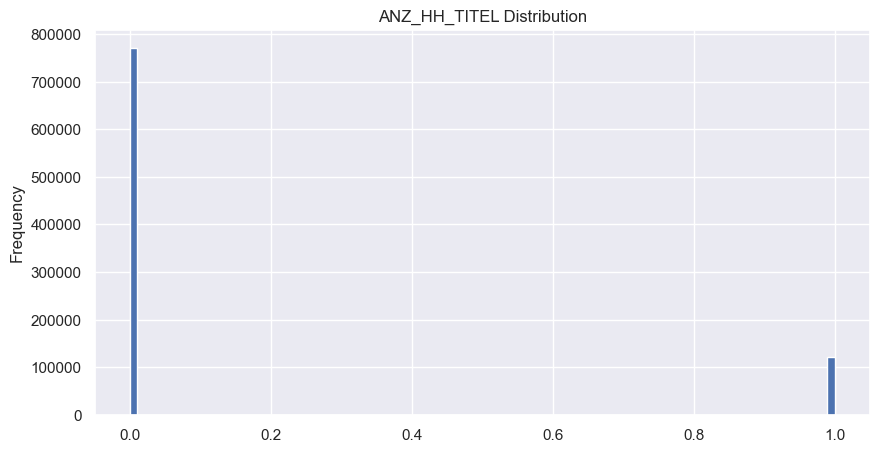

In [179]:
census['ANZ_HH_TITEL'].plot(kind = 'hist', bins = 100, title = 'ANZ_HH_TITEL Distribution')

This column might benefit from being binarized

In [133]:
census['ANZ_HH_TITEL'].value_counts()

0.0     770244
1.0      20157
2.0       2459
3.0        585
4.0        232
5.0        117
6.0        106
8.0         68
7.0         65
9.0         34
13.0        29
12.0        22
11.0        22
14.0        16
10.0        16
17.0        13
20.0         9
15.0         7
18.0         6
16.0         3
23.0         3
Name: ANZ_HH_TITEL, dtype: int64

In [134]:
census['ANZ_HH_TITEL'] = np.where(census['ANZ_HH_TITEL'] == 0, 0, 1)

In [135]:
census['ANZ_HH_TITEL'].value_counts()

0    770244
1    120977
Name: ANZ_HH_TITEL, dtype: int64

In [136]:
census_var_types['Encoded Type'] = np.nan

In [137]:
census_var_types.loc[census_var_types['Attribute'] == 'ANZ_HH_TITEL', 'Encoded Type'] = 'binary'

## 125 Grid

In [177]:
def count_val_in_cols(df, col_list, plot_count = False,**count_kwargs):

    '''
    Counts values in each categories for a group of columns in a dataset.
    Has the option to plot these distributions.

    :param df: DataFrame with columns to be counted
    :param col_list: List of column names that will be counted
    :param plot_count: Boolean indicating if resuls should be displayed as graphs (True) or as regular prints (False)
    :param **count_kwargs: Pandas' .value_counts() method key-word arguments
    '''

    for col in col_list:

        val_count = df[col].value_counts(**count_kwargs)

        if plot_count:
            
            g = sns.barplot(data = val_count.reset_index(),
                        x = 'index',
                        y = col)
            
            g.bar_label(g.containers[-1], fmt = '%.2f')
            
            plt.title(f'Variable = {col}')
            
            plt.show()
            
        else:

            print(val_count, end = '\n\n')

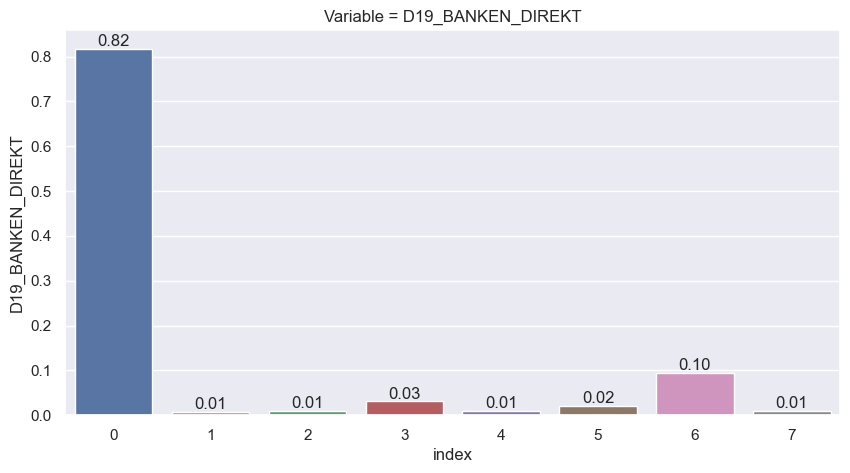

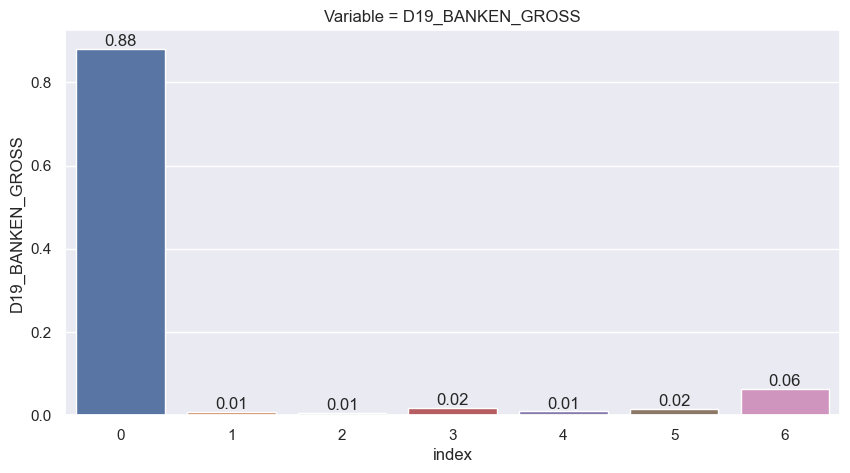

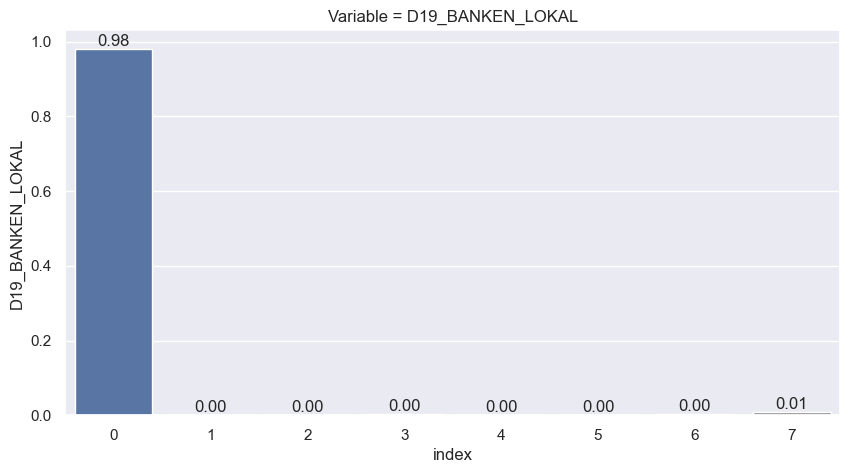

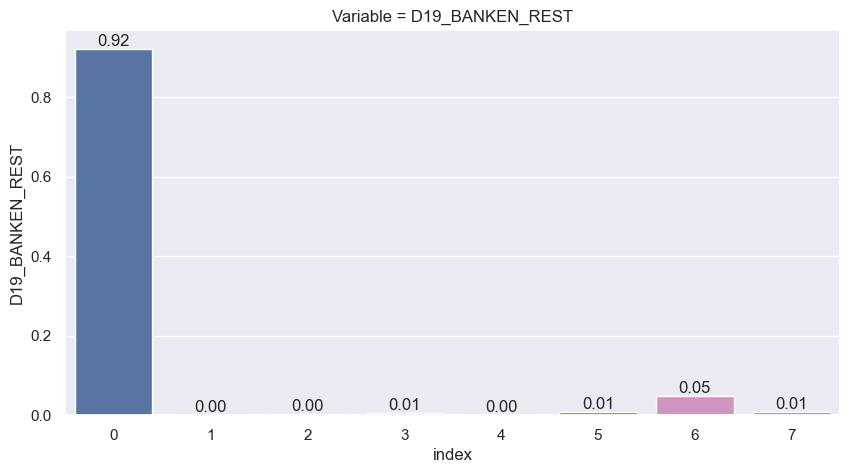

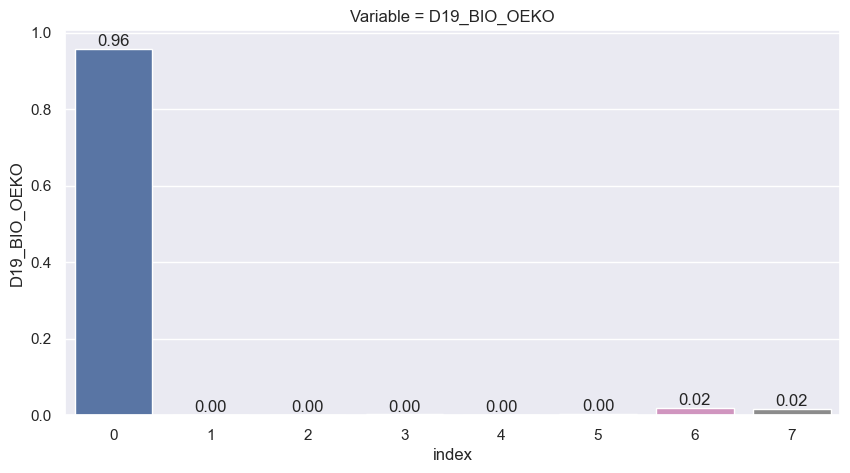

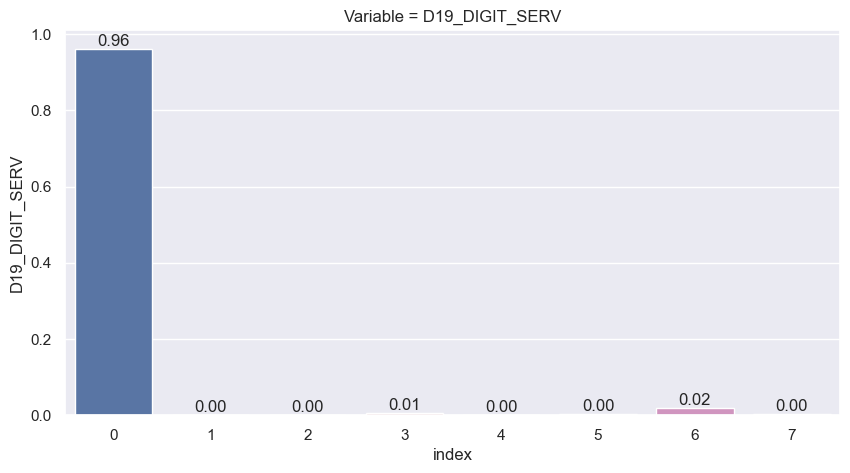

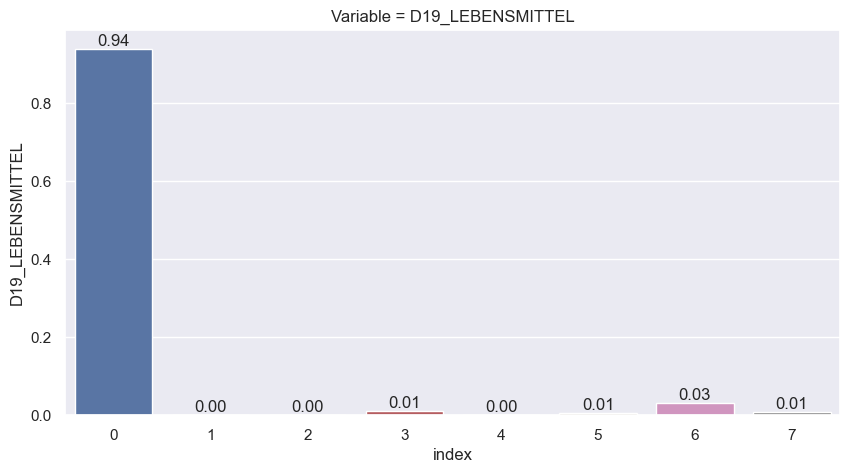

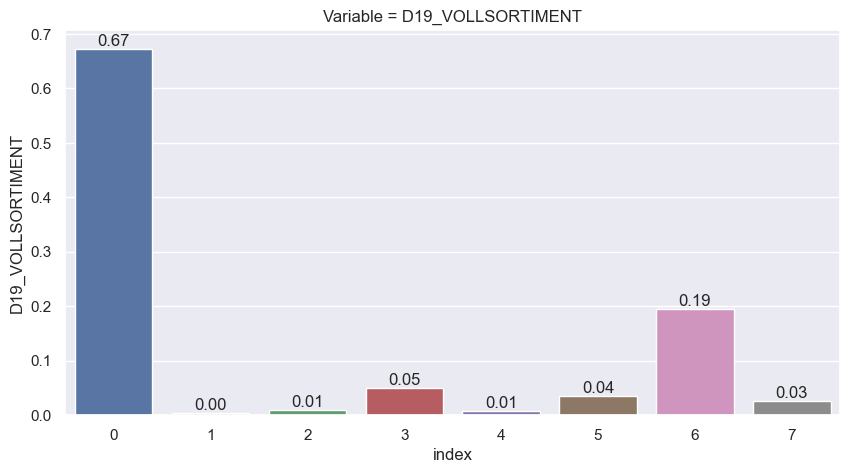

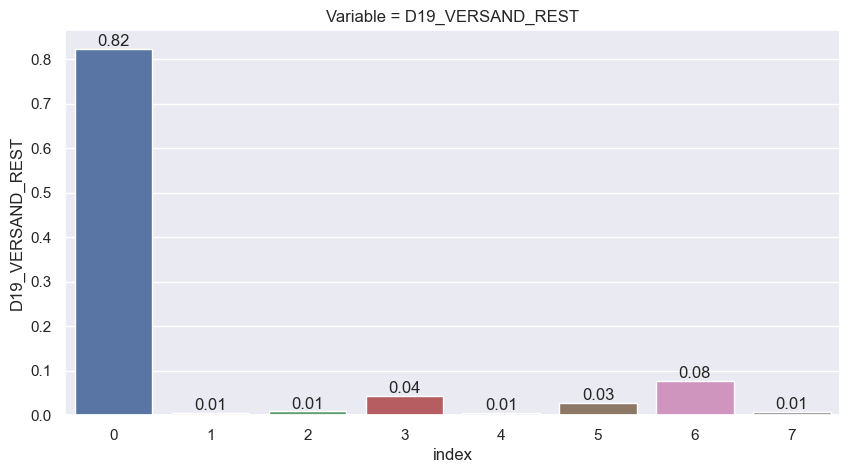

In [178]:
count_val_in_cols(census, grid_cols_list,plot_count=True,normalize = True)

There are some variables dominated by zeroes. This might not be necessairly helpful to aid cluster formation, but may help in identifying customers that actually are potential buyers, since they too are sparse in the database when considering the general population.  
Therefore these variables will be kept but should probably be re-encoded to help in information separation (reduce category sparsity)

## Buildings

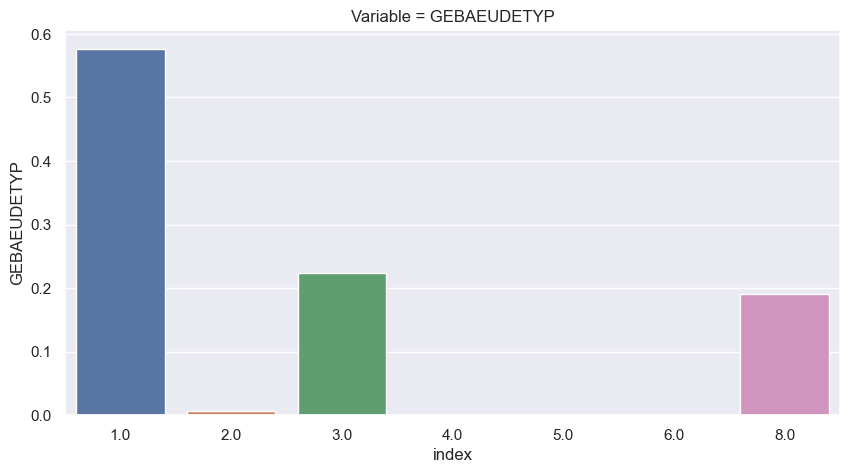

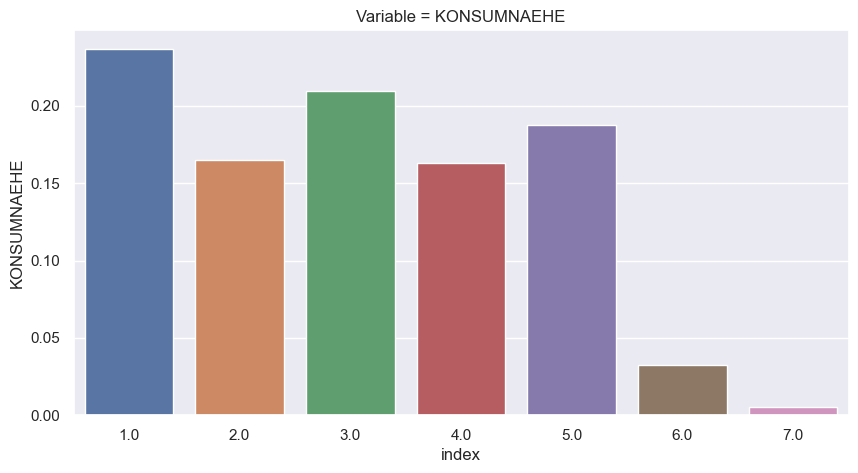

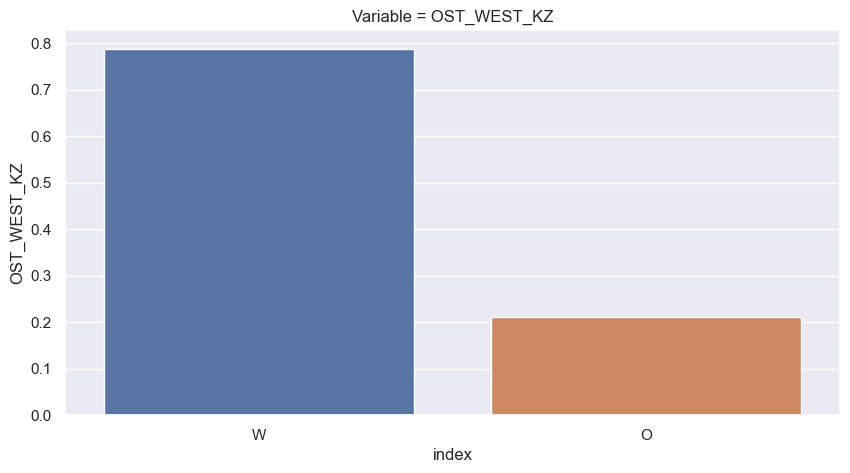

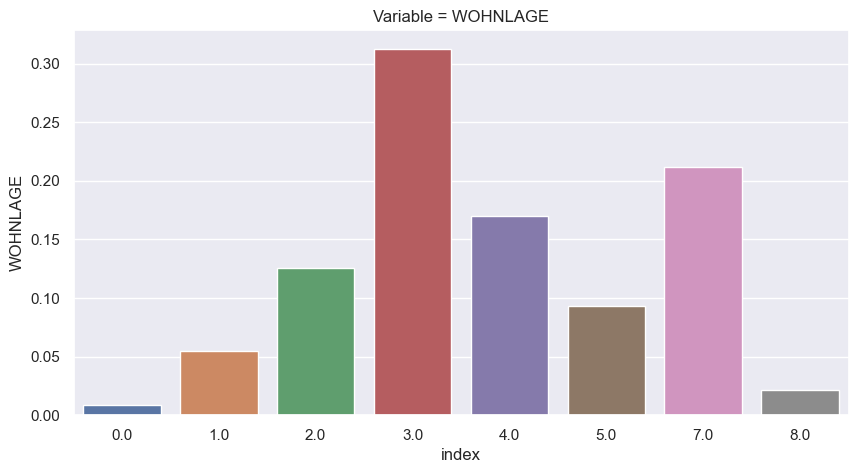

In [167]:
count_val_in_cols(census, buildings_col_list, plot_count = True, normalize = True)

## RR3

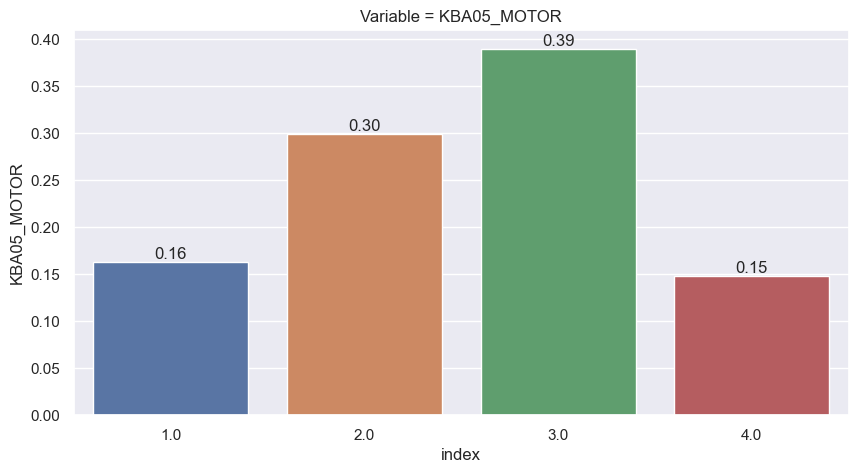

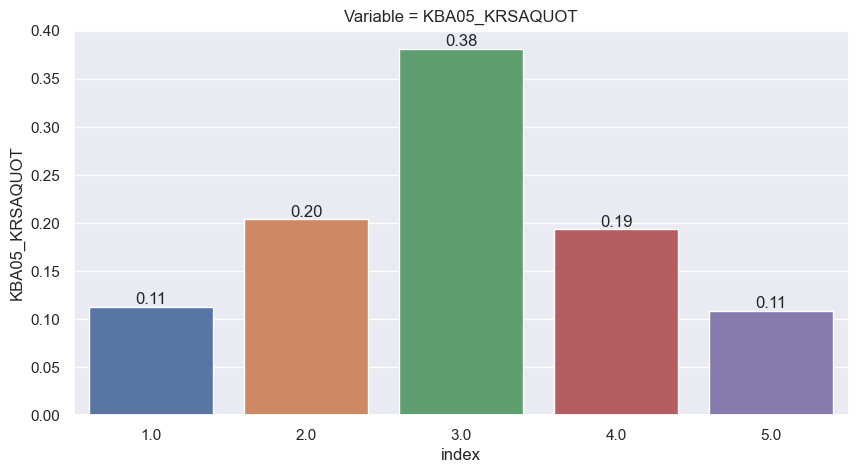

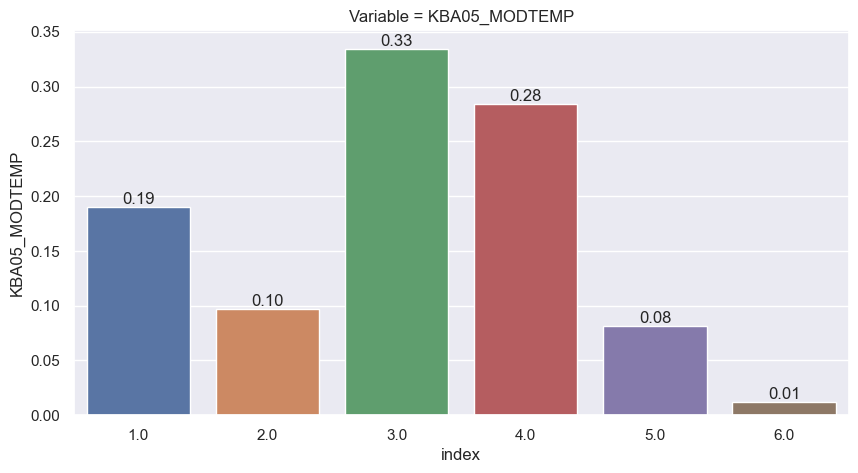

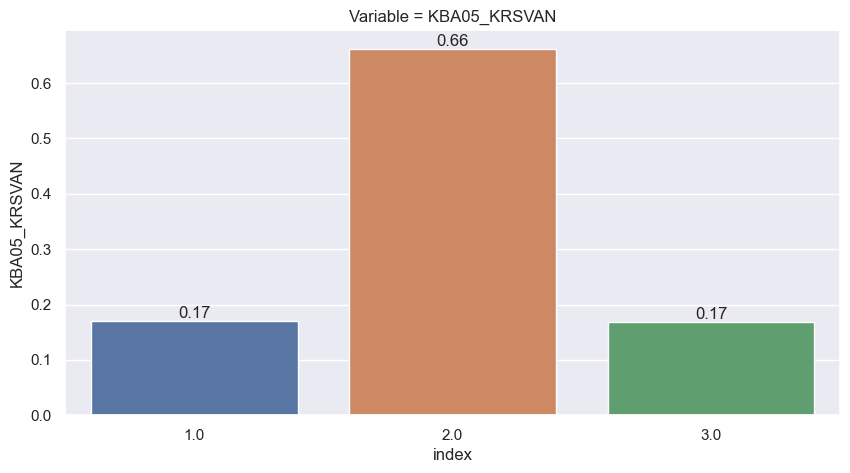

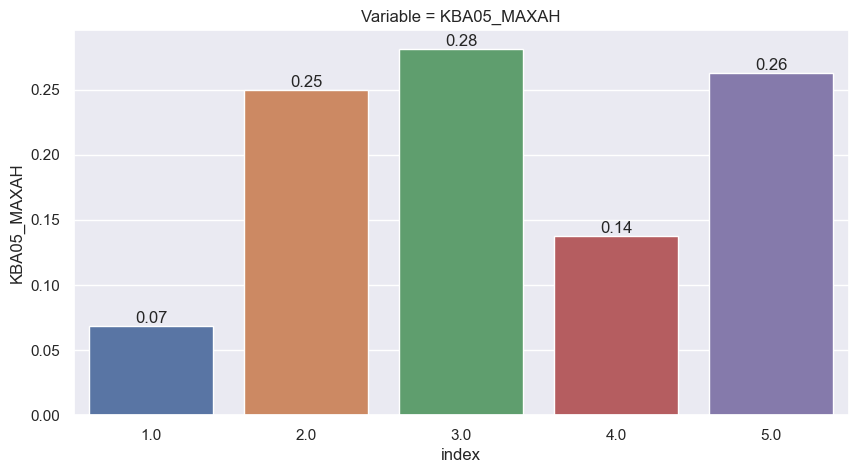

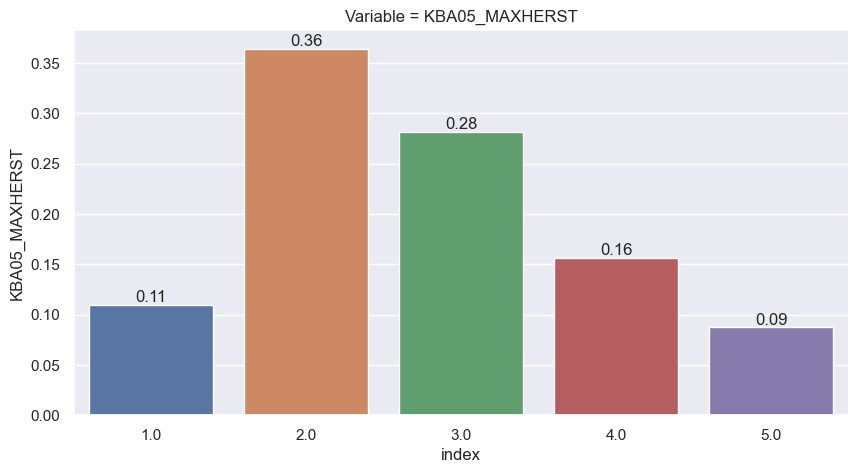

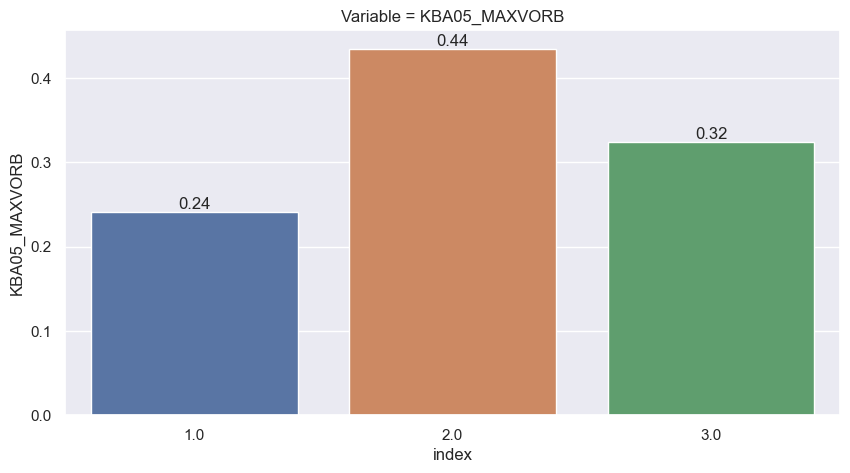

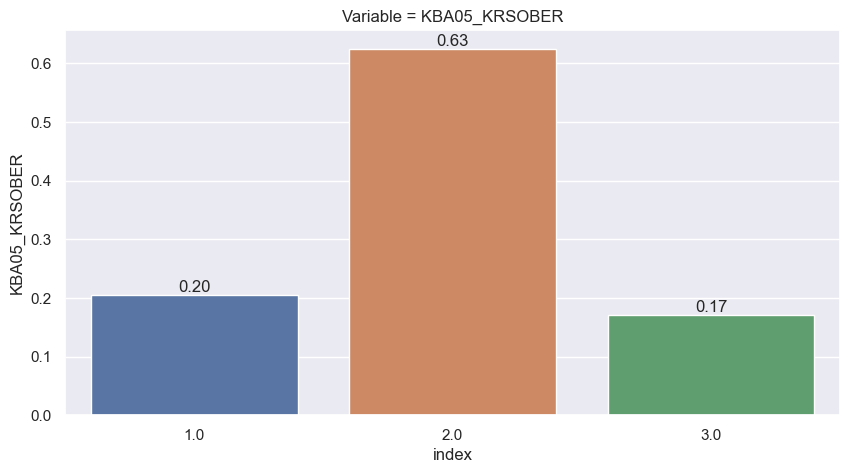

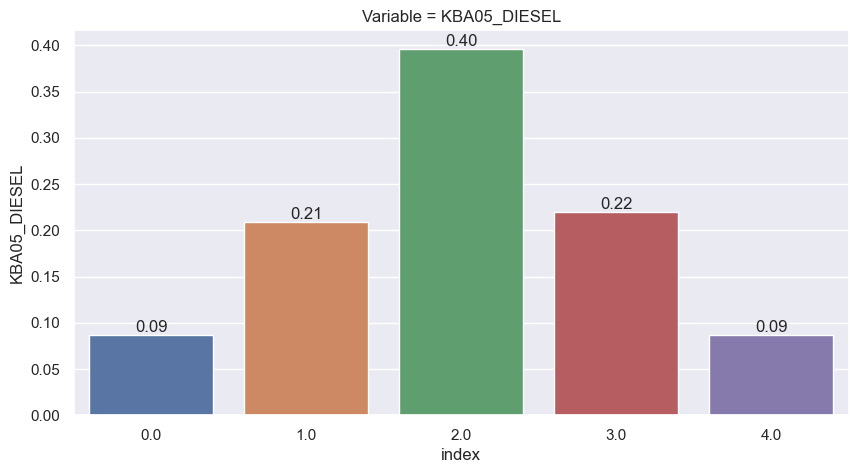

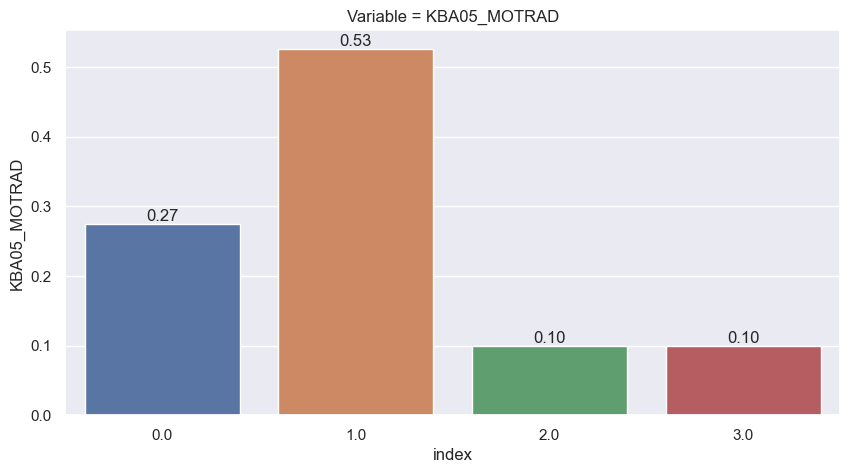

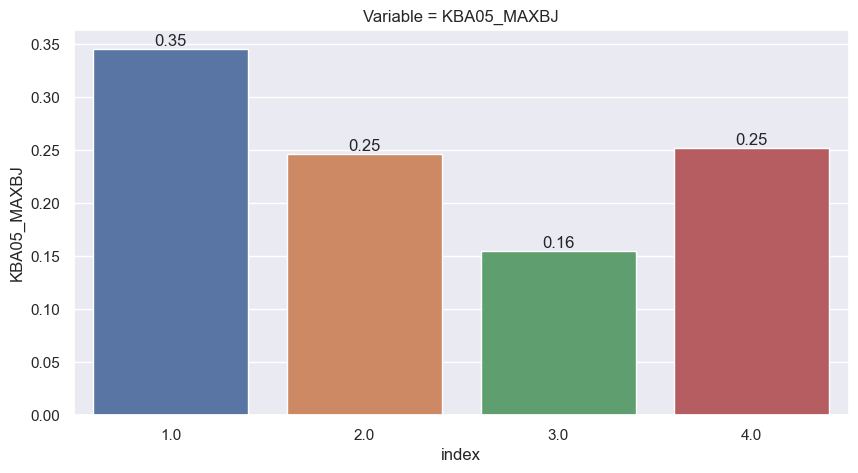

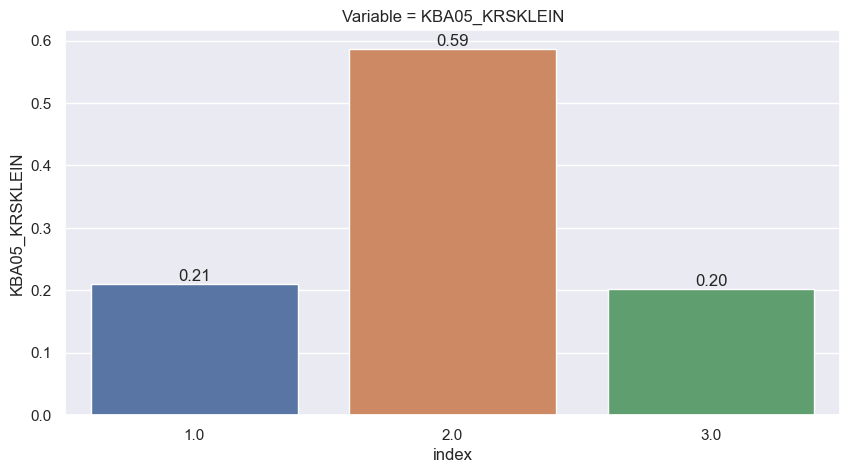

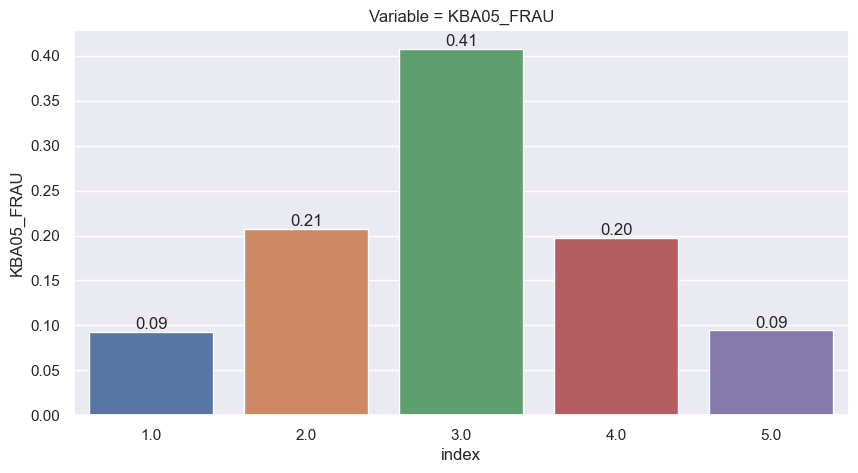

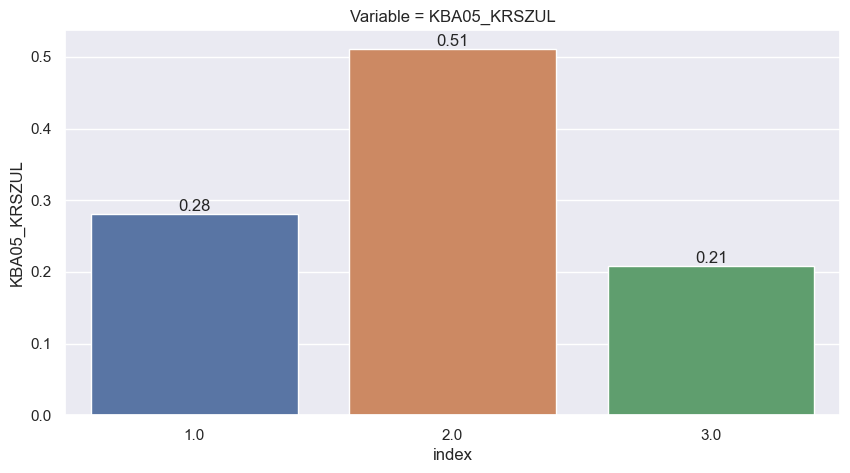

In [180]:
count_val_in_cols(census, rr3_col_list, plot_count = True, normalize = True)

No changes will be made to these variables, they seem reasonably distributed across categories

## Community

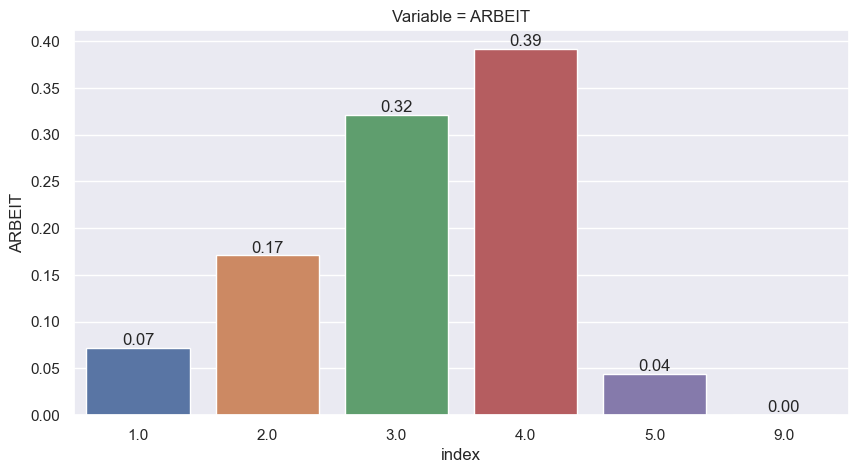

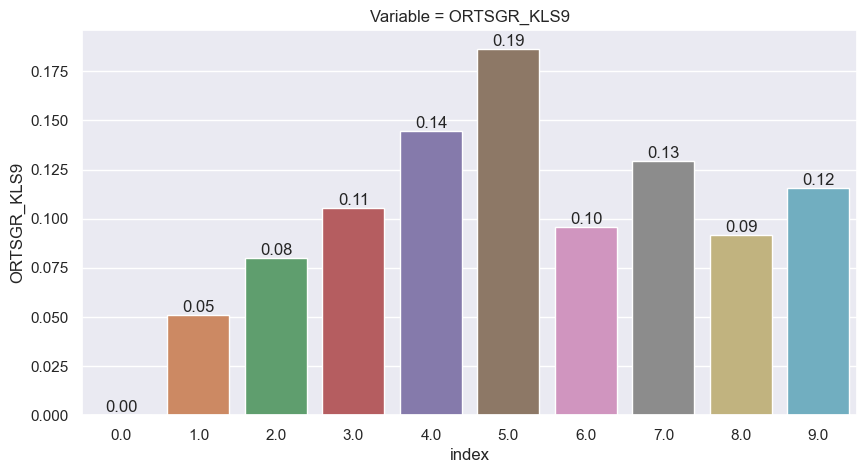

In [181]:
count_val_in_cols(census, community_col_list, plot_count = True, normalize = True)

## Household

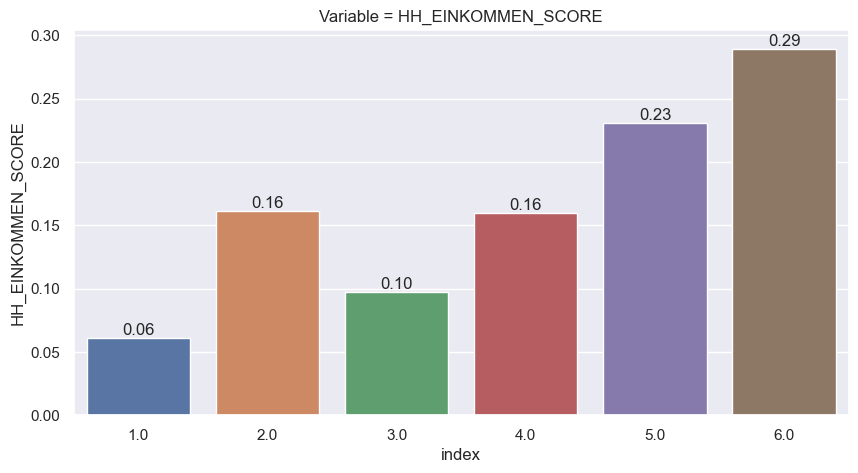

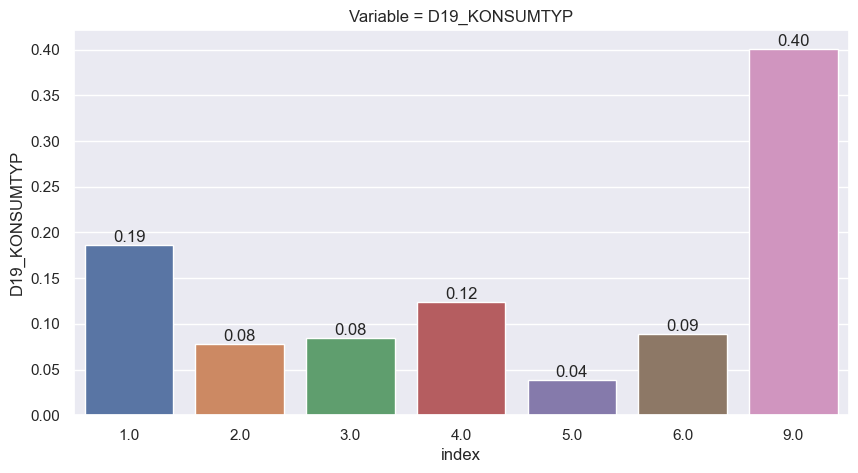

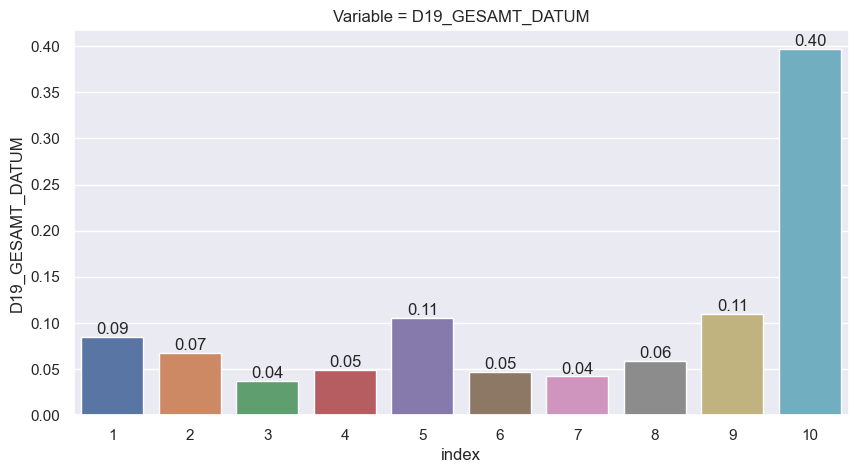

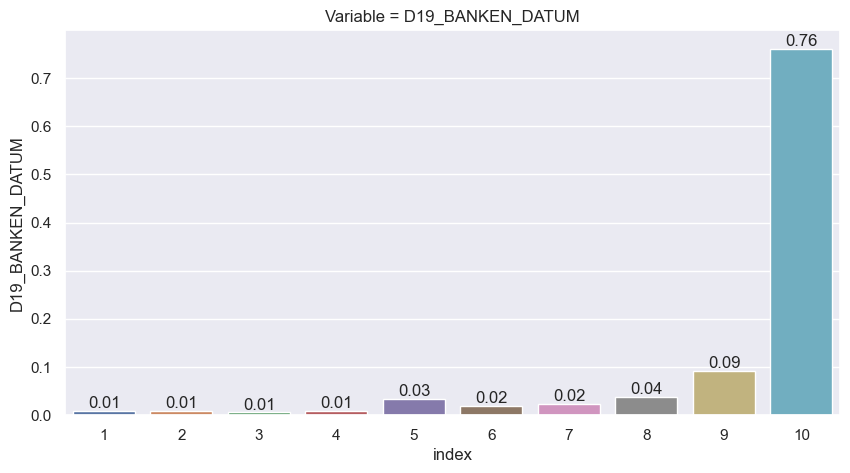

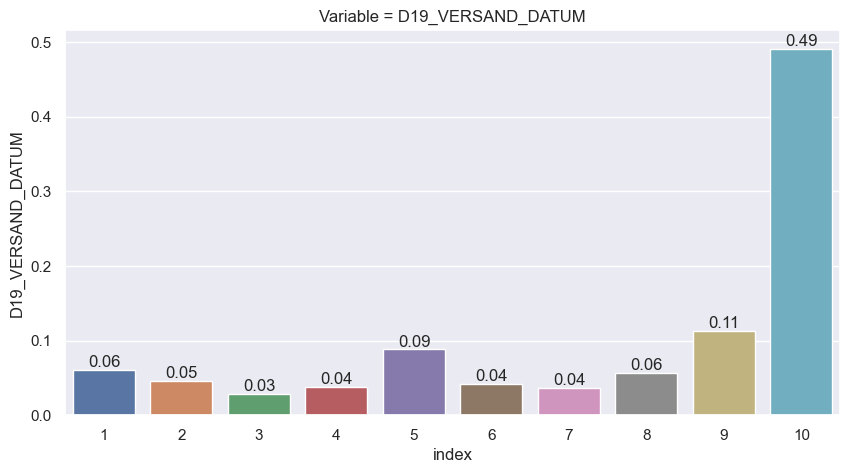

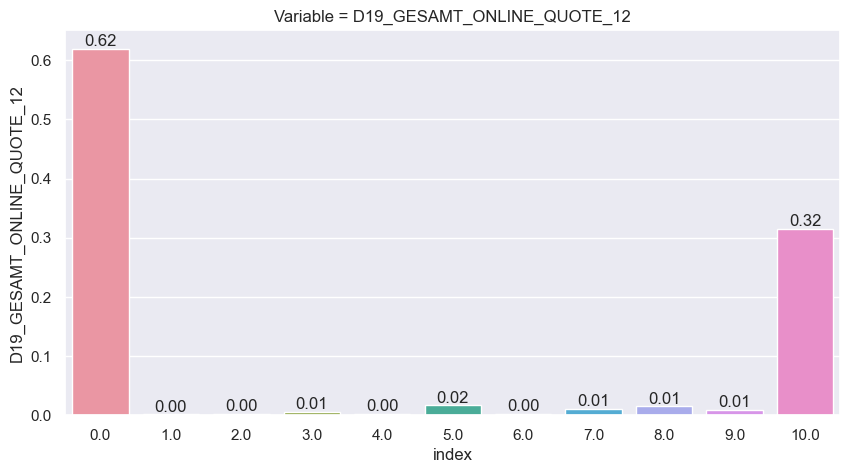

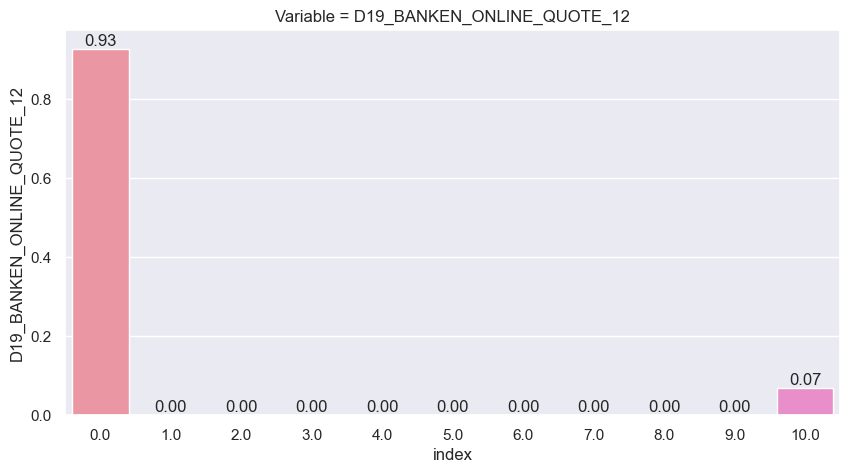

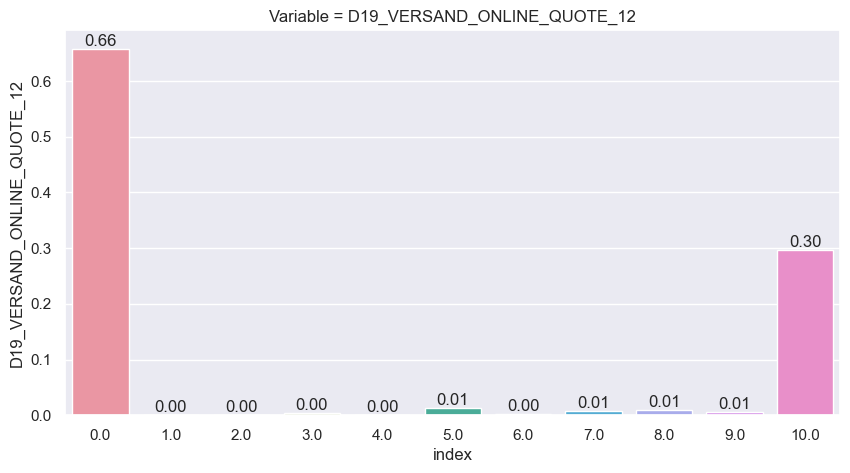

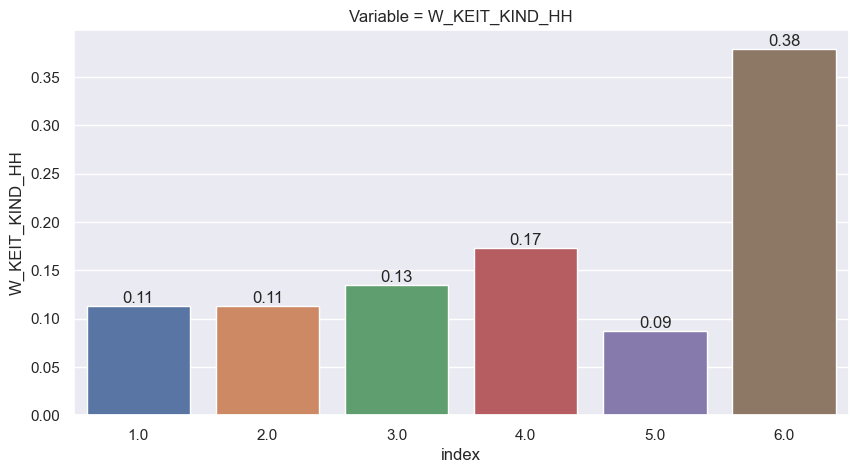

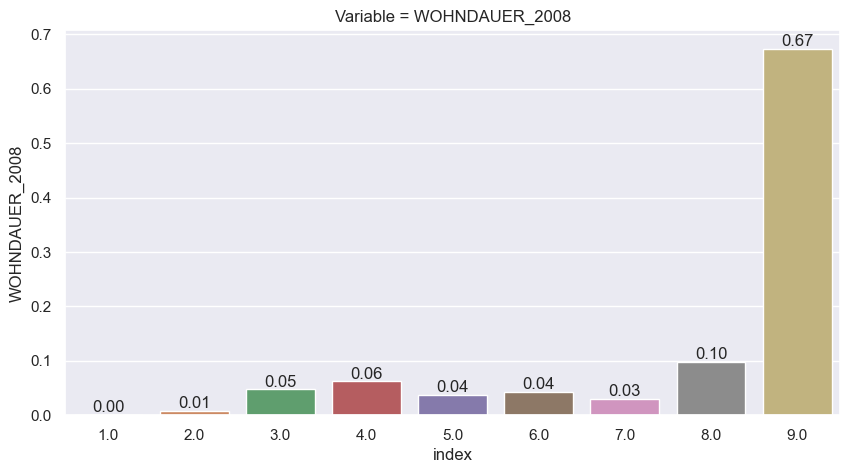

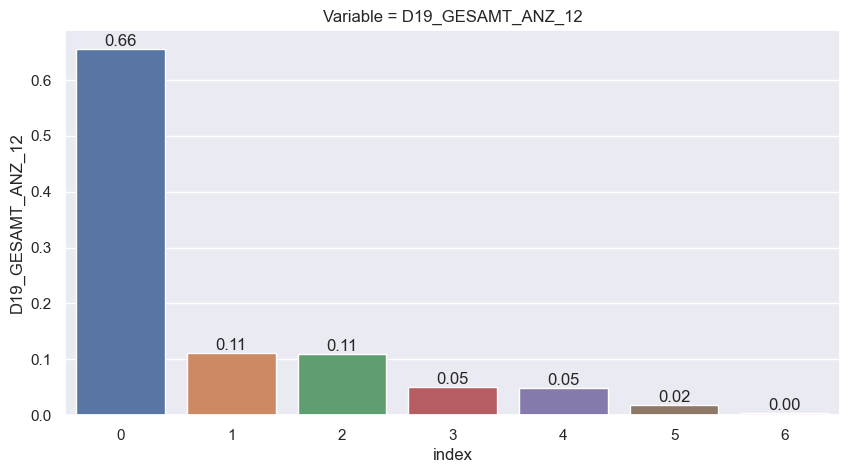

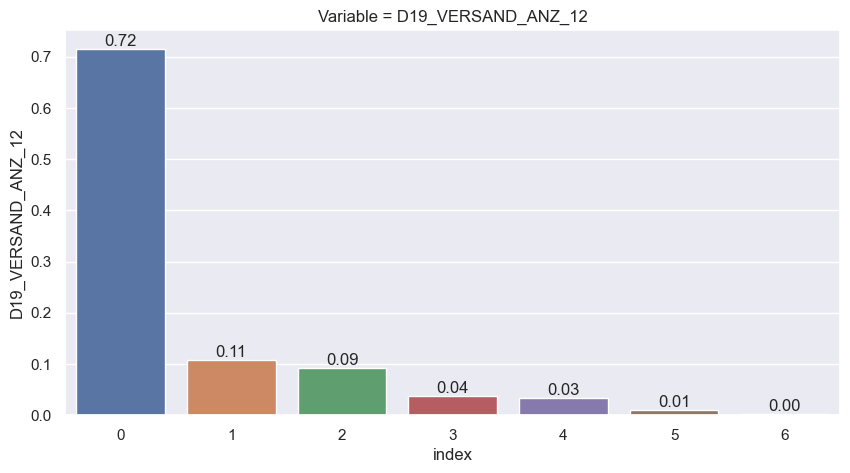

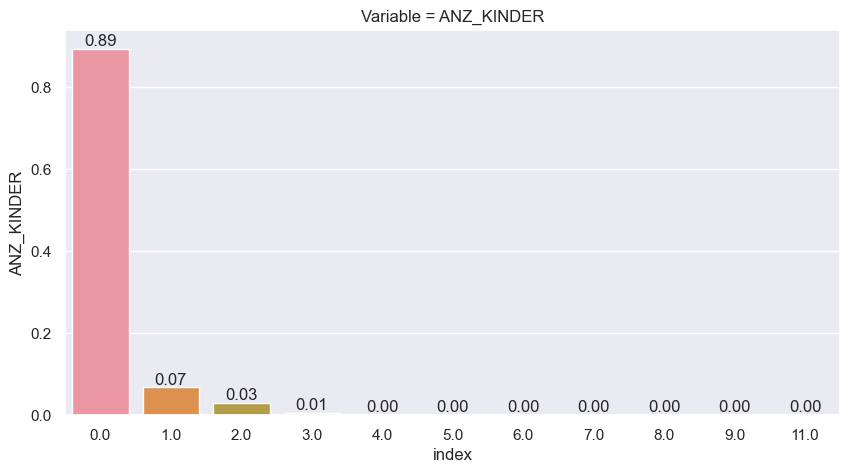

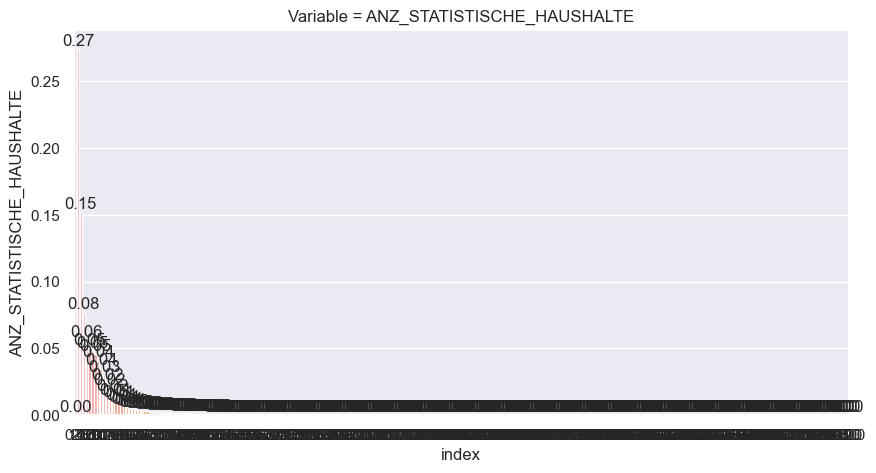

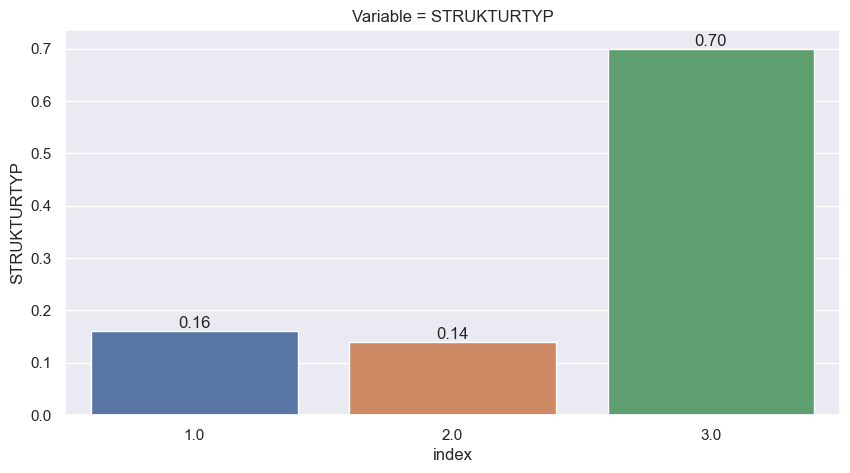

In [182]:
count_val_in_cols(census, household_cols_list, plot_count = True, normalize = True)

The D19 columns might benefit from some grouping of their informations, since the main behaviors are often concentrated in some categories

## RR4

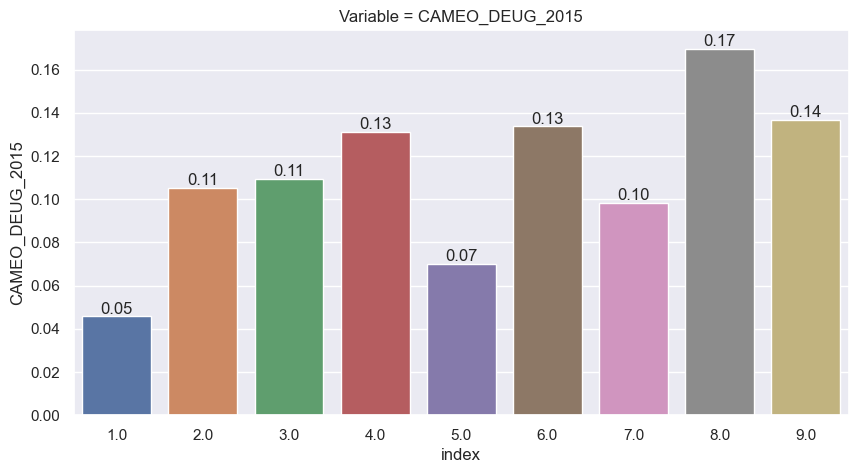

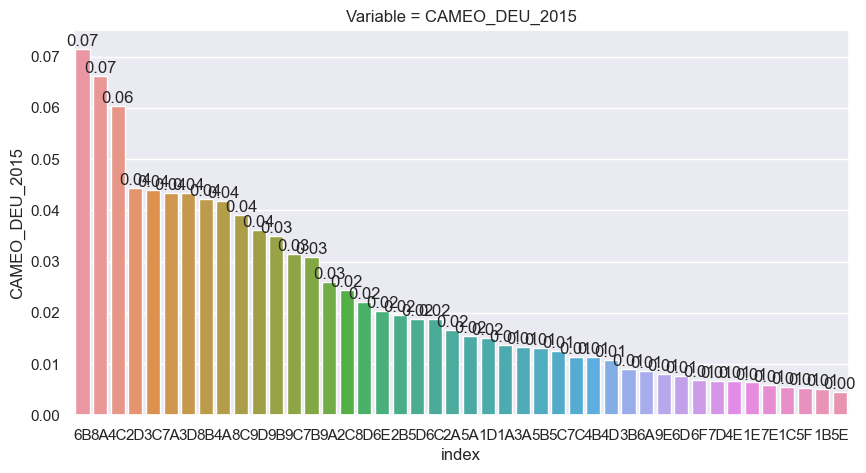

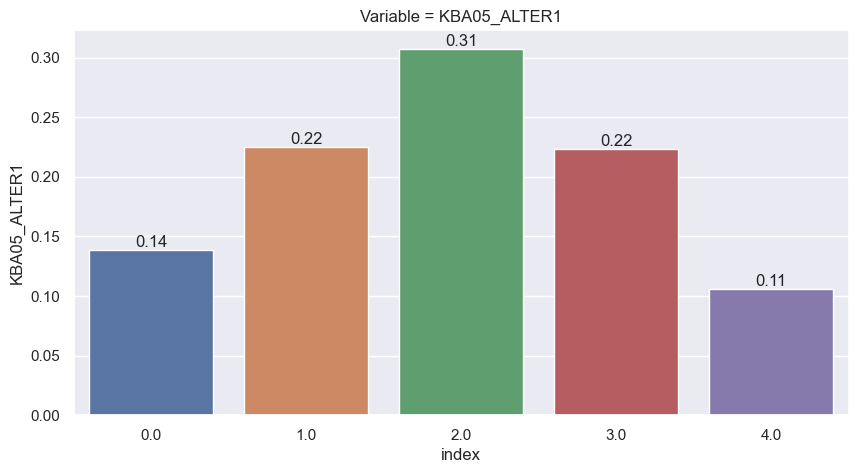

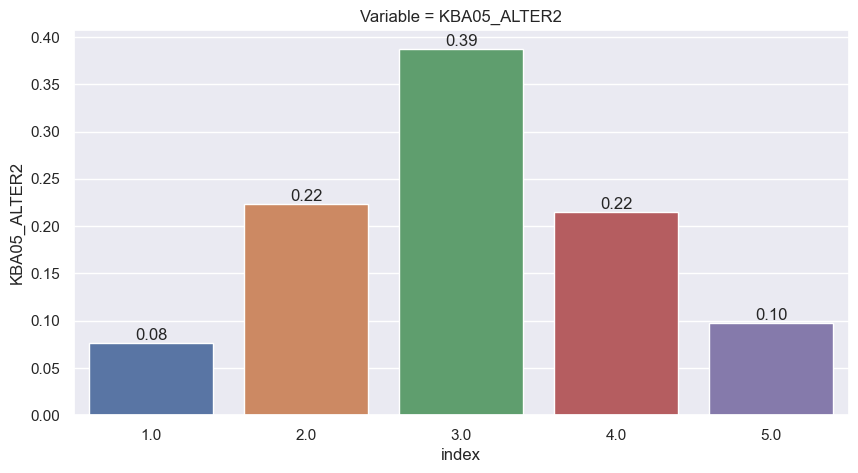

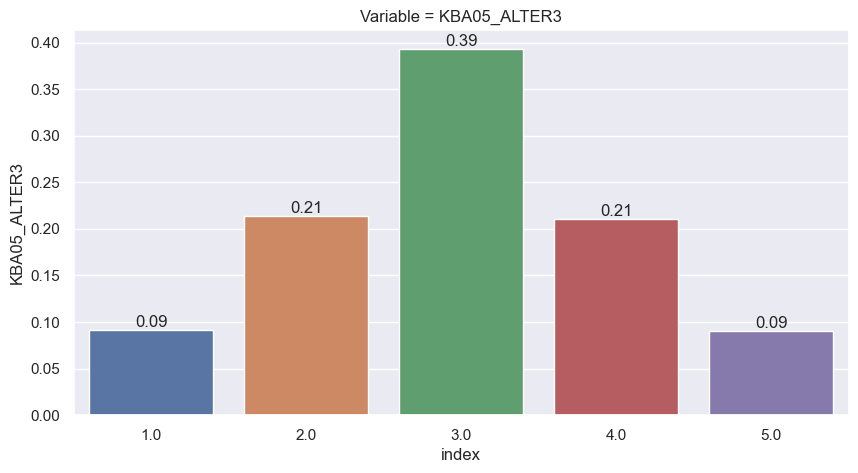

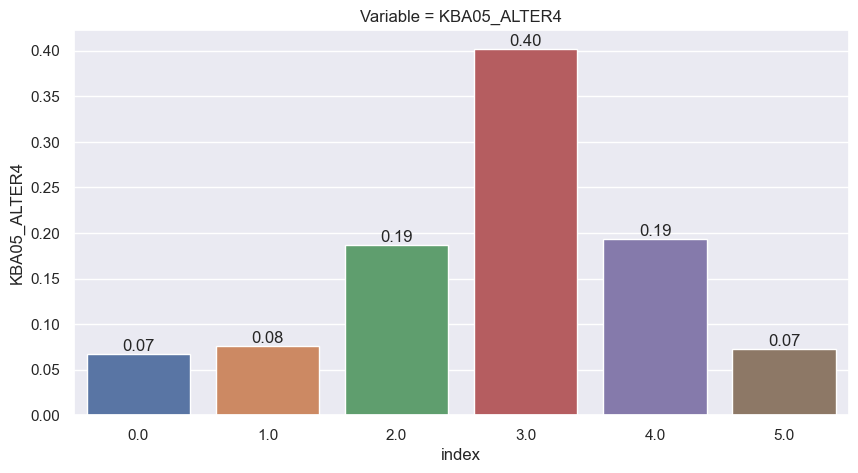

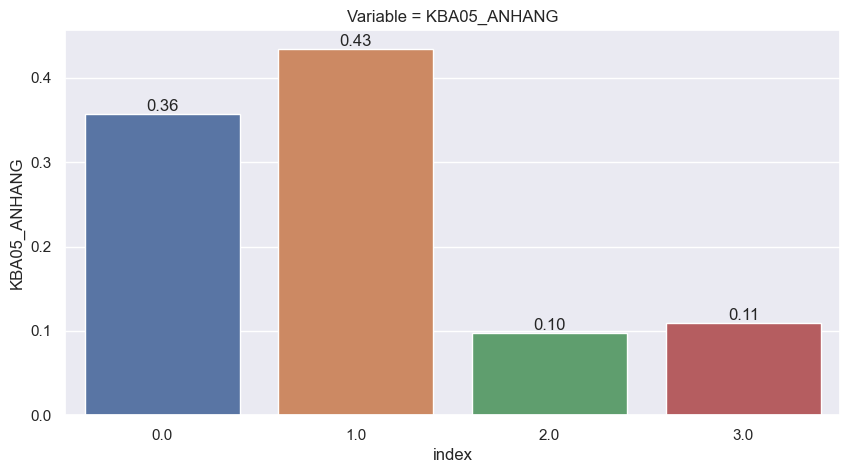

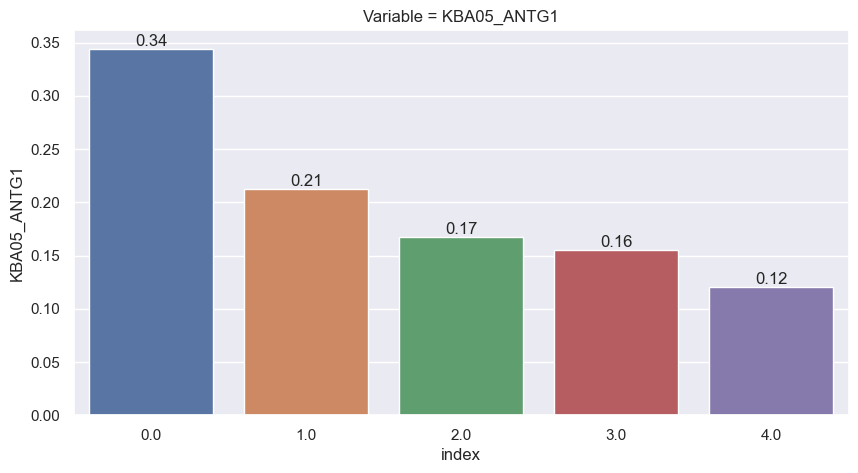

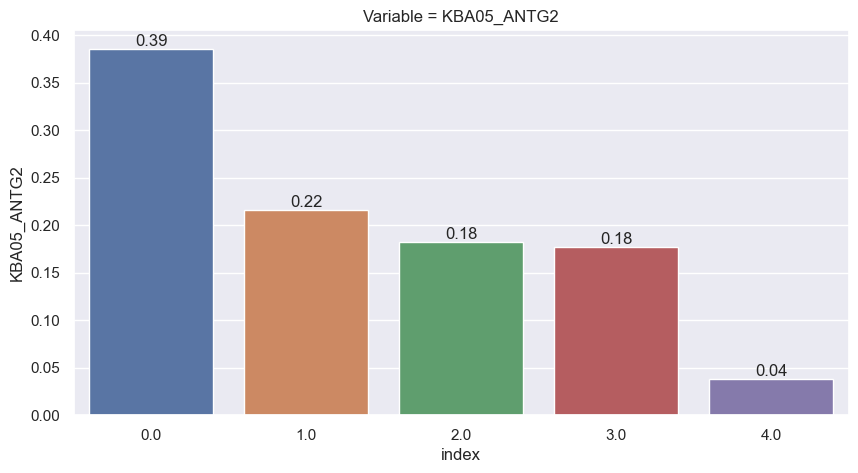

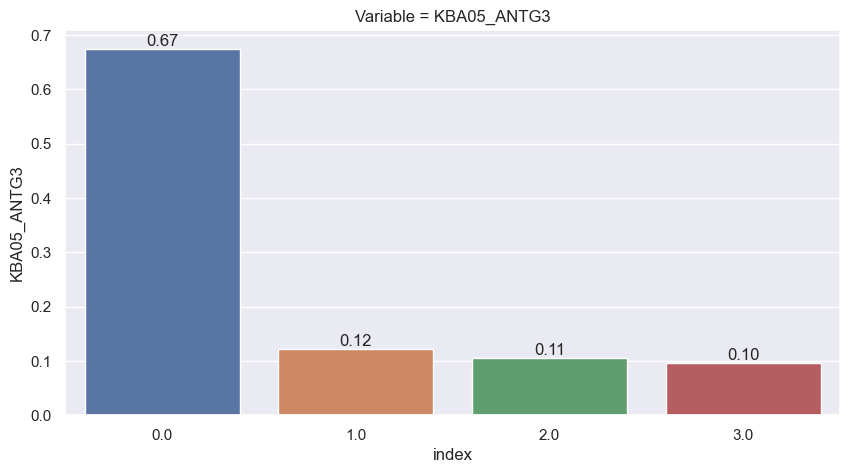

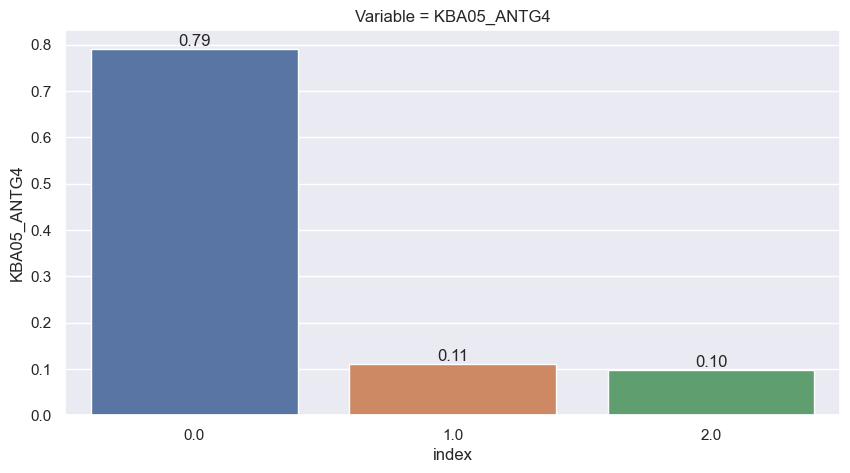

In [183]:
count_val_in_cols(census, rr4_col_list, plot_count = True, normalize = True)

## Person

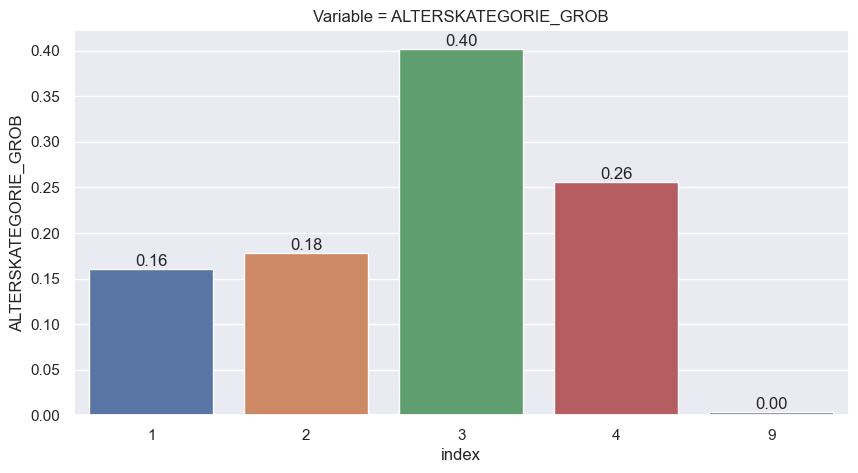

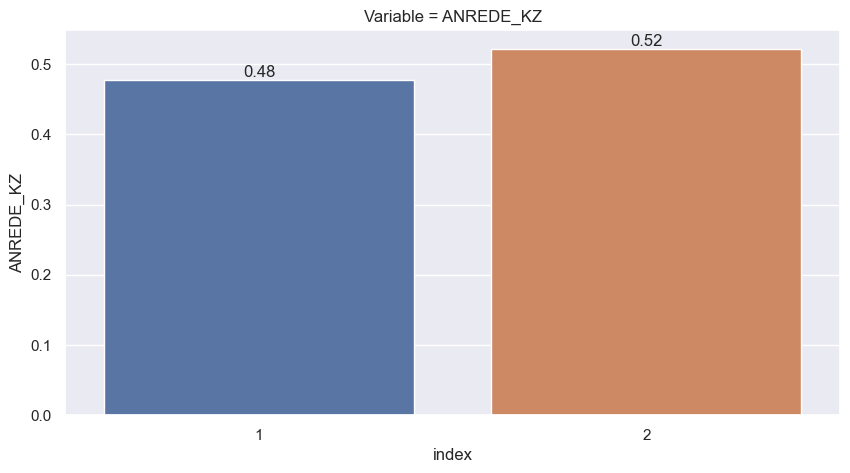

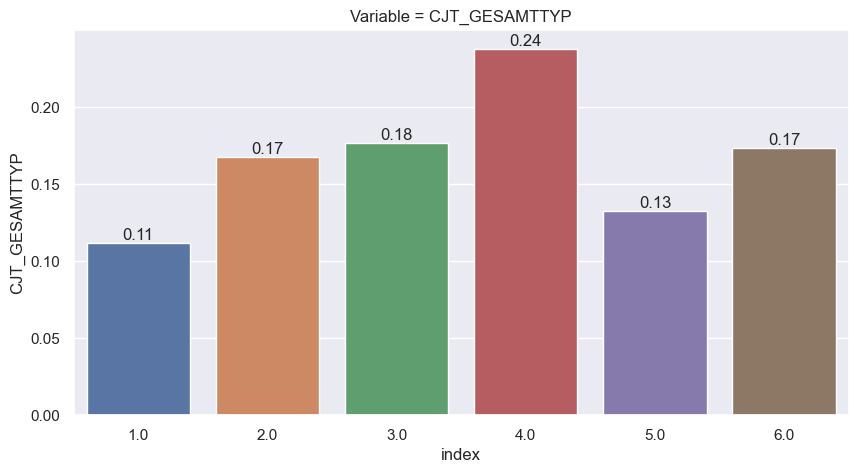

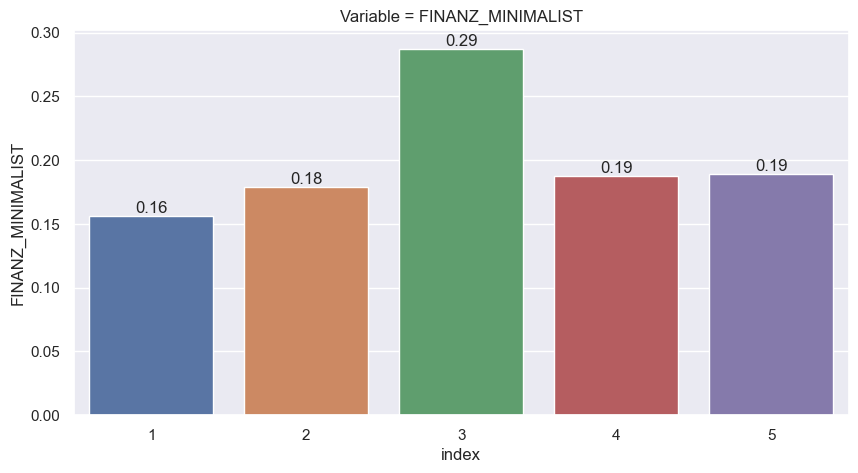

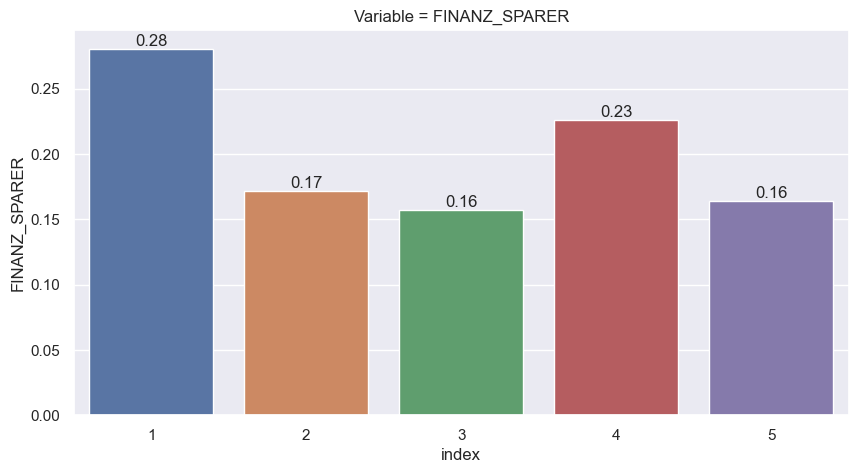

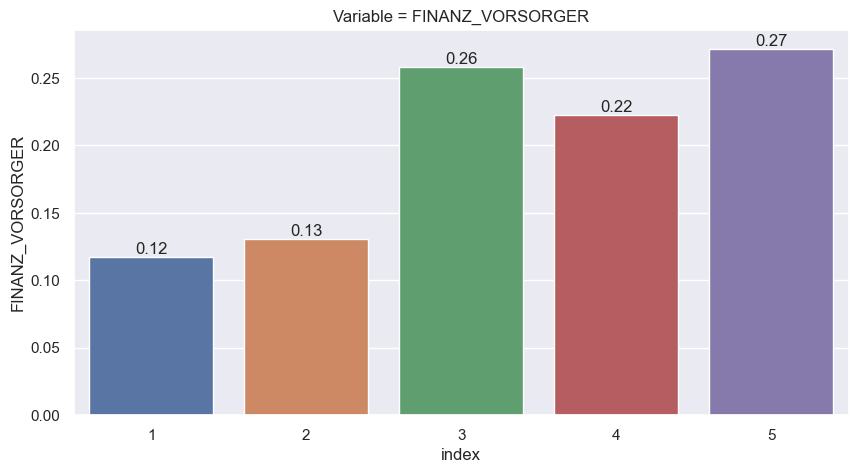

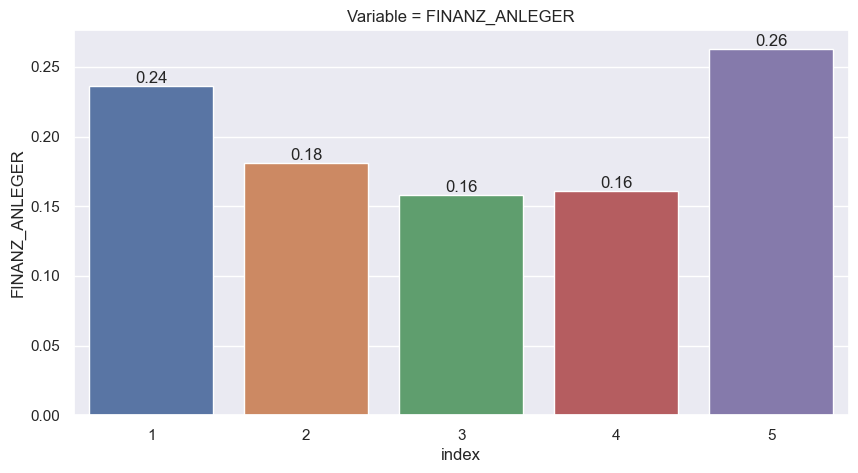

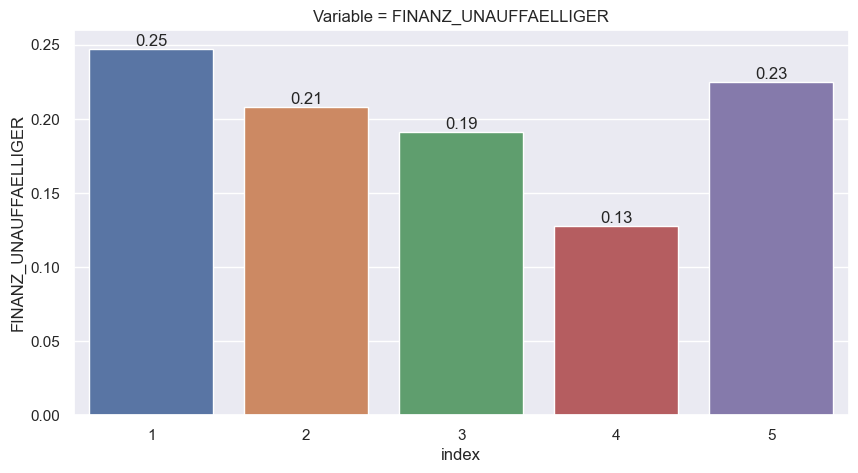

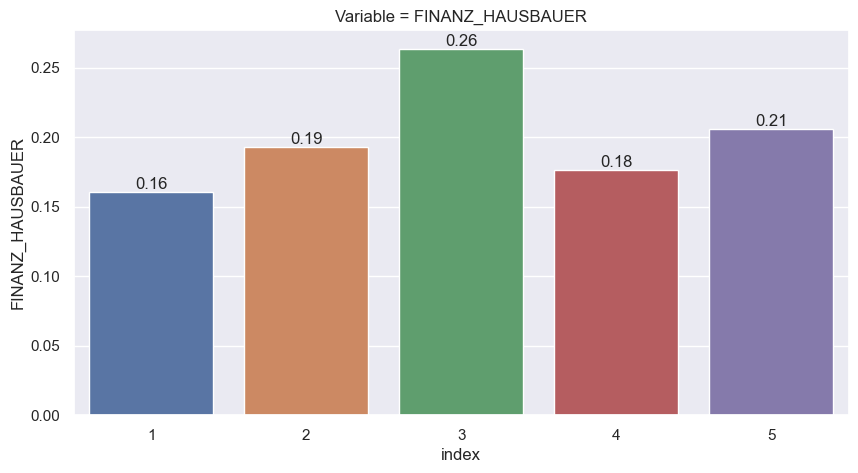

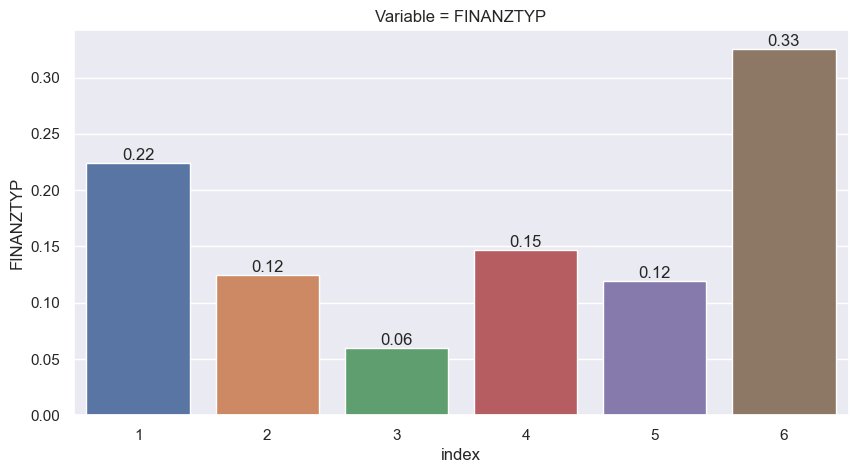

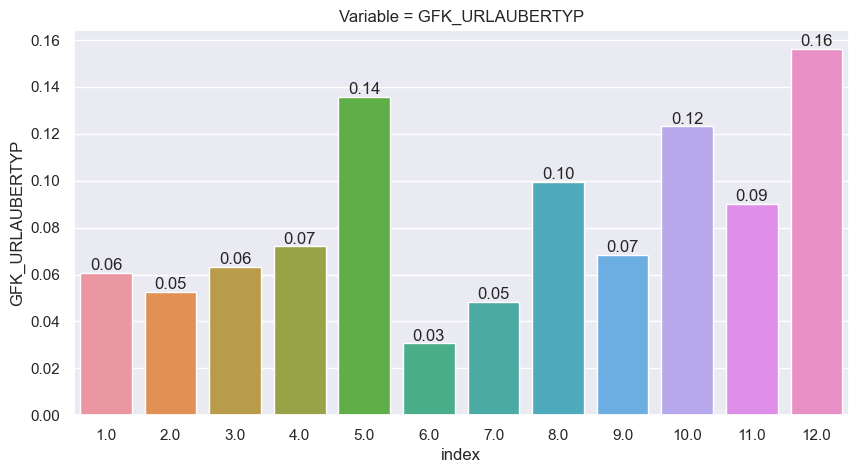

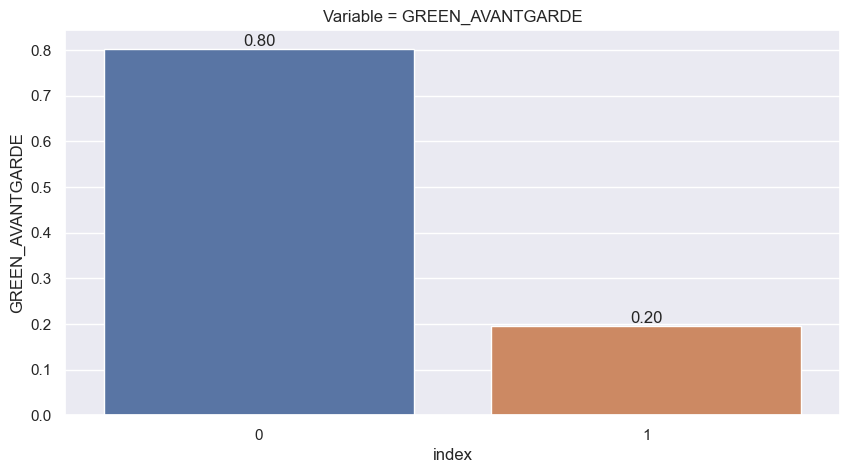

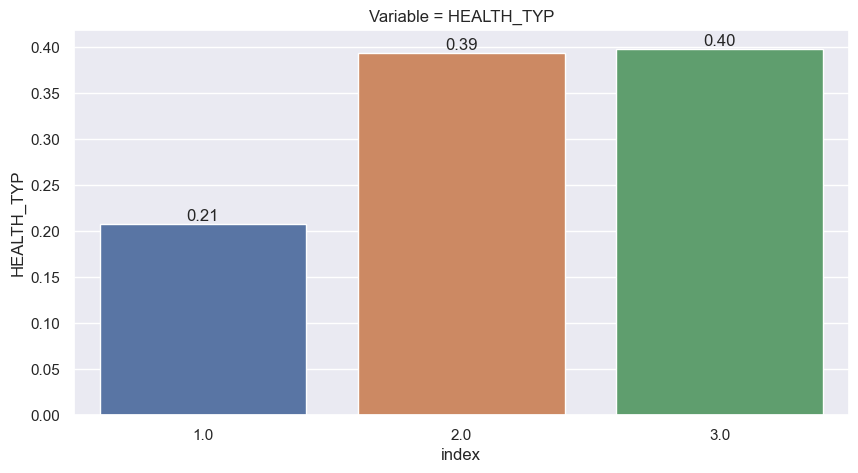

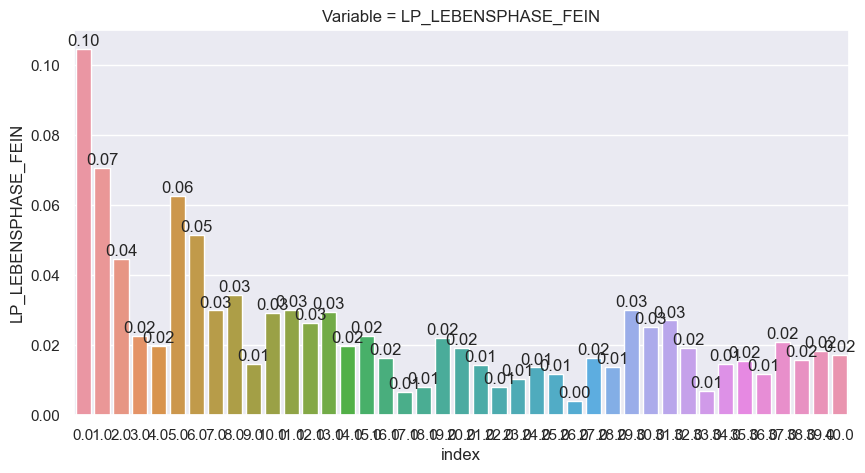

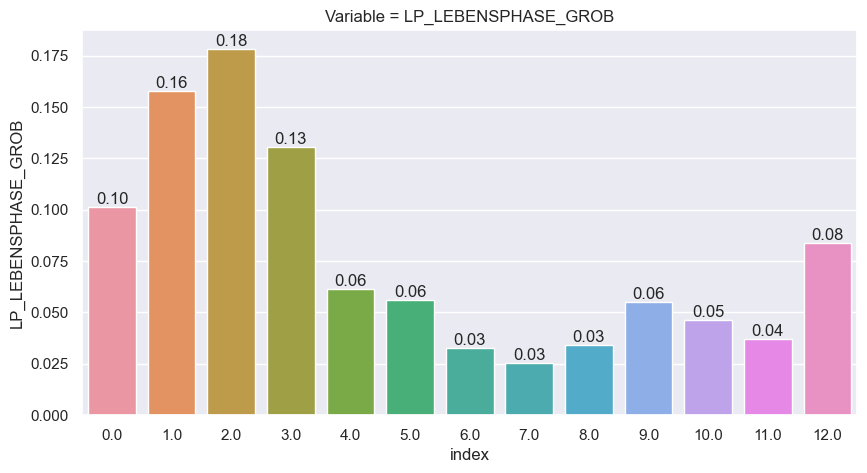

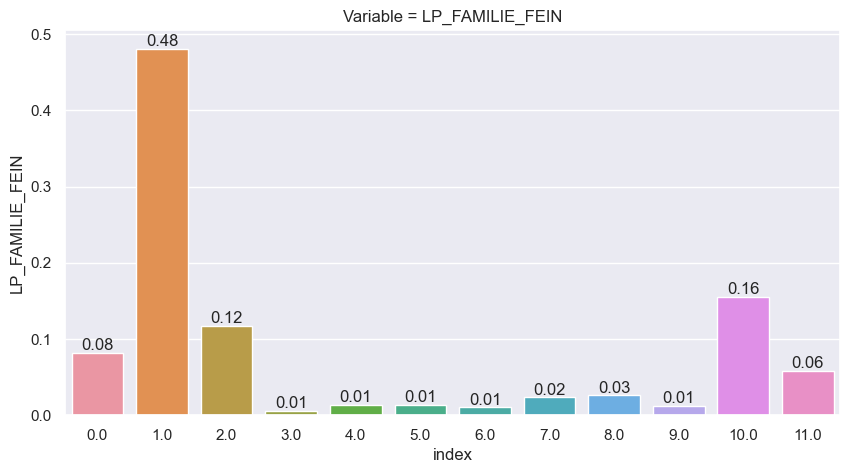

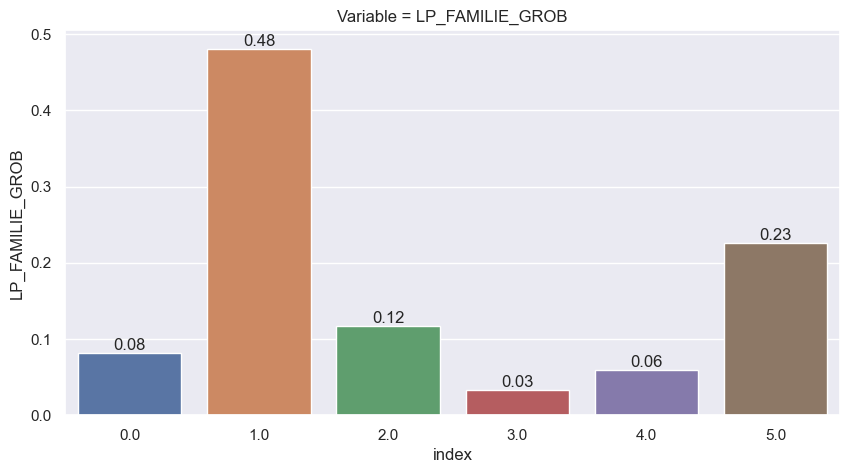

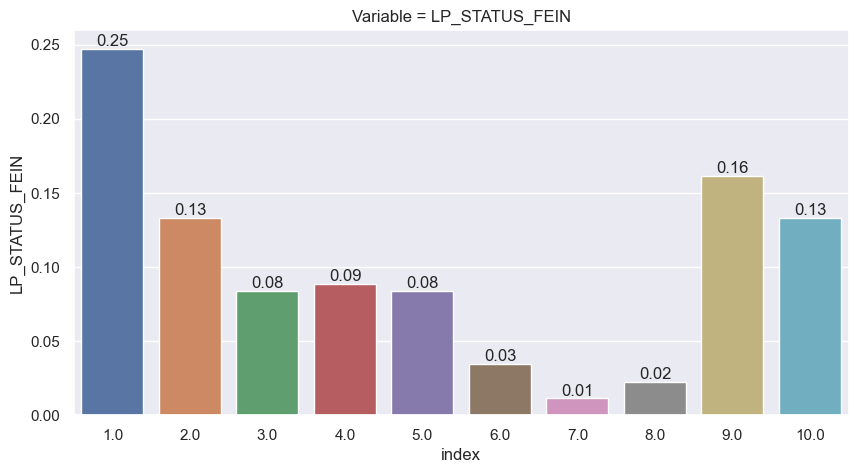

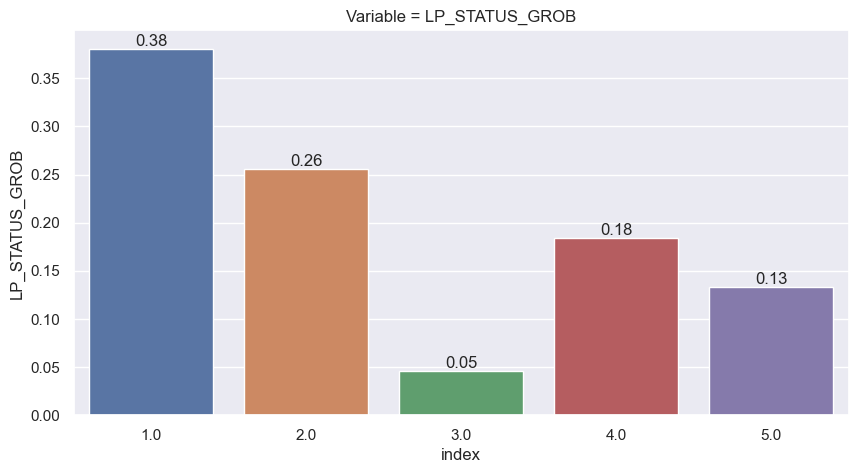

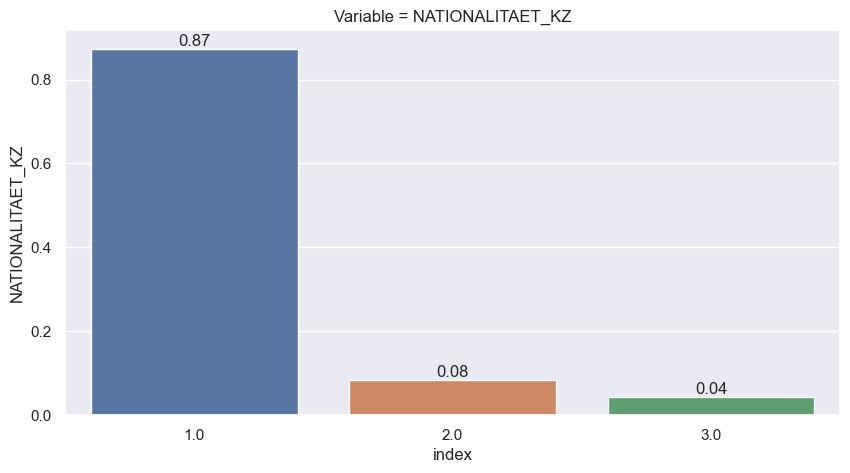

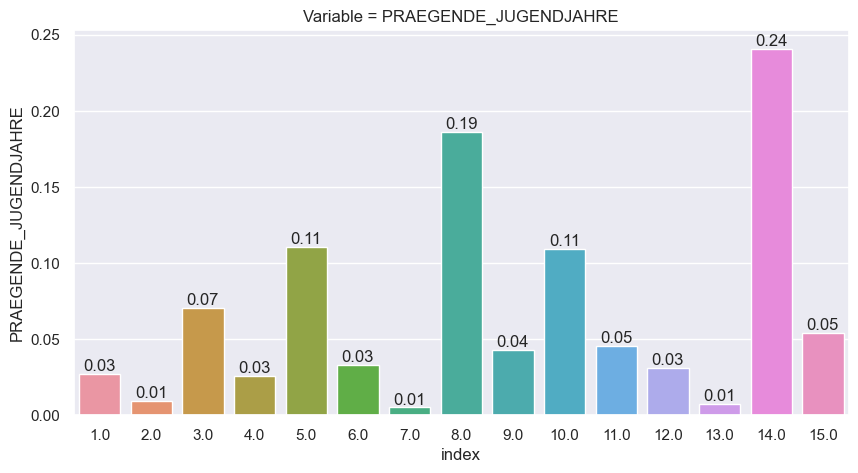

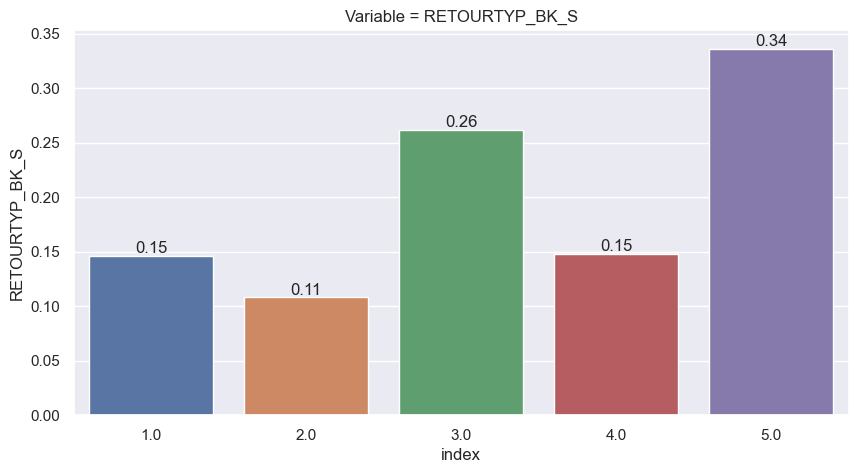

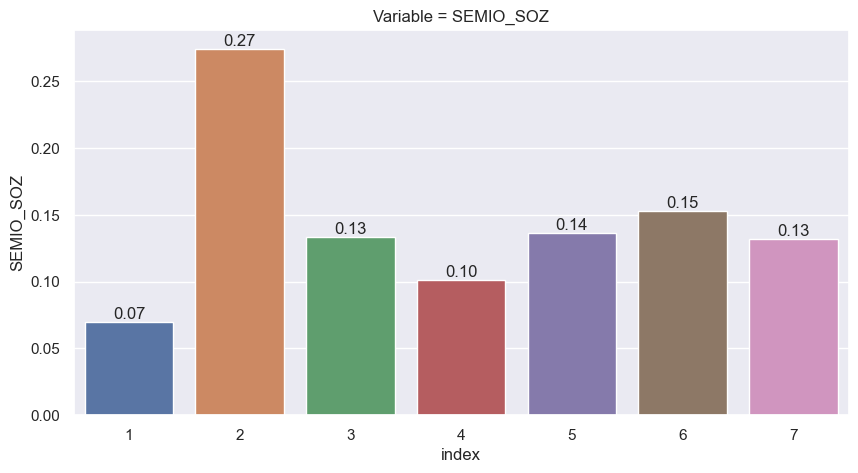

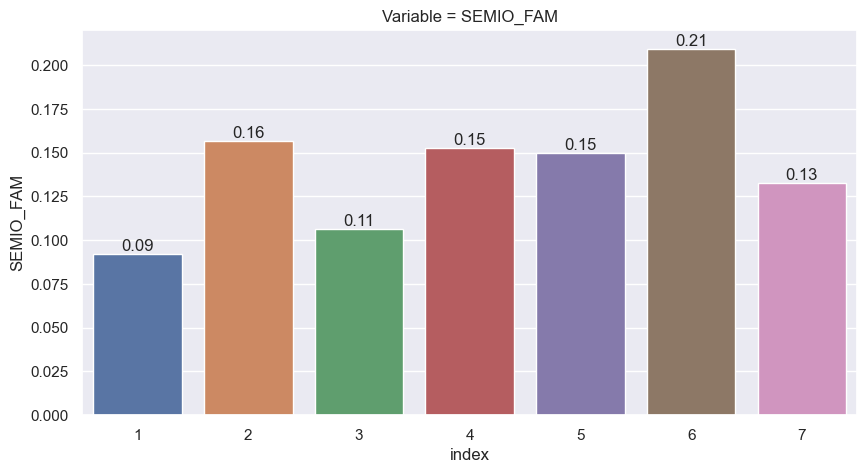

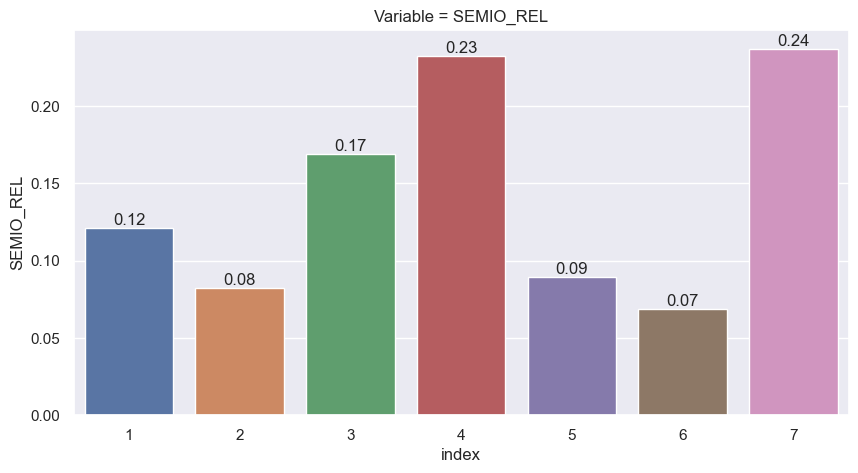

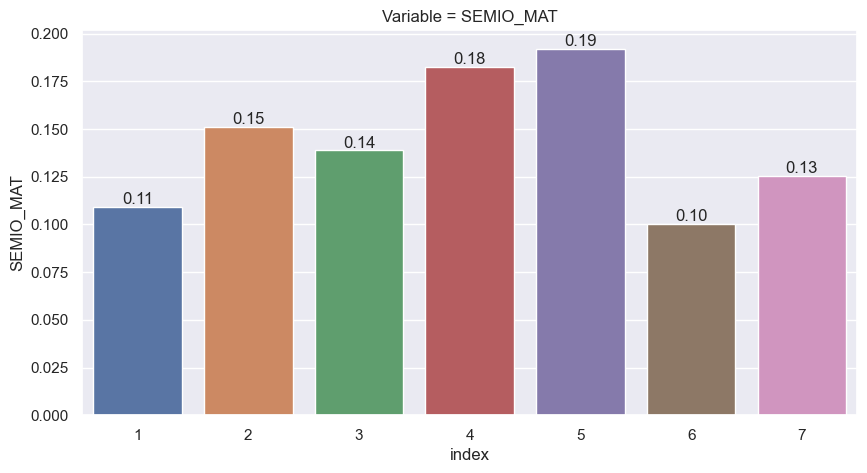

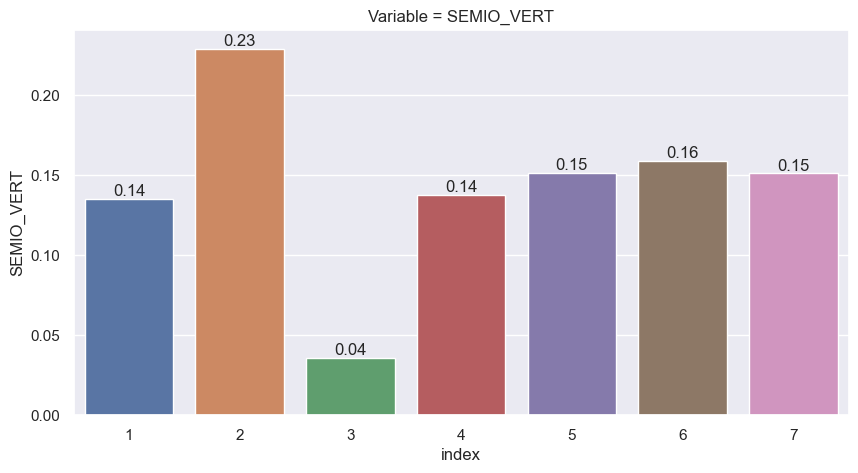

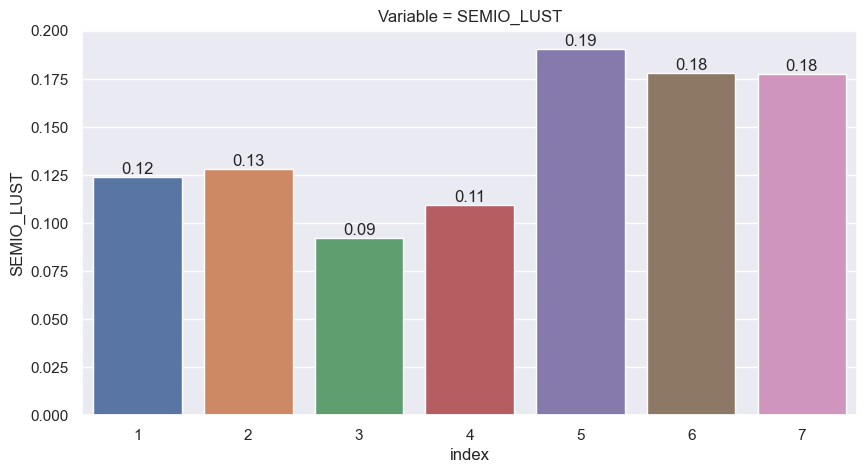

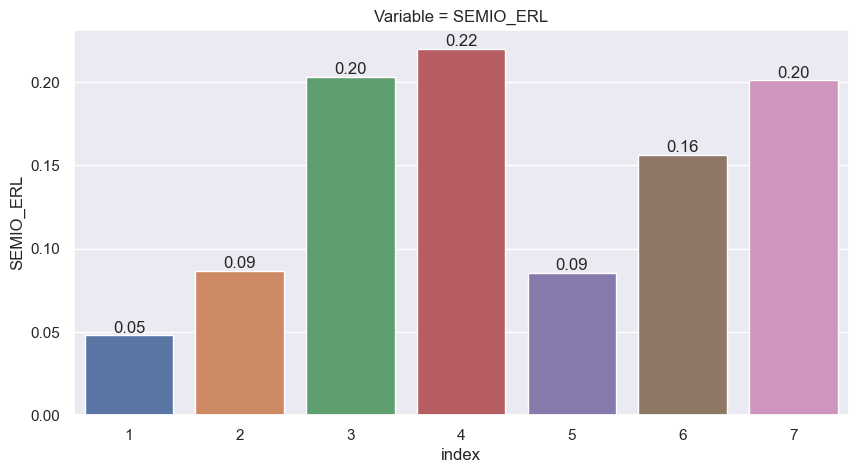

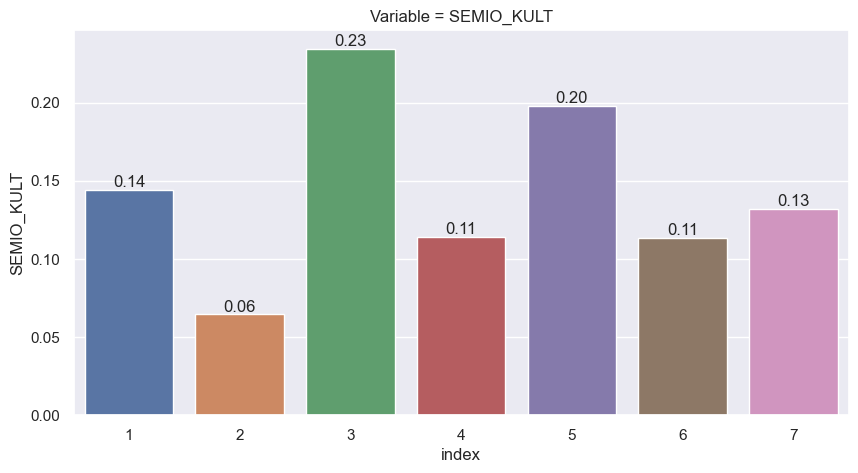

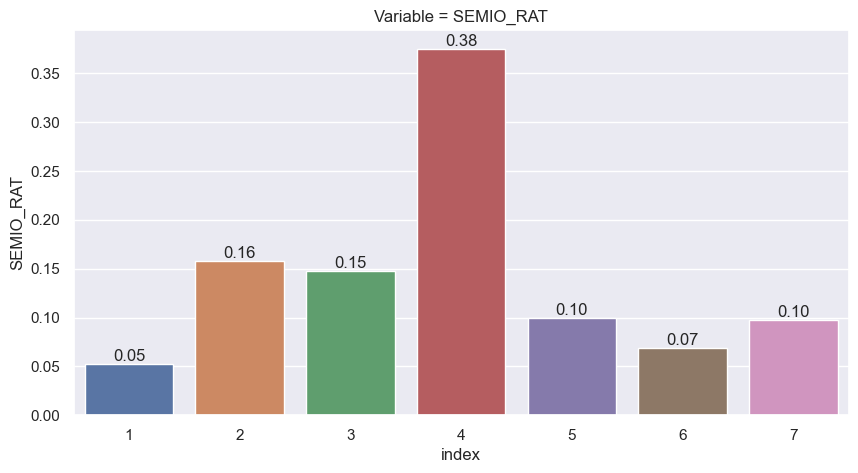

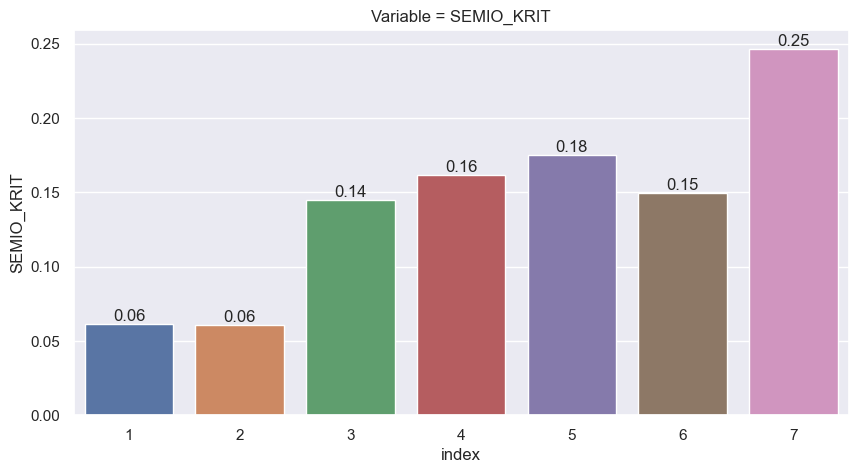

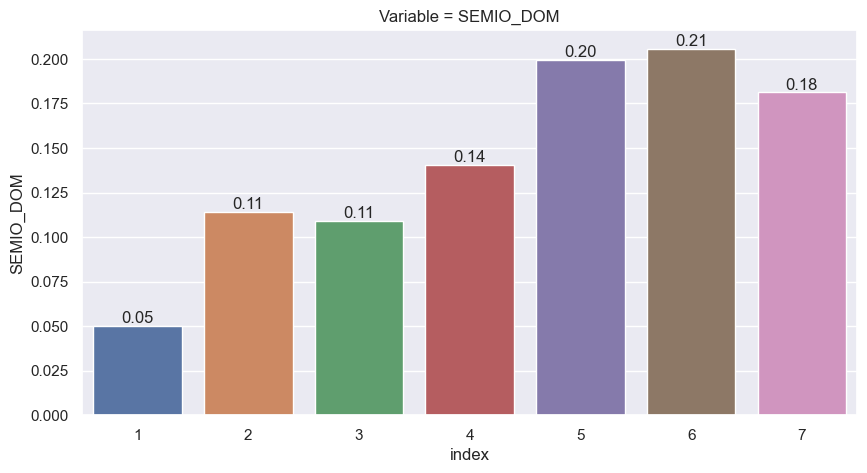

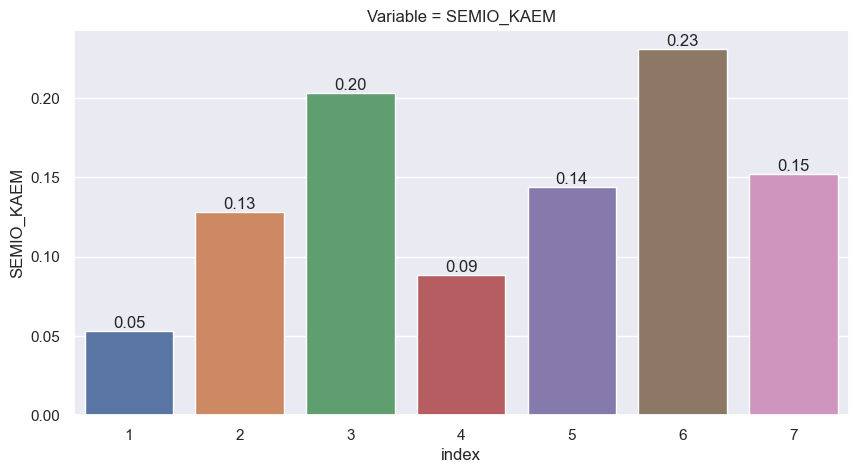

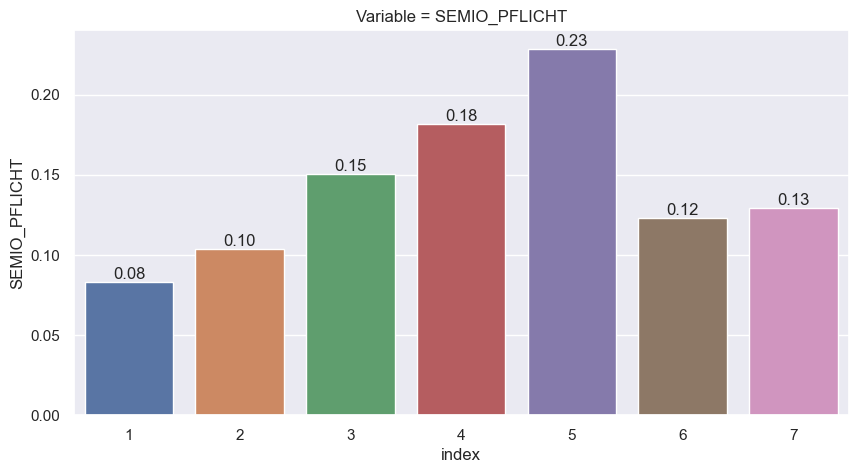

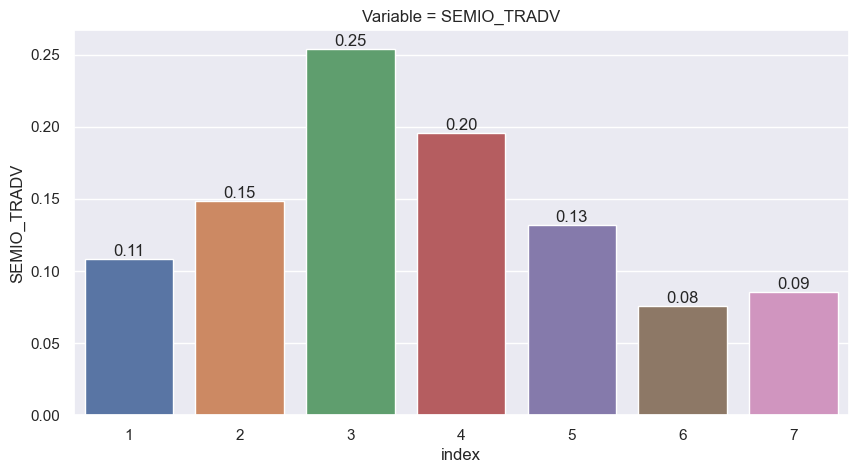

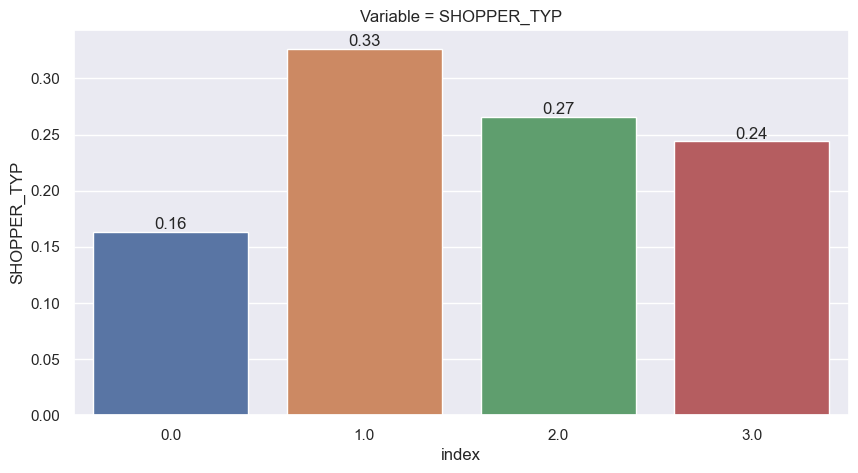

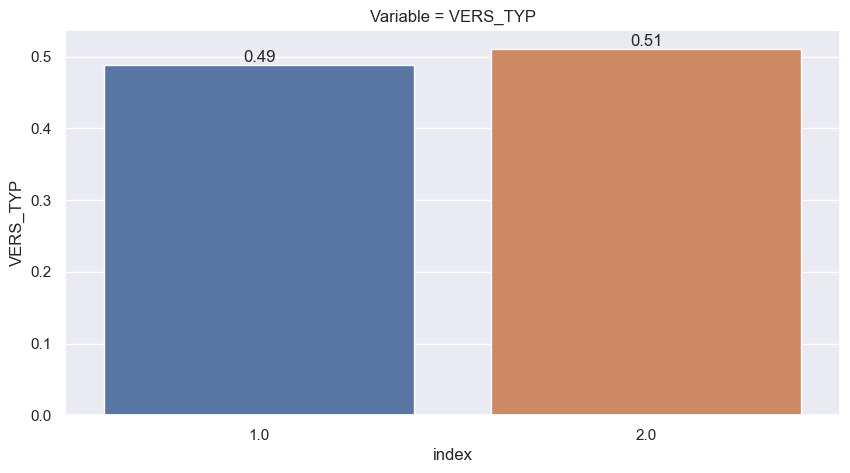

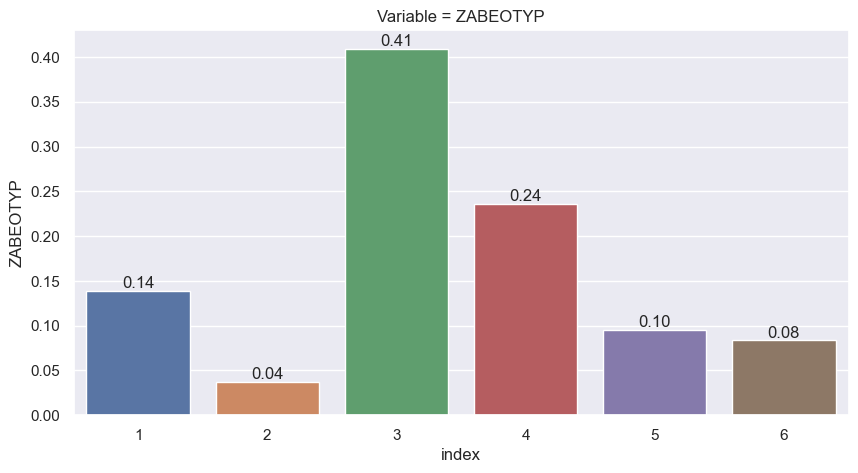

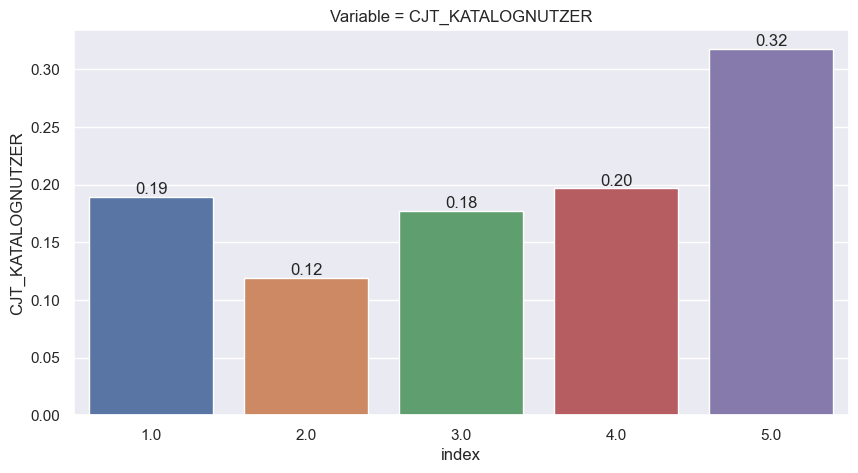

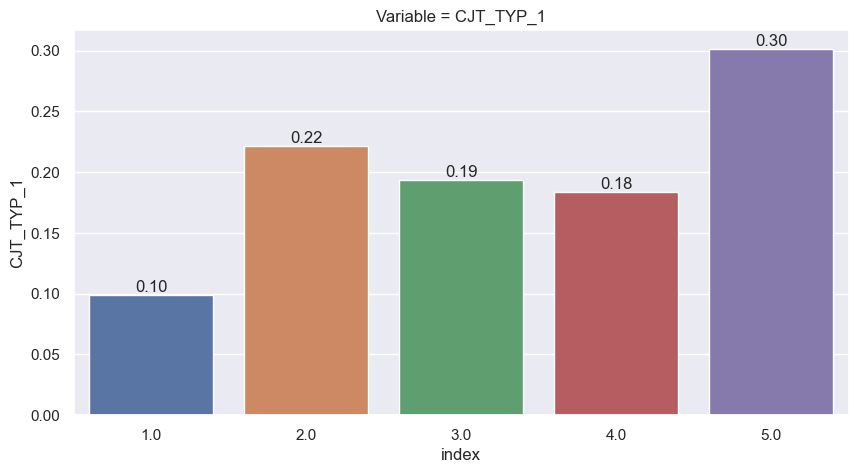

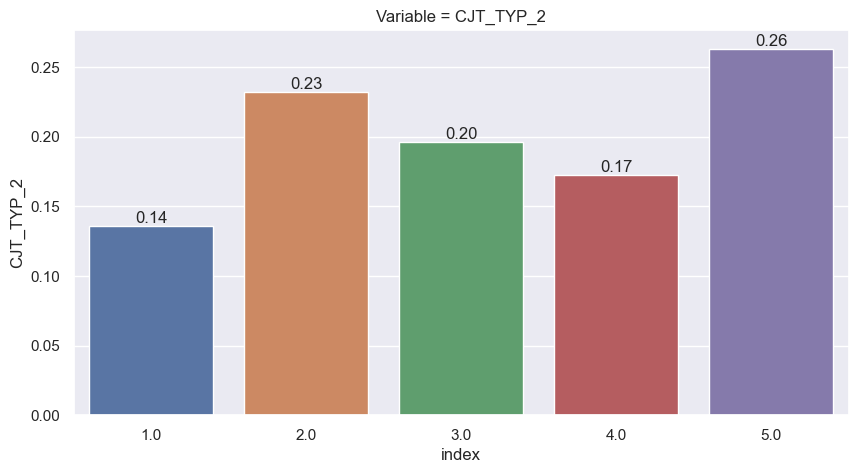

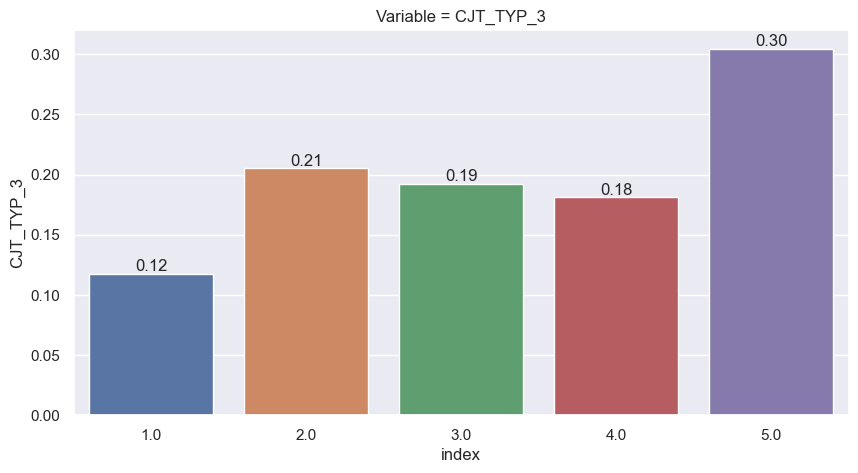

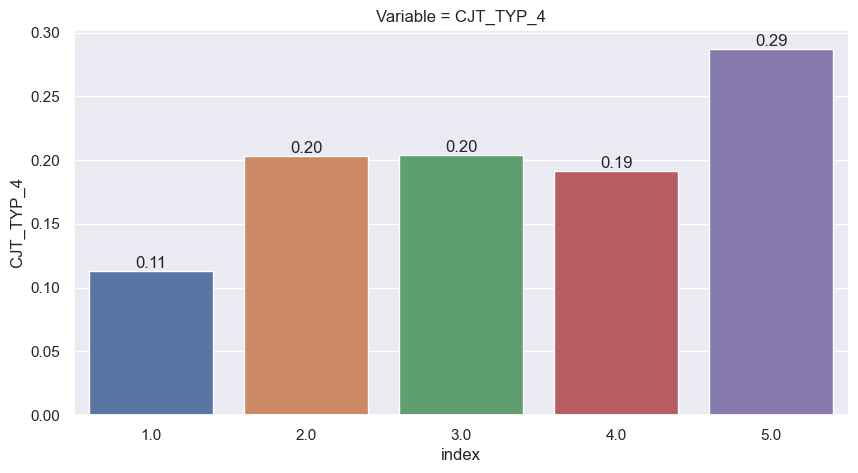

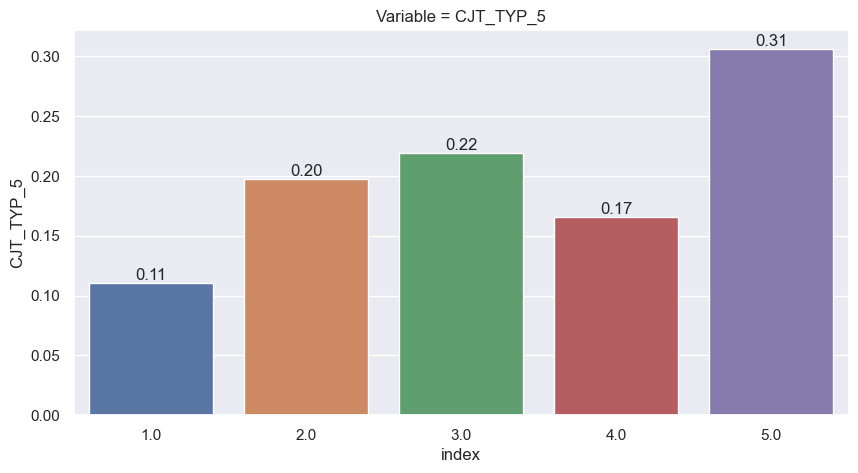

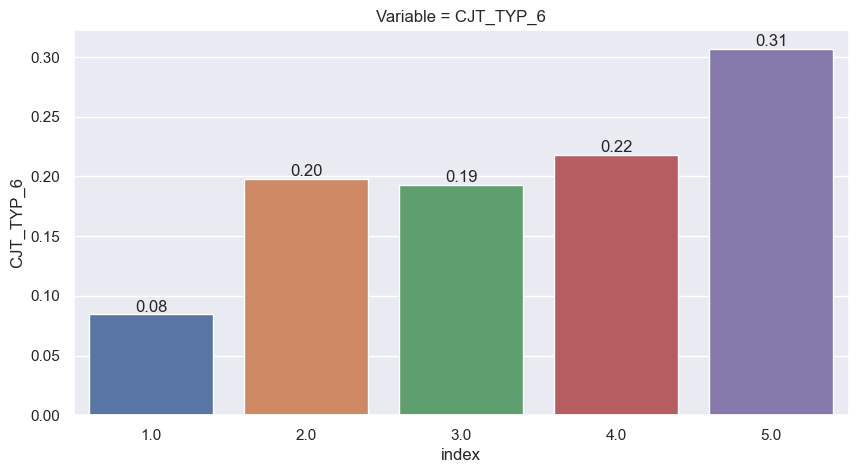

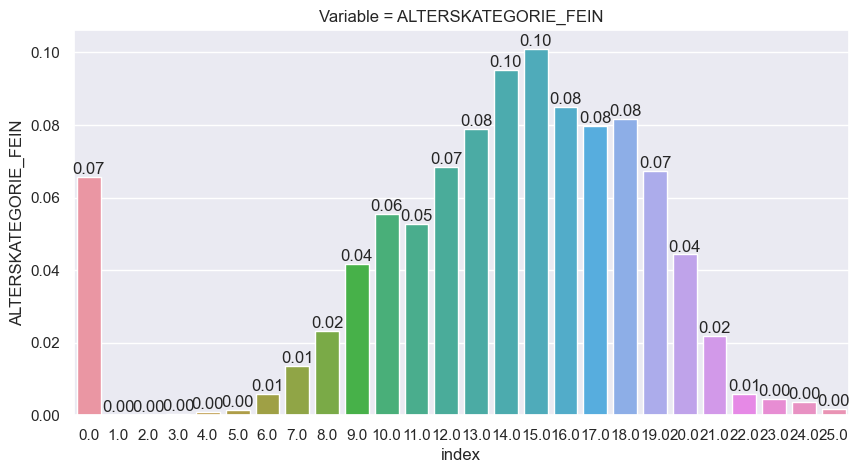

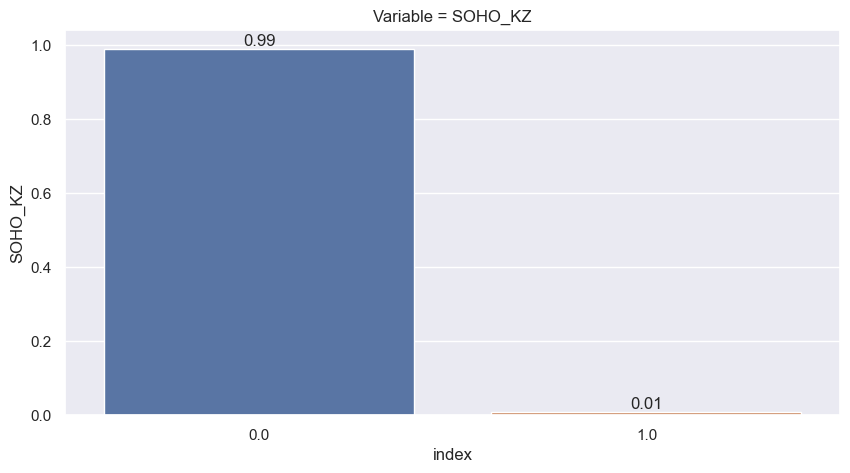

In [184]:
count_val_in_cols(census, person_col_list, plot_count = True, normalize = True)

Maybe Soho should be dropped. It is pretty much dominated by zeroes and does not convey any necessairly important information from a business perspective to the problem.  
"Fein" variables may convey similar information to their "Grob" (more aggregated) counterparts. They might be dropped given redundancy of information.

## PLZ8

### PLZ8 cols

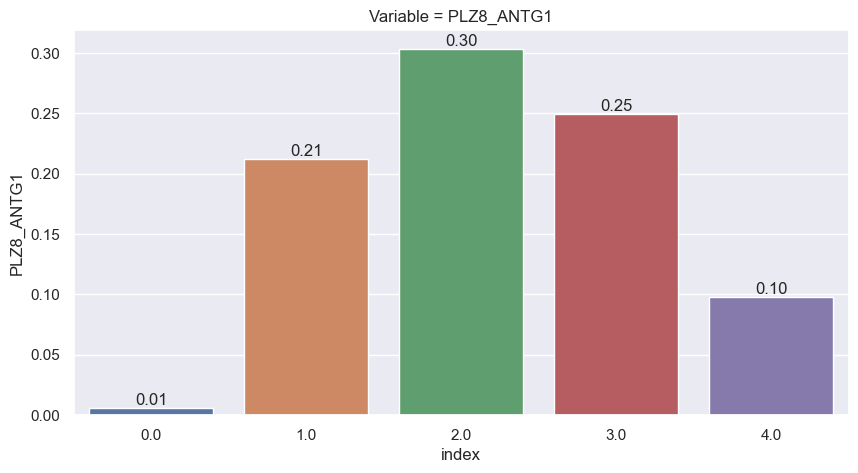

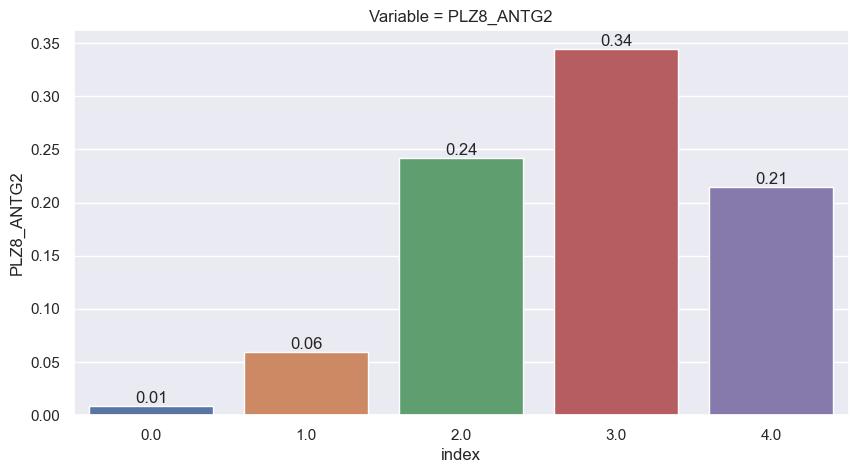

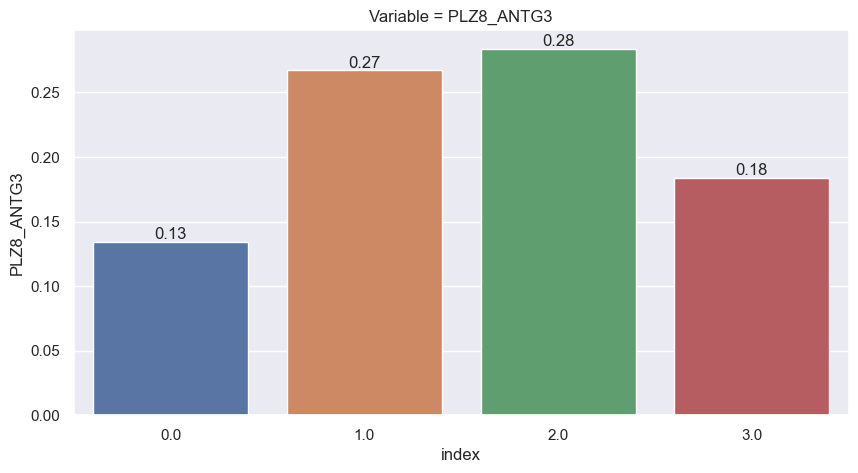

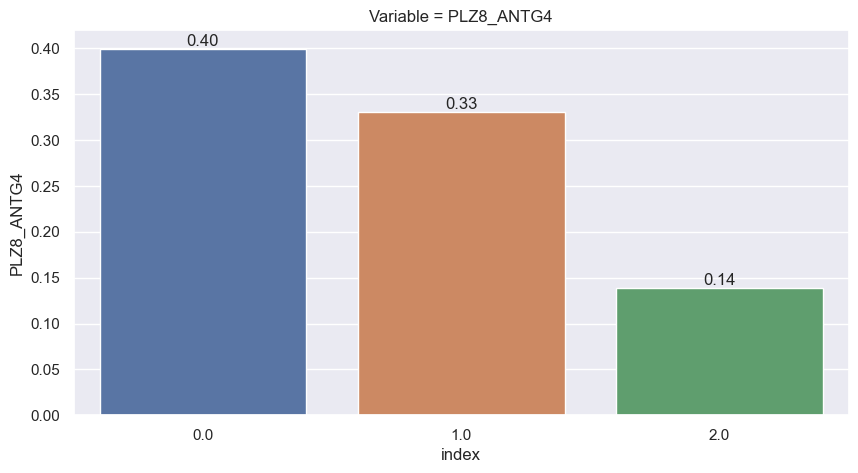

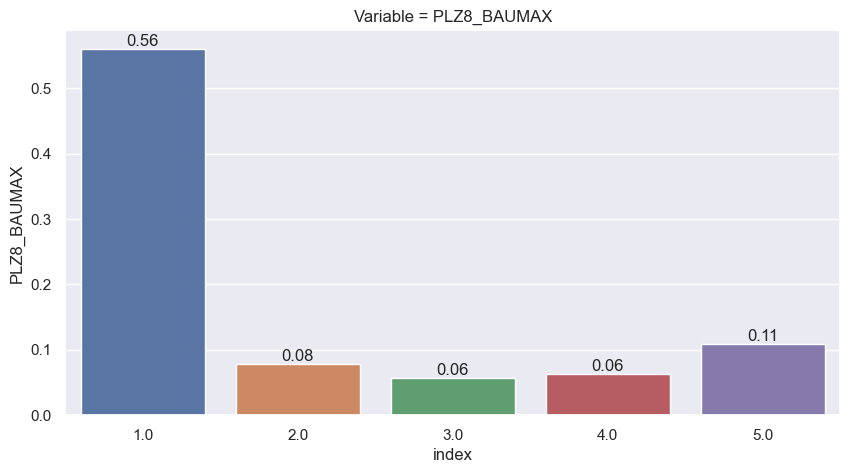

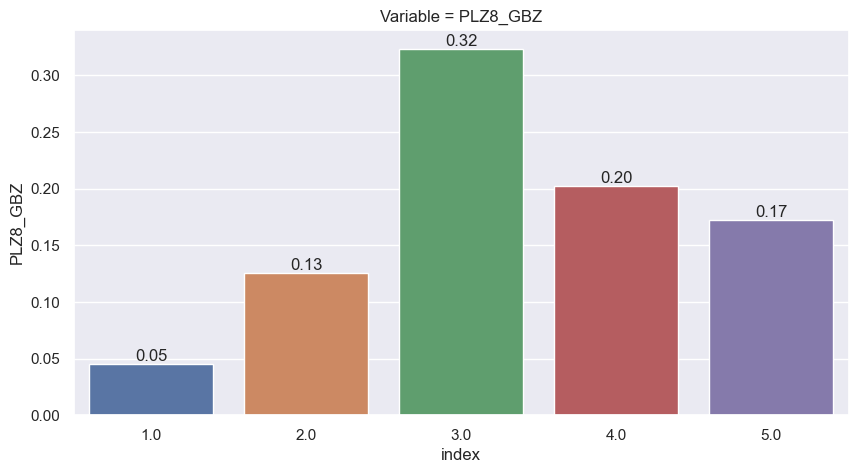

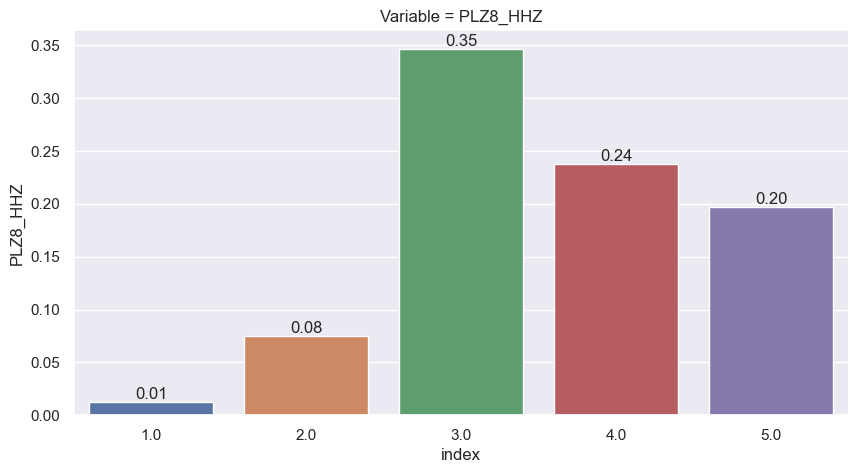

In [190]:
count_val_in_cols(census, sorted([col for col in plz8_col_list if col.startswith('PLZ')]), plot_count = True, normalize = True, dropna = False)

### KBA13

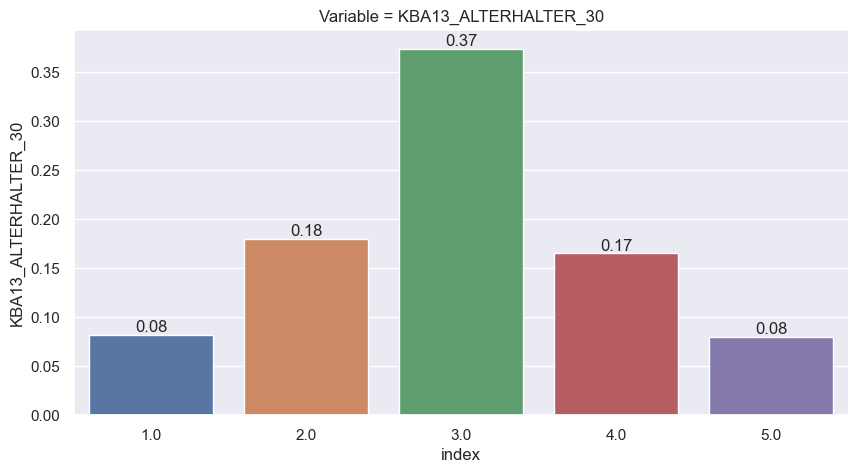

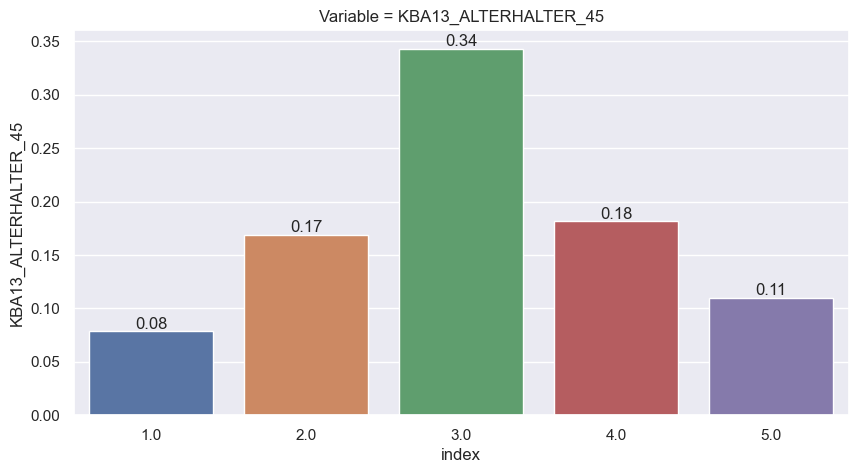

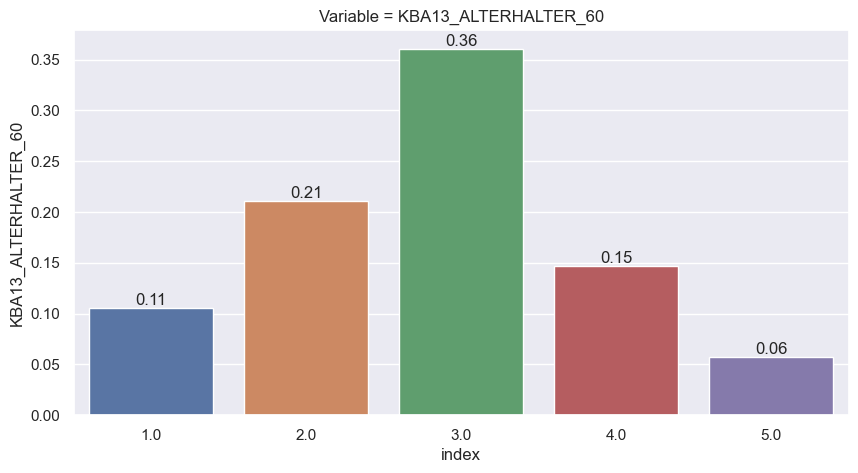

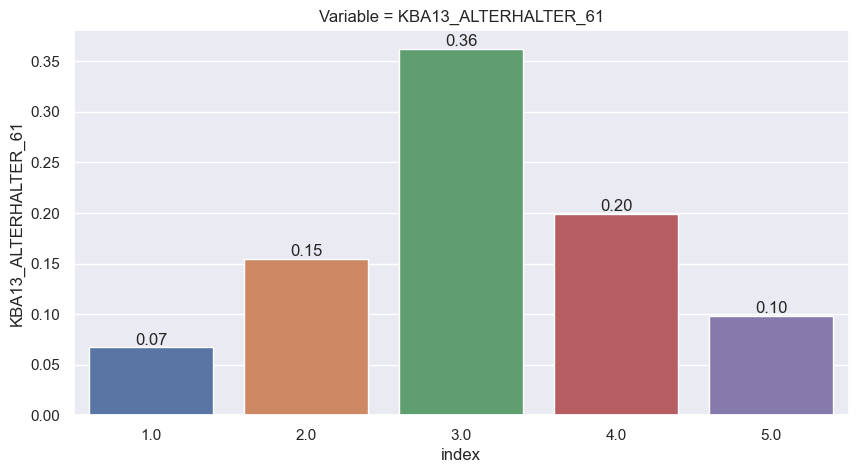

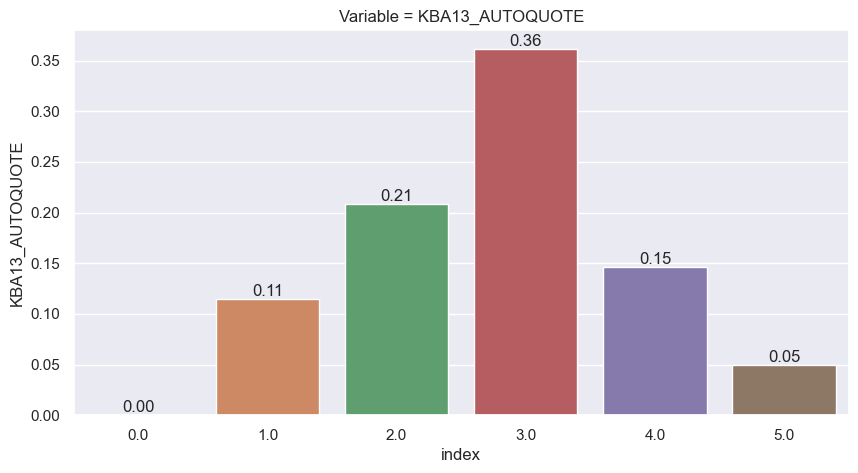

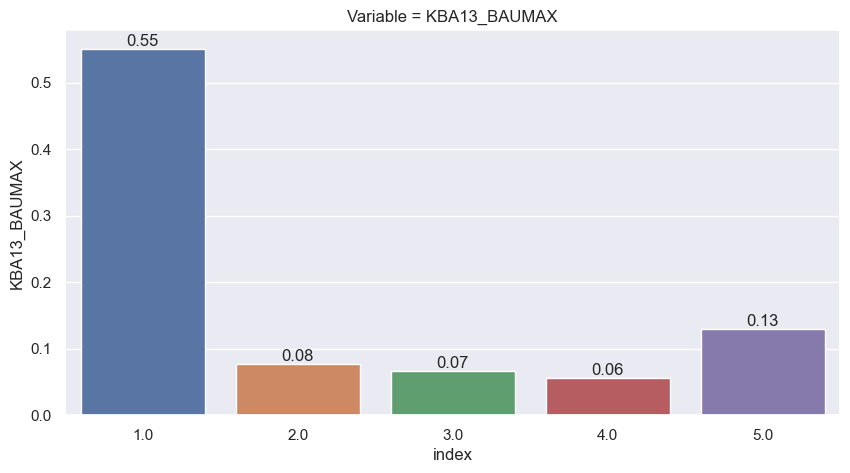

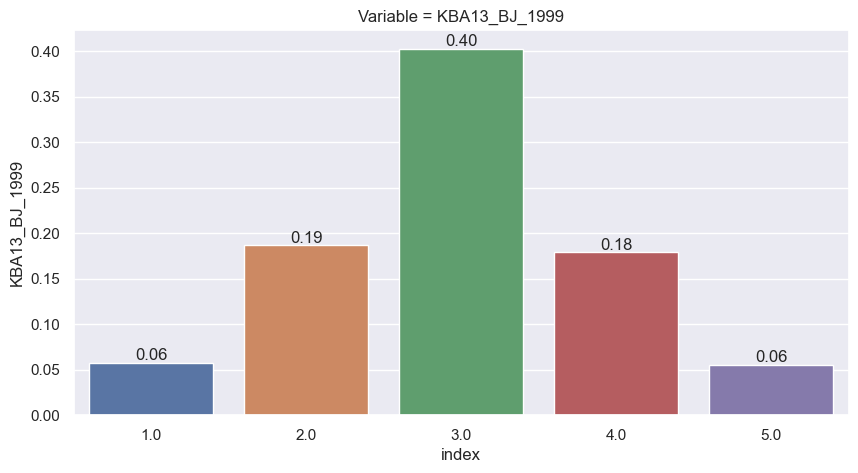

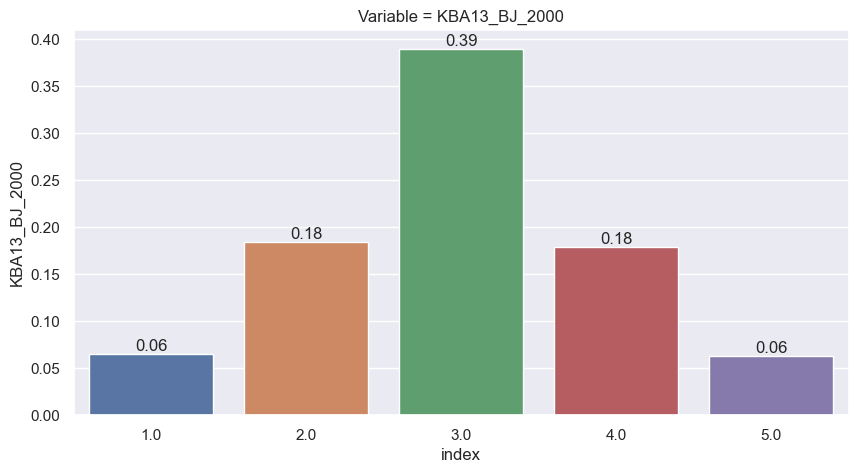

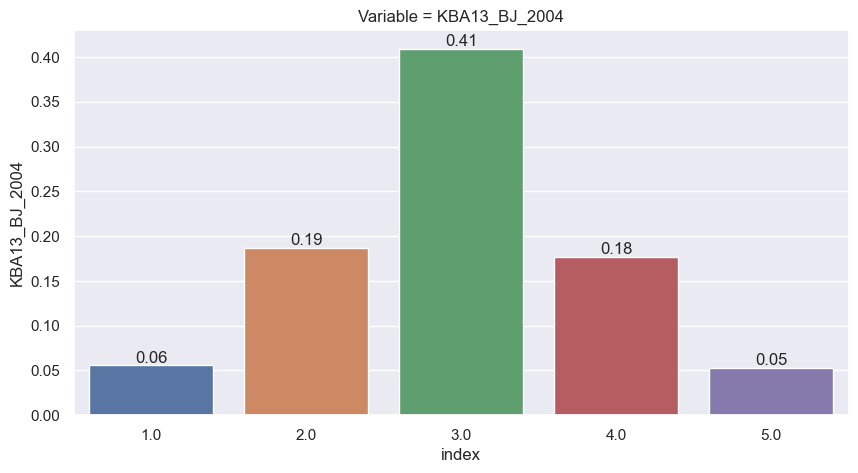

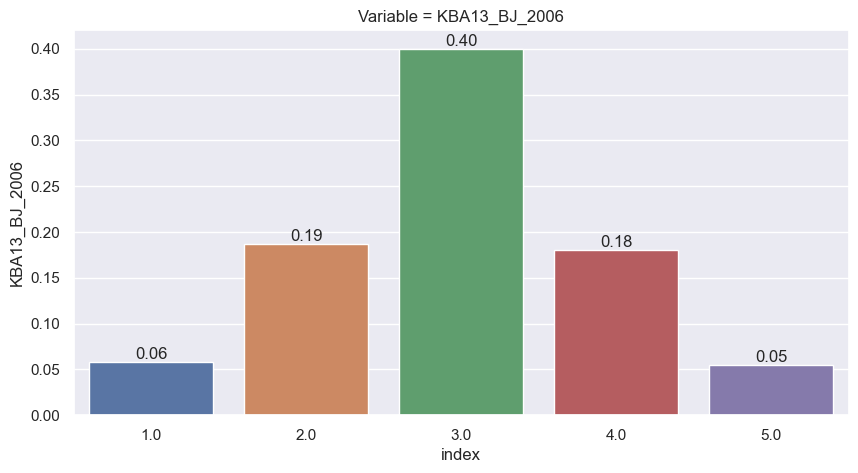

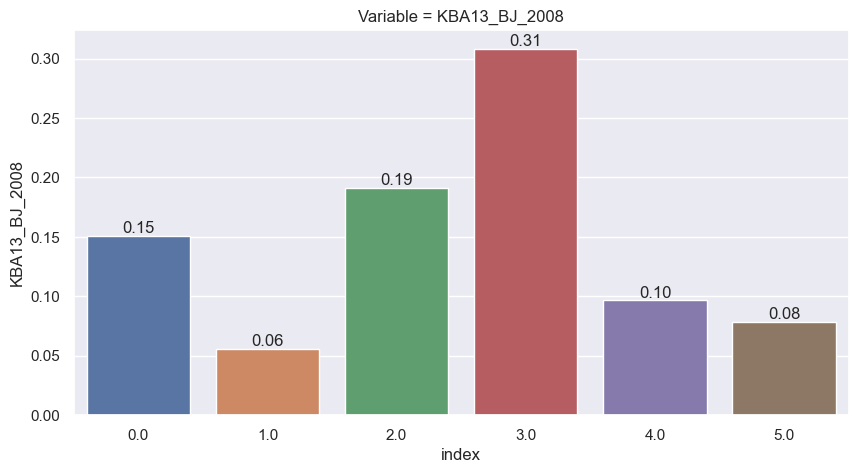

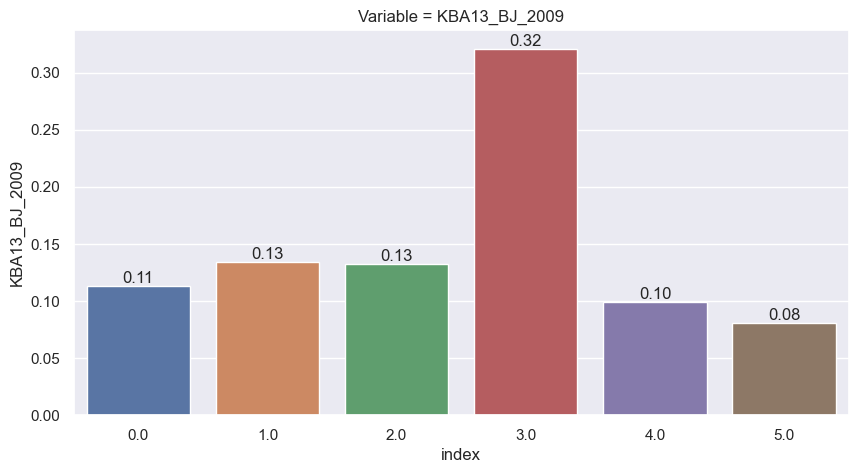

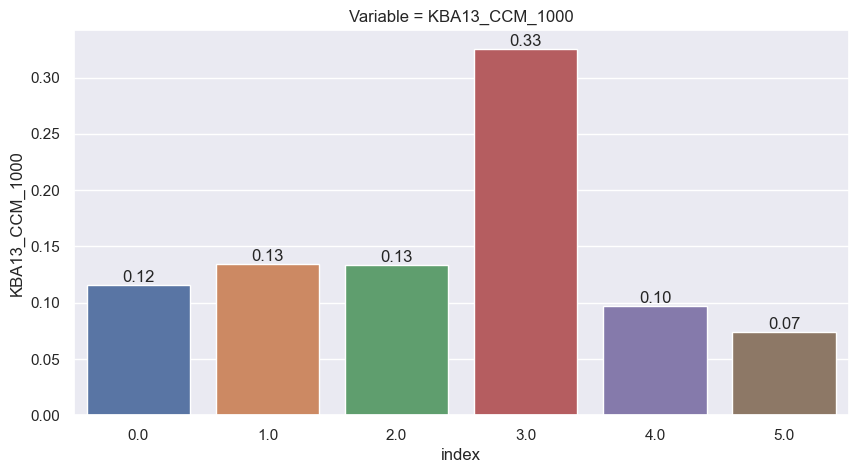

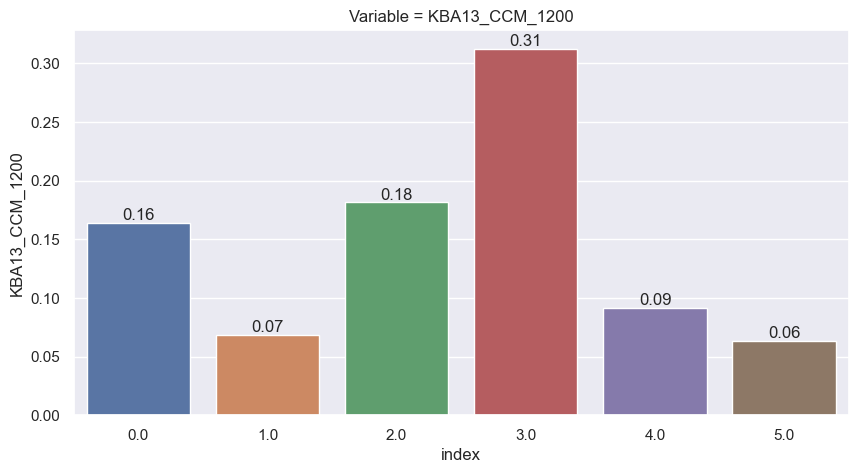

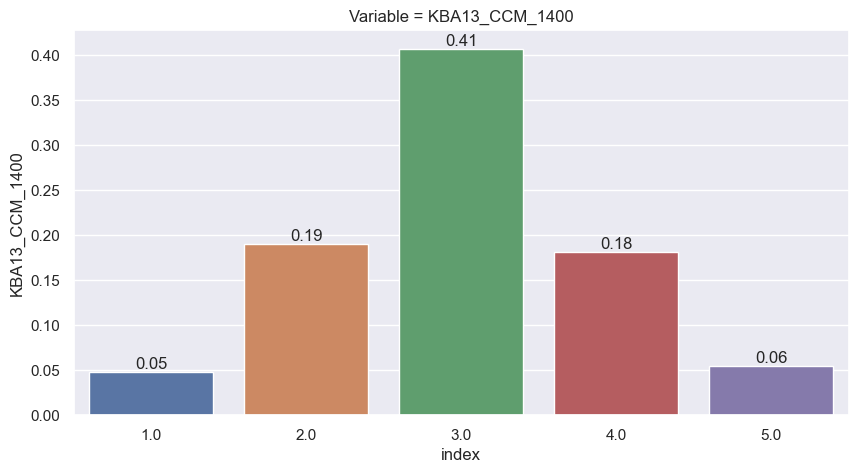

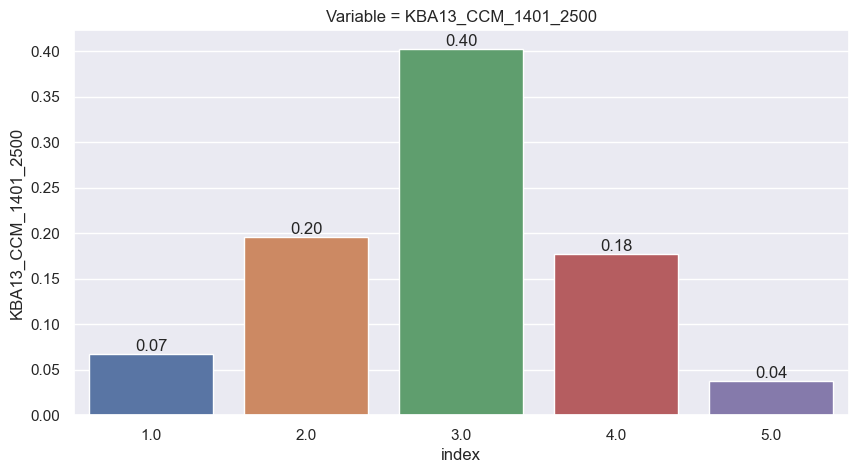

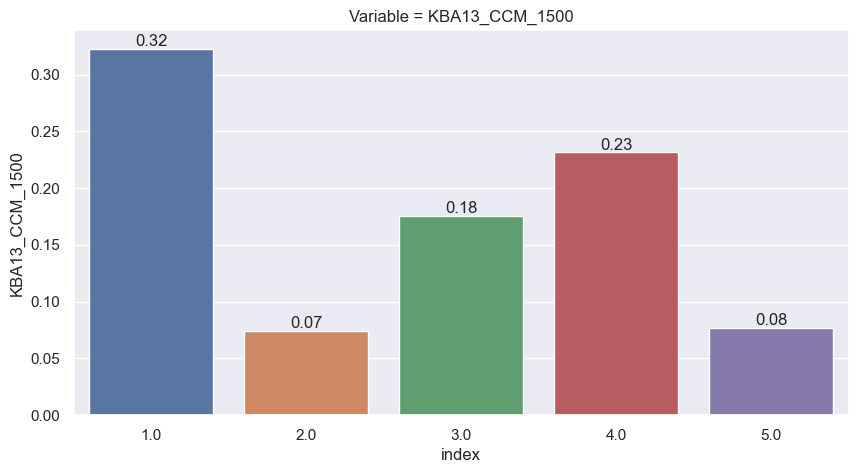

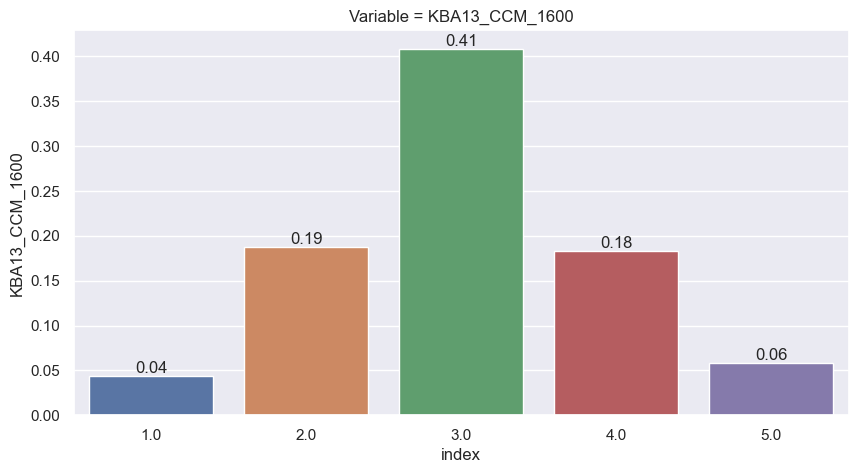

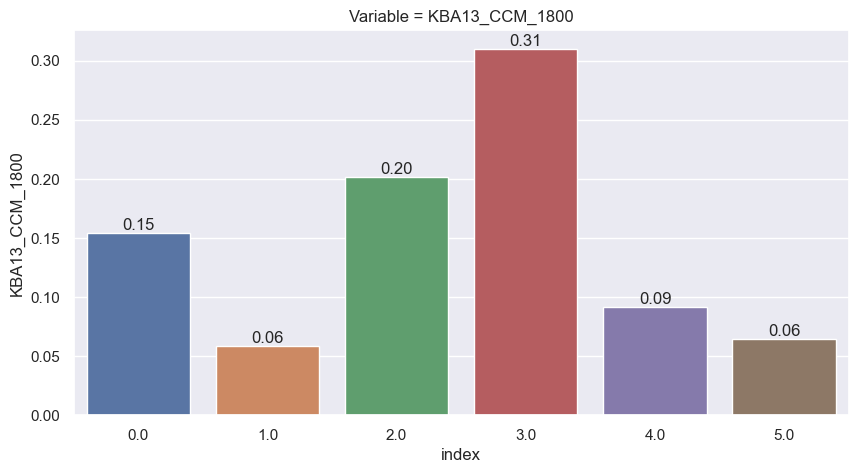

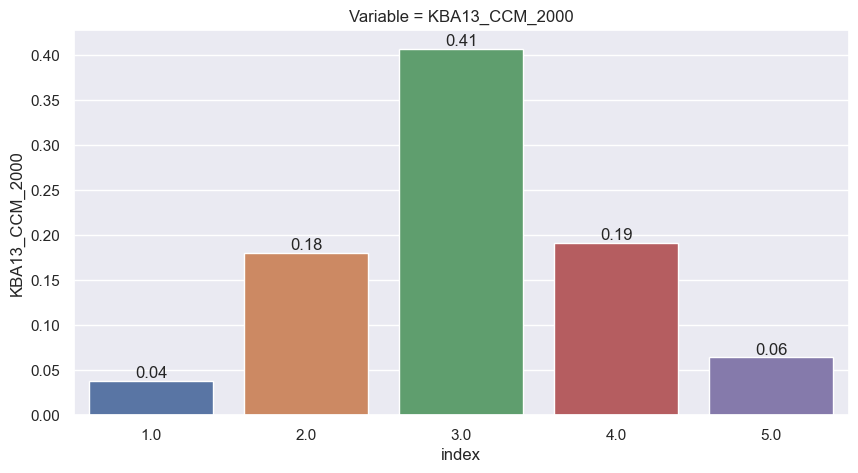

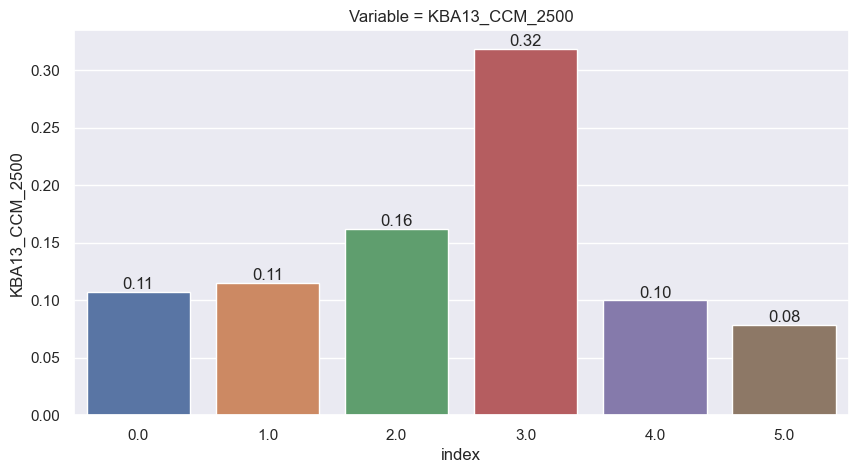

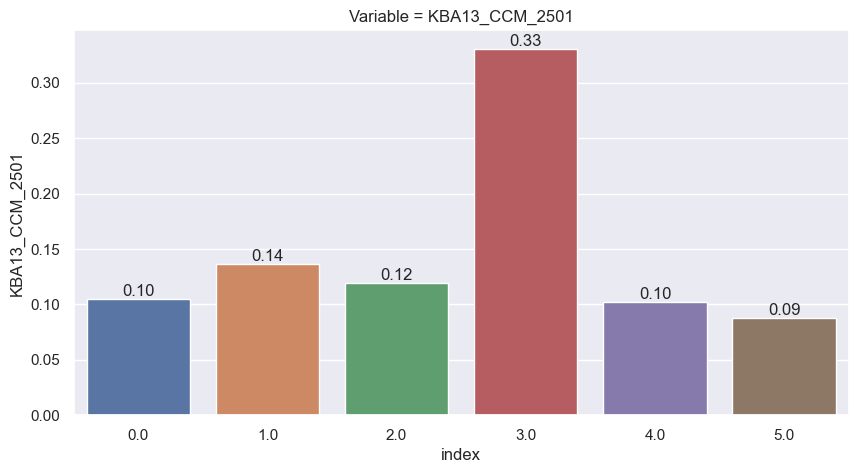

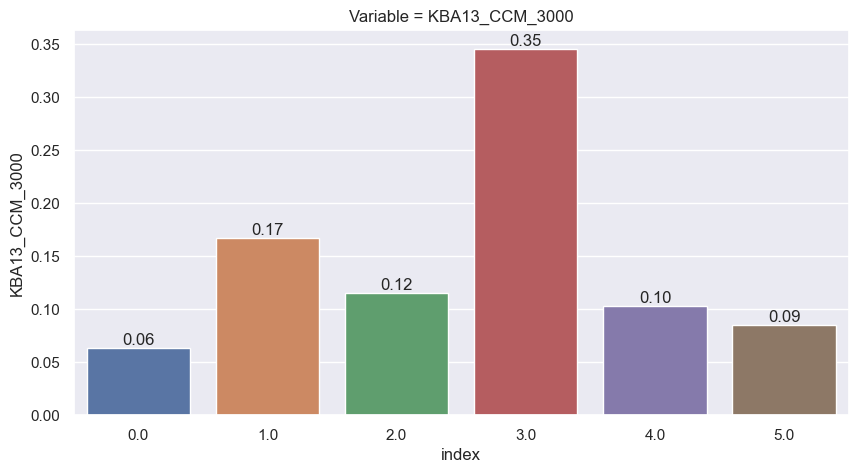

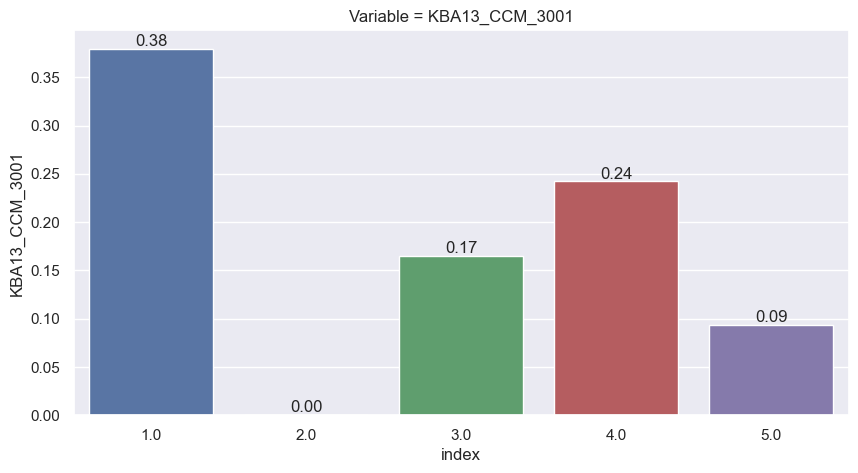

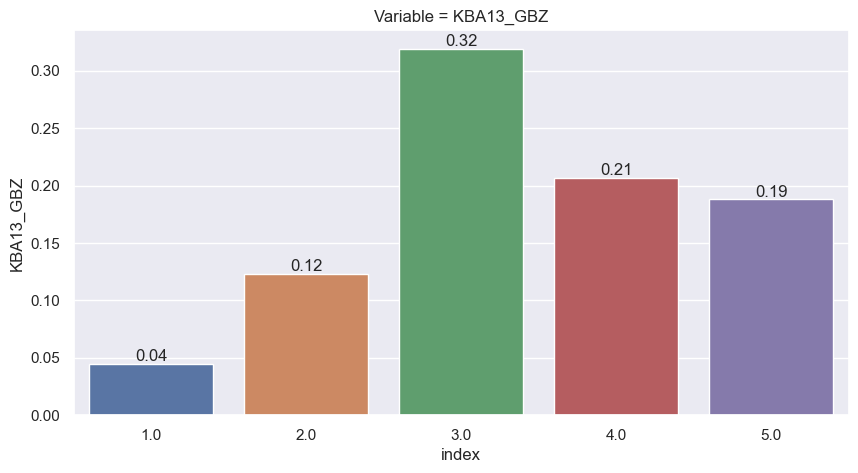

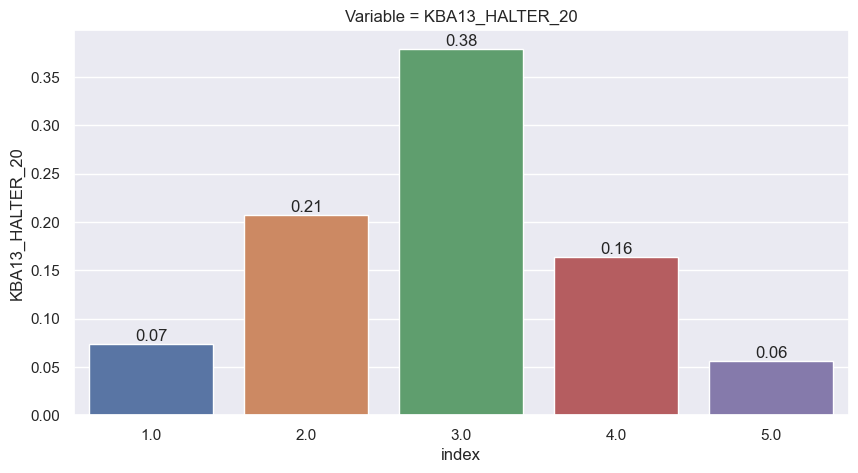

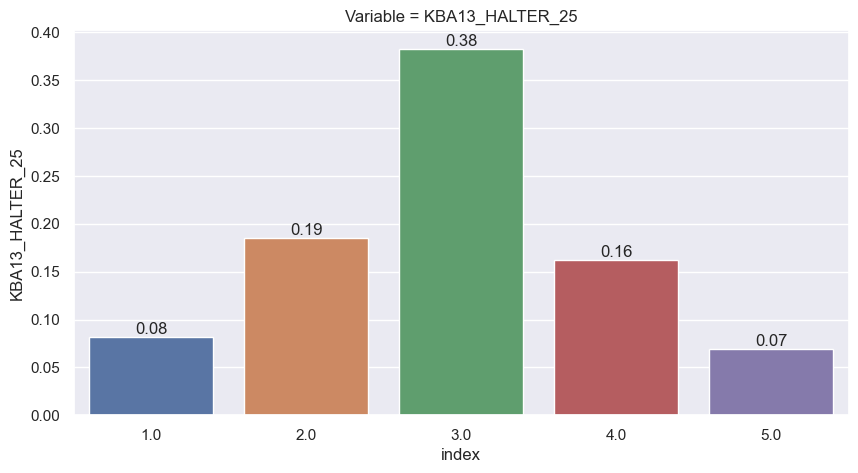

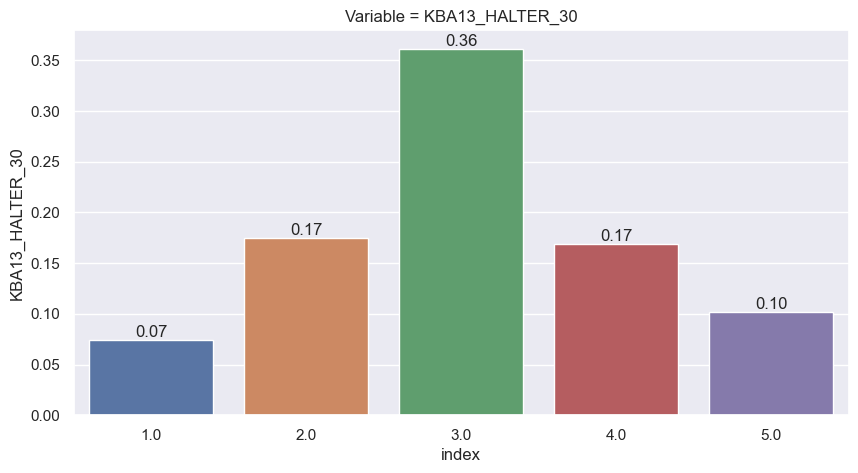

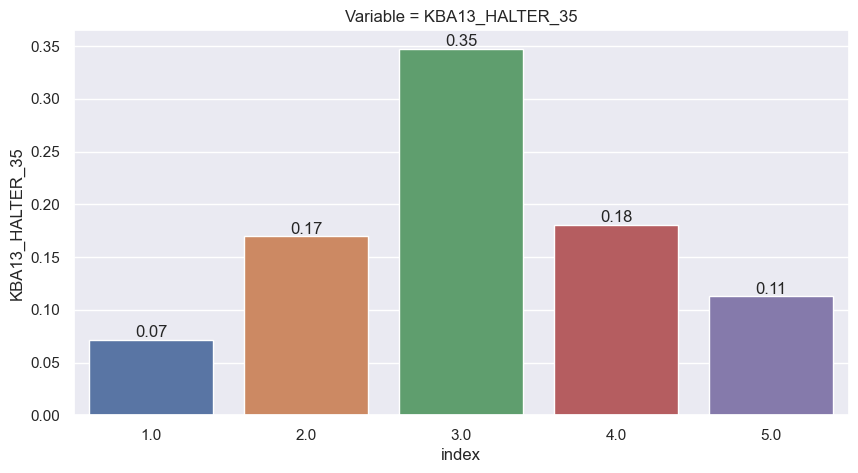

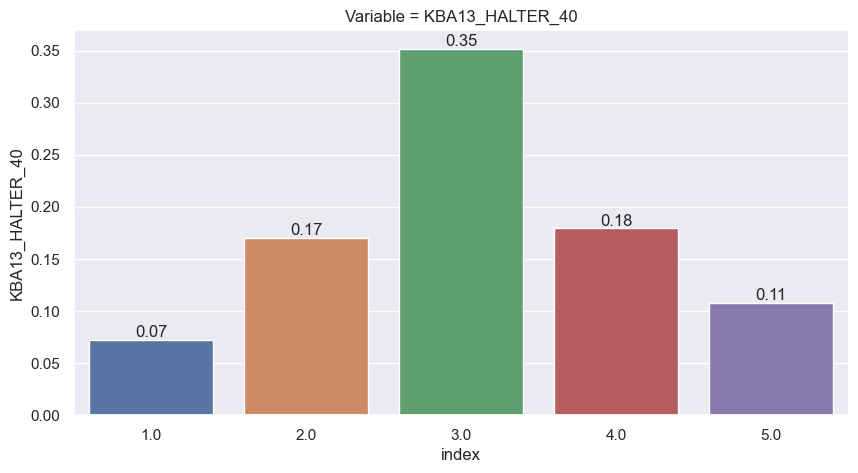

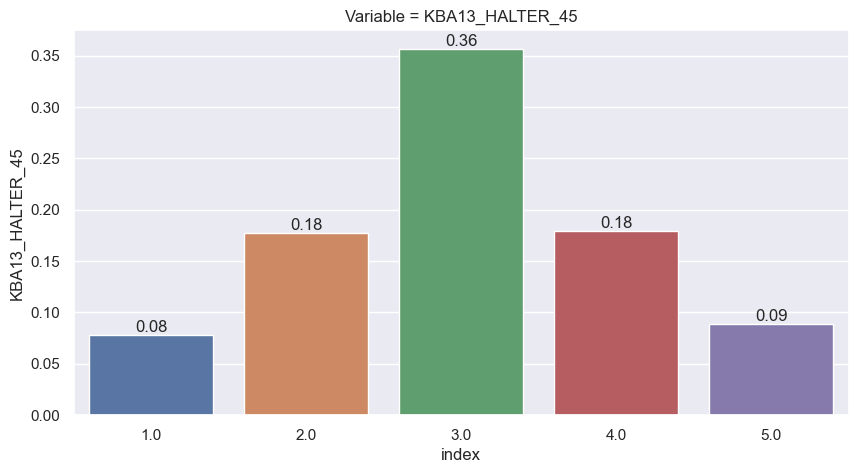

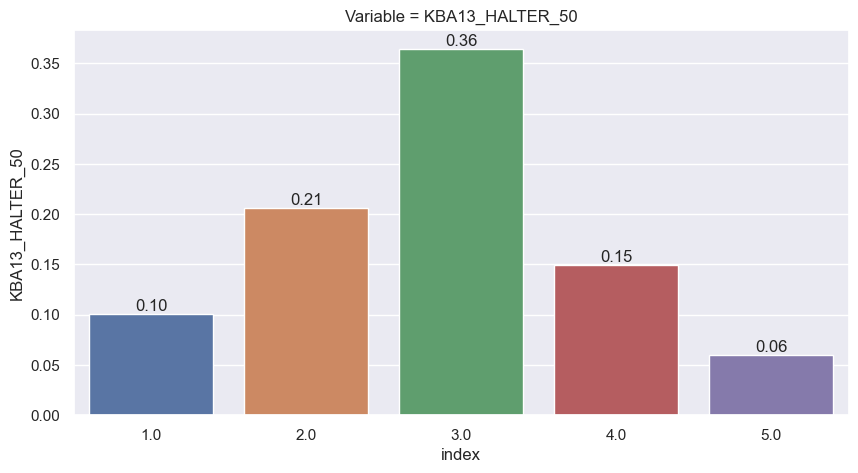

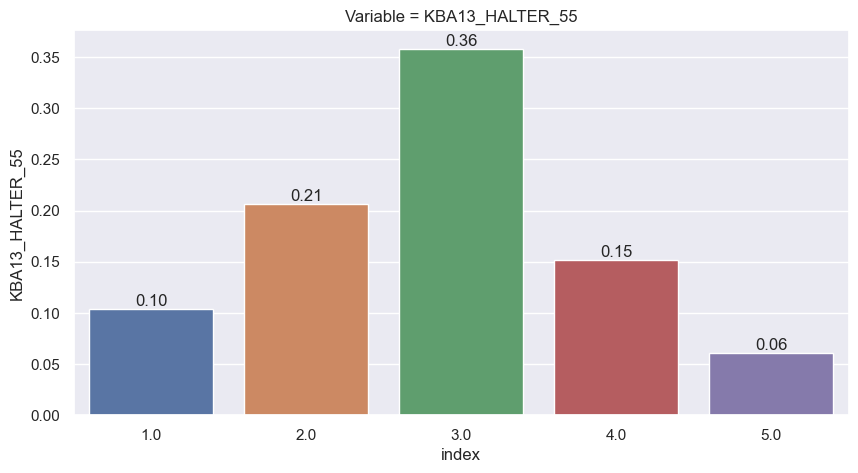

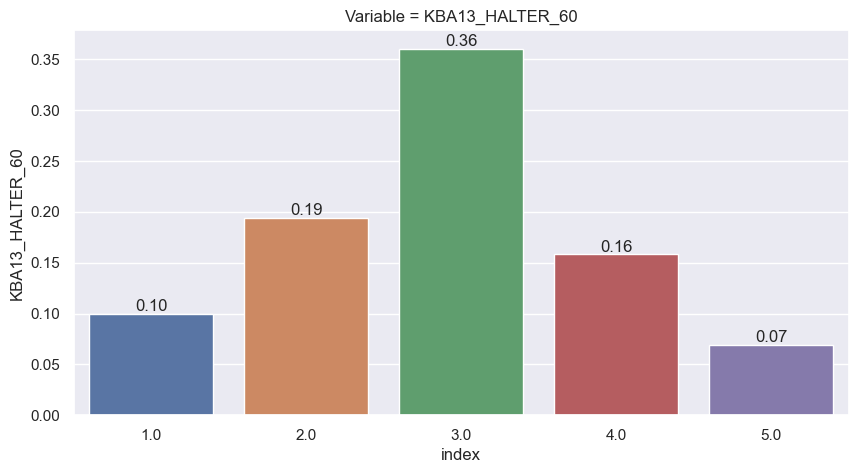

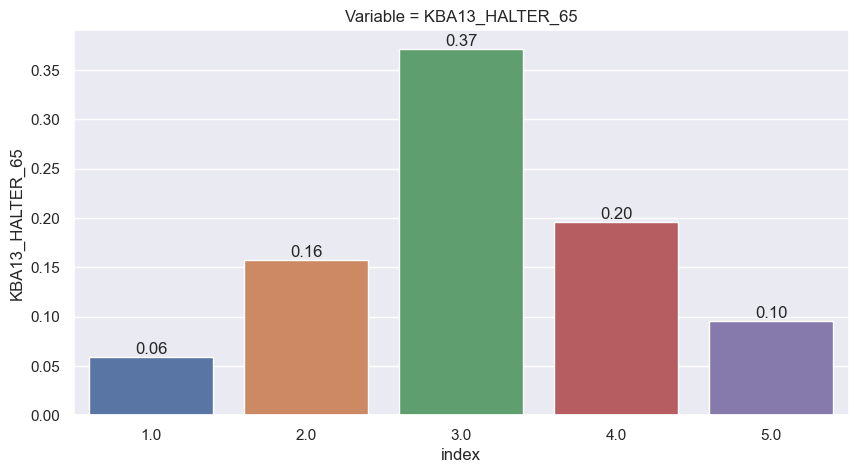

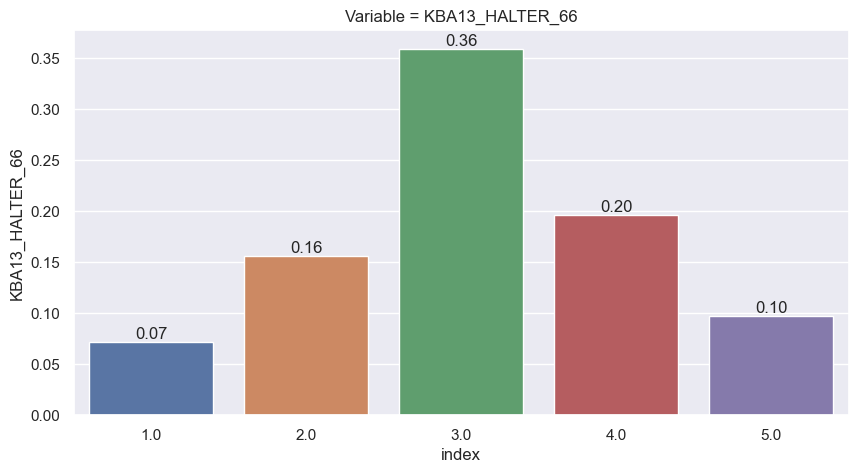

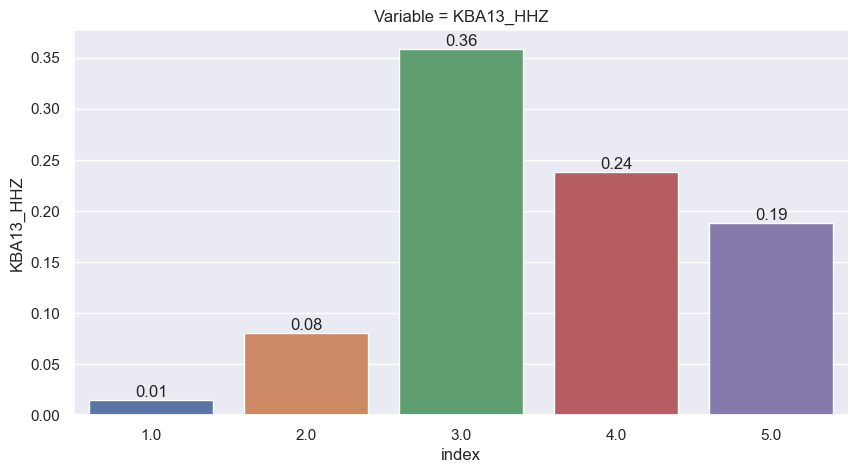

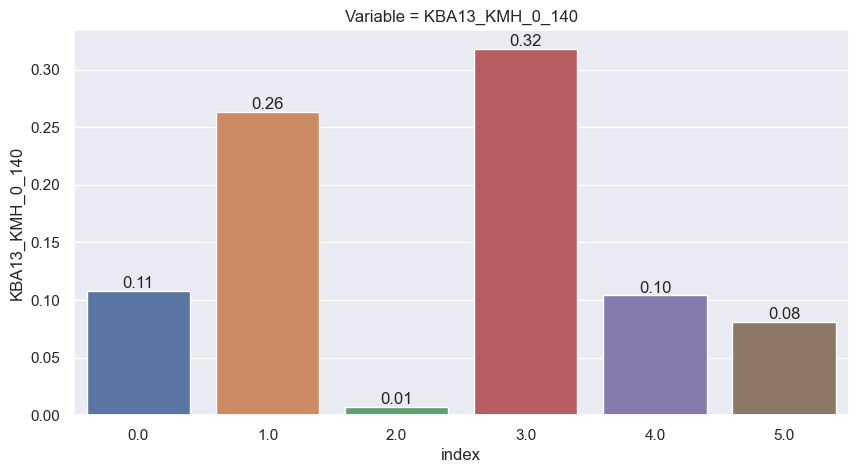

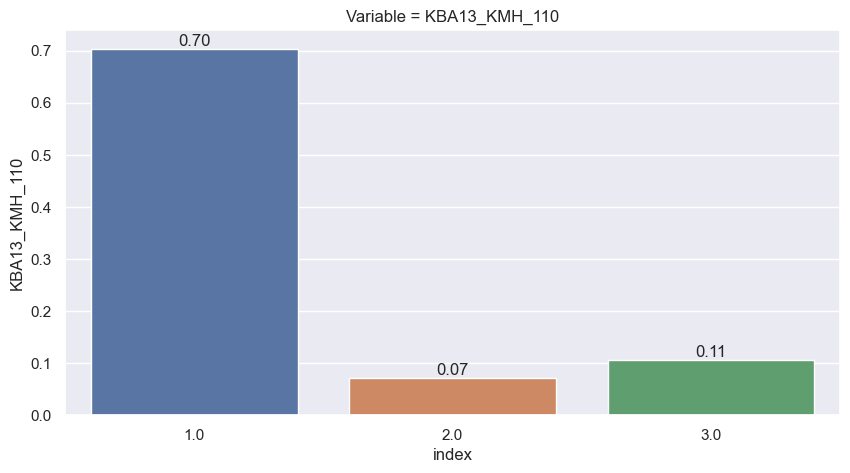

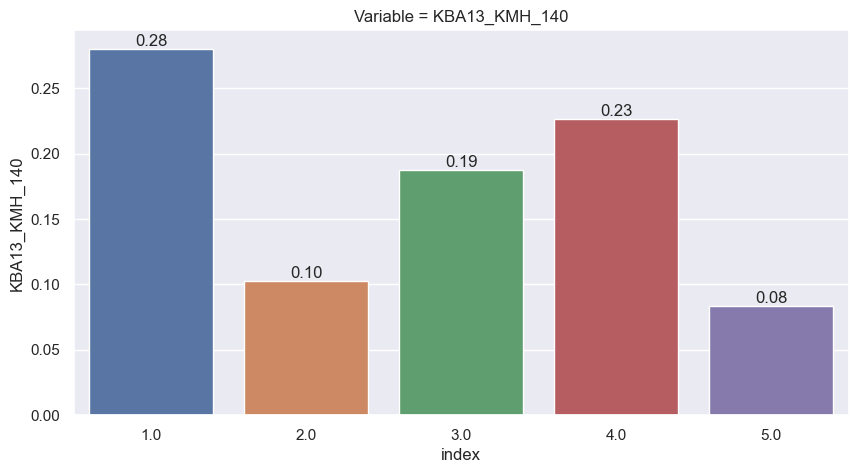

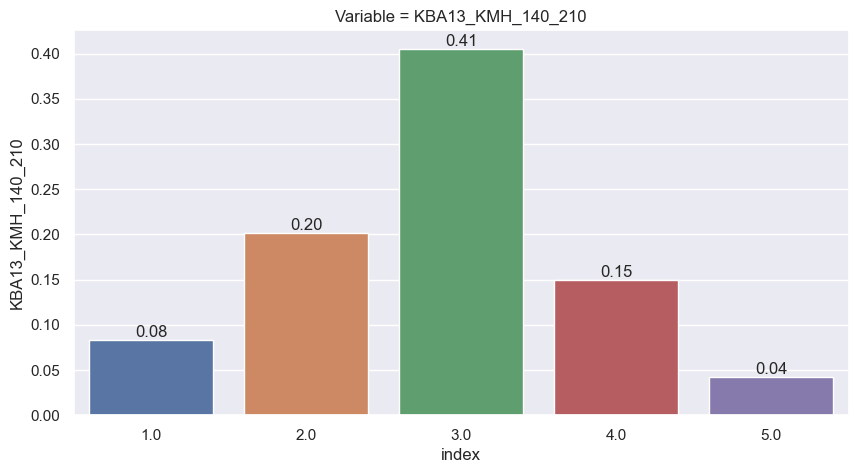

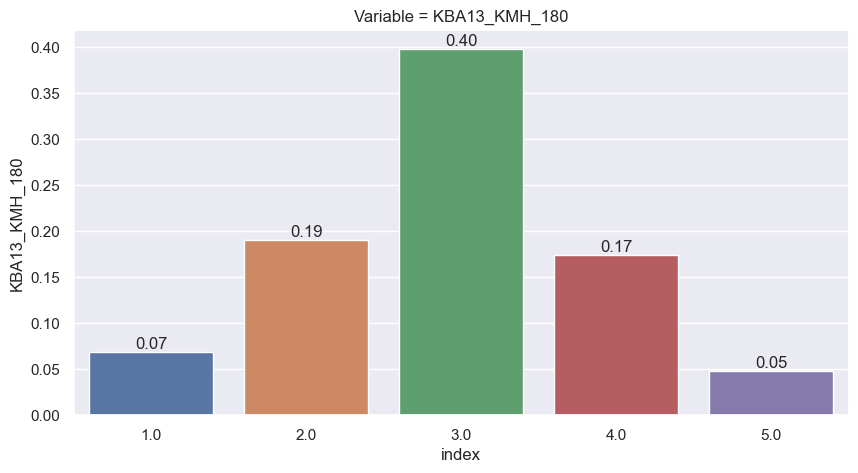

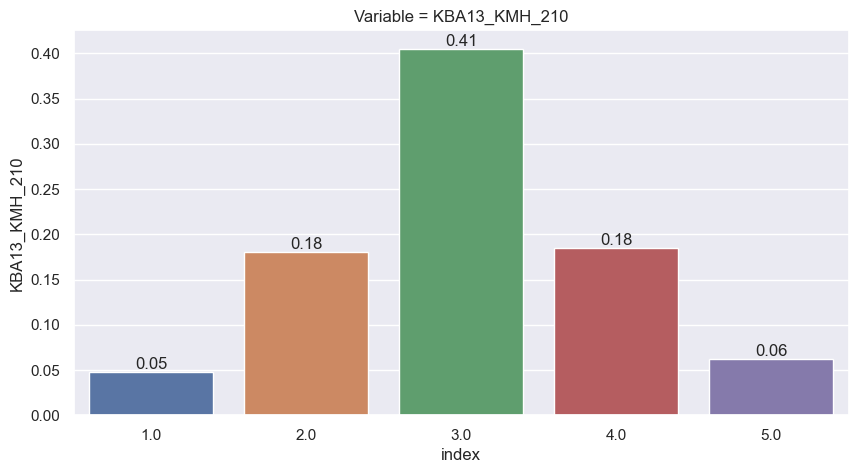

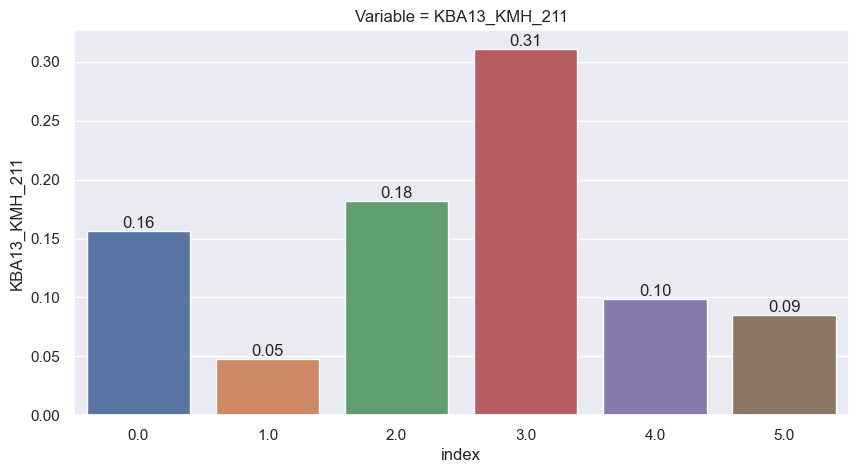

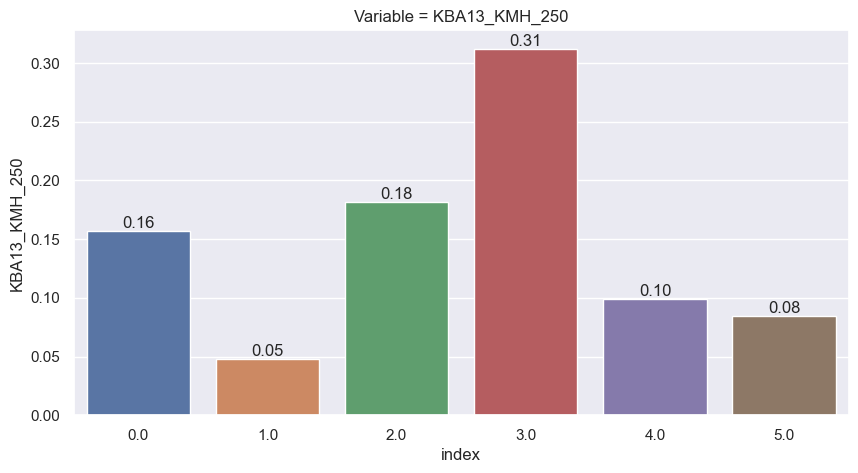

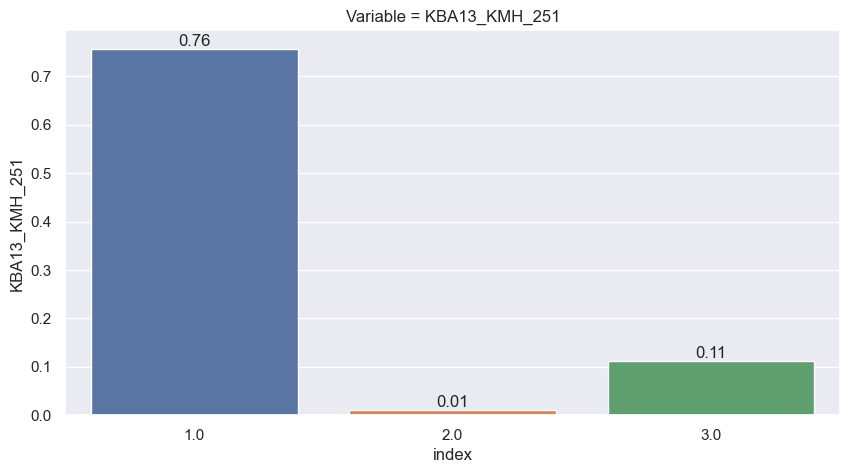

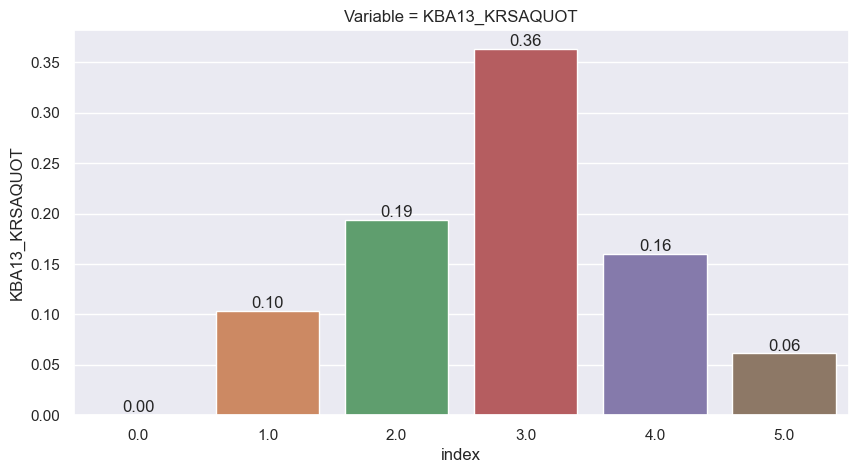

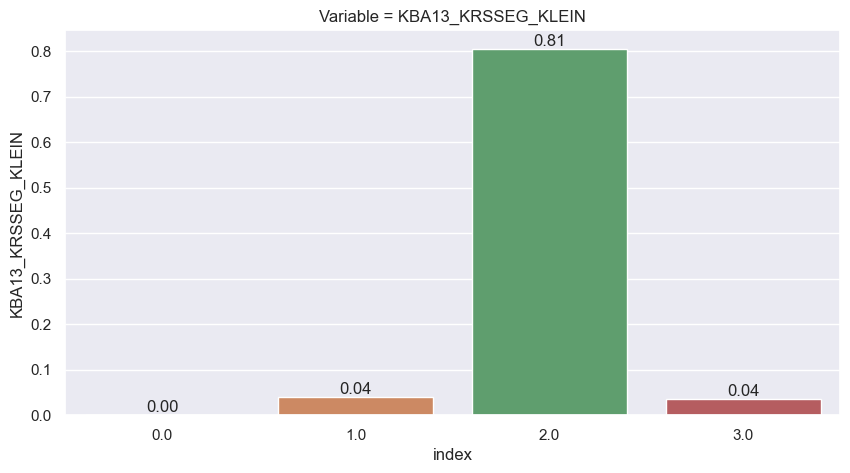

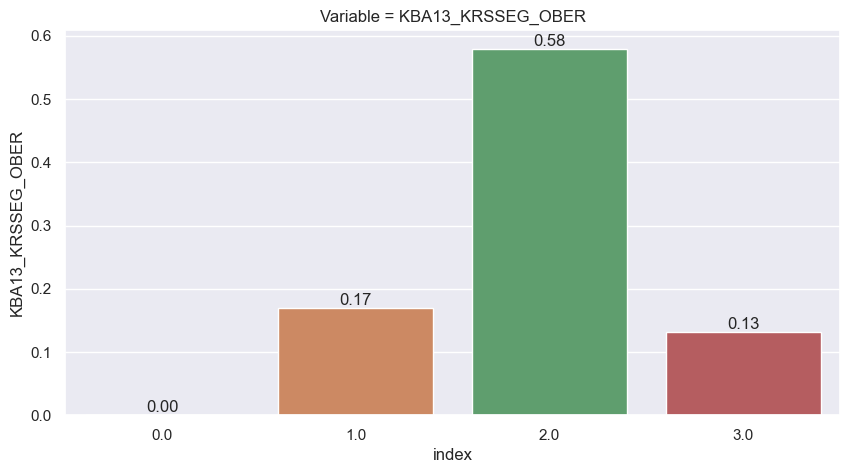

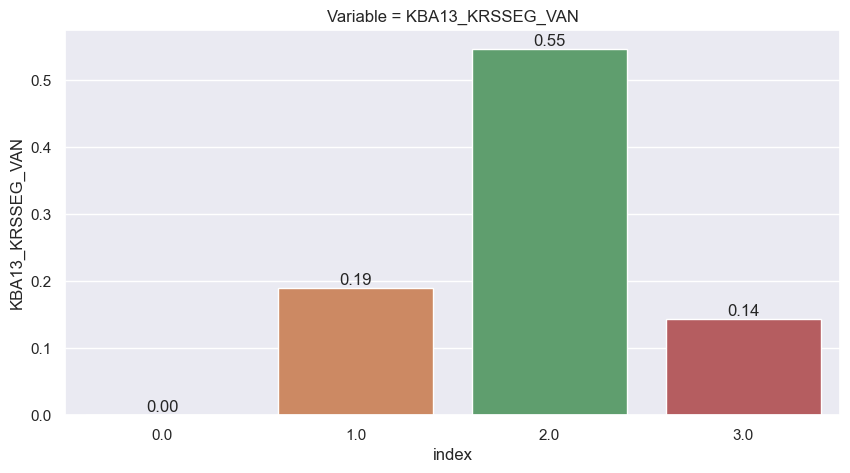

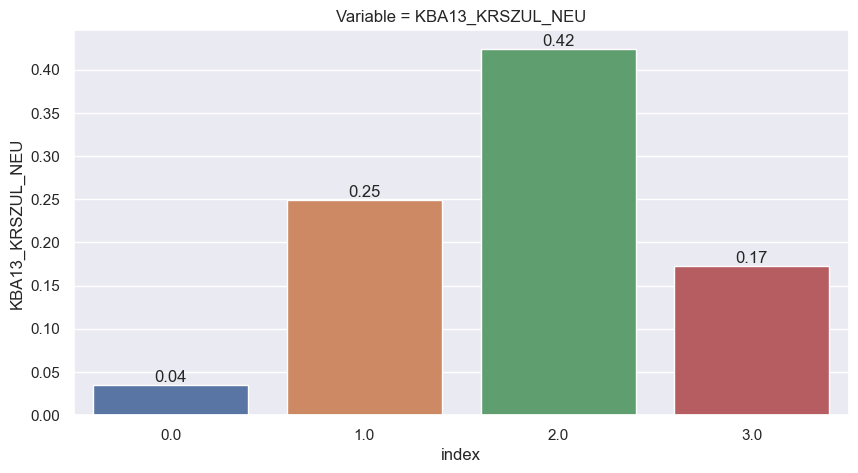

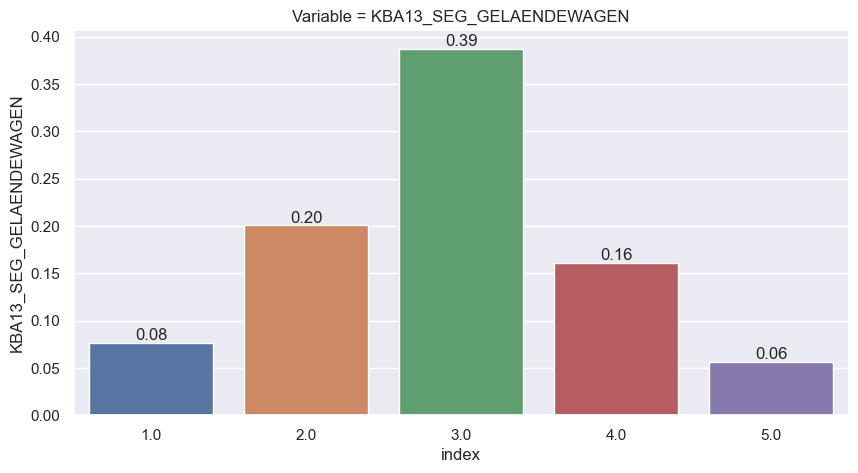

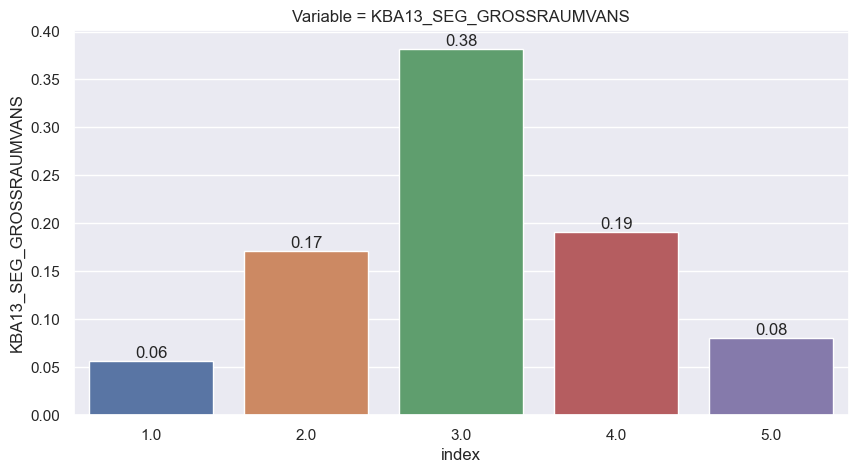

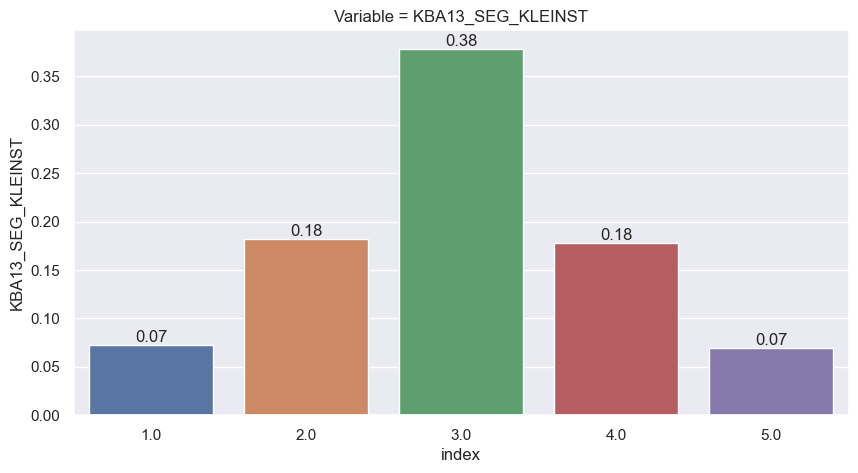

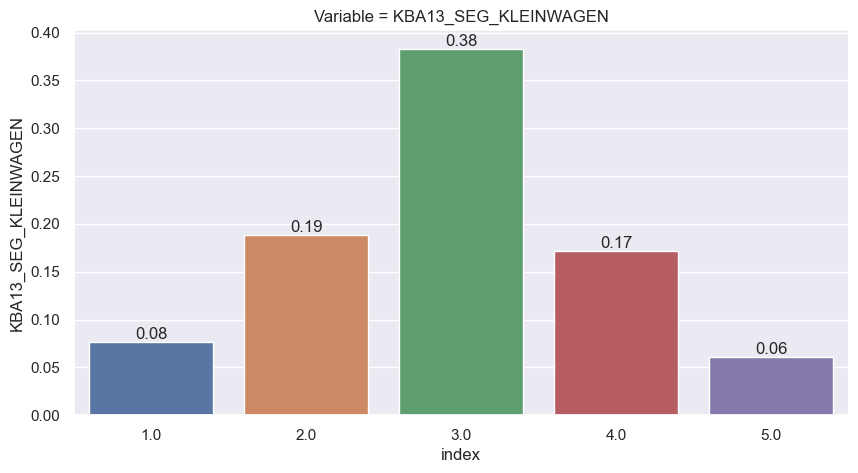

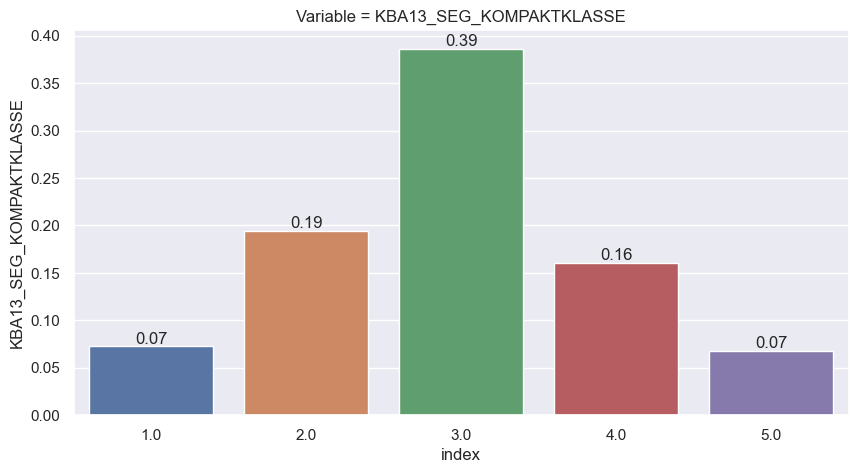

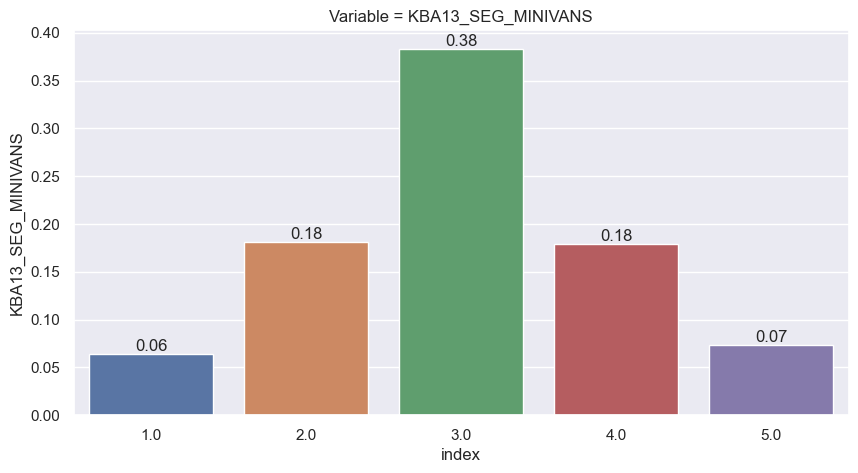

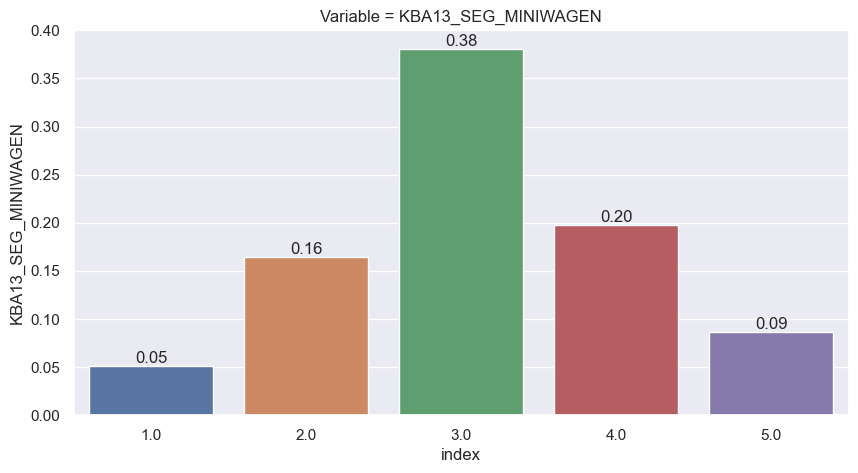

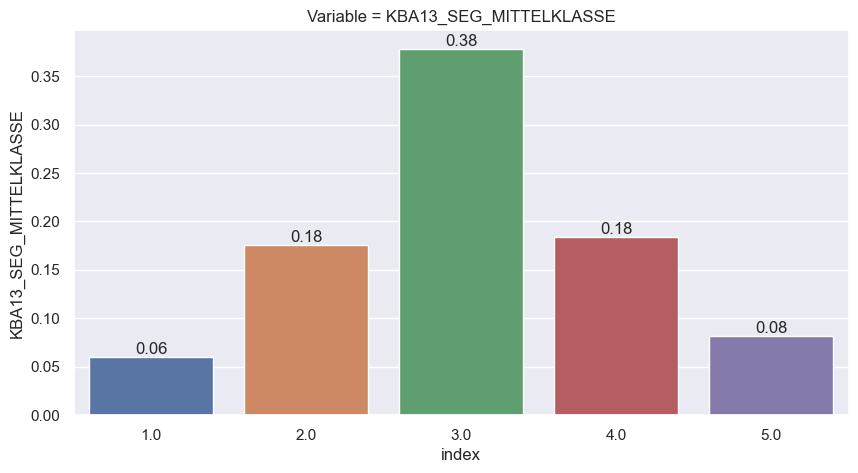

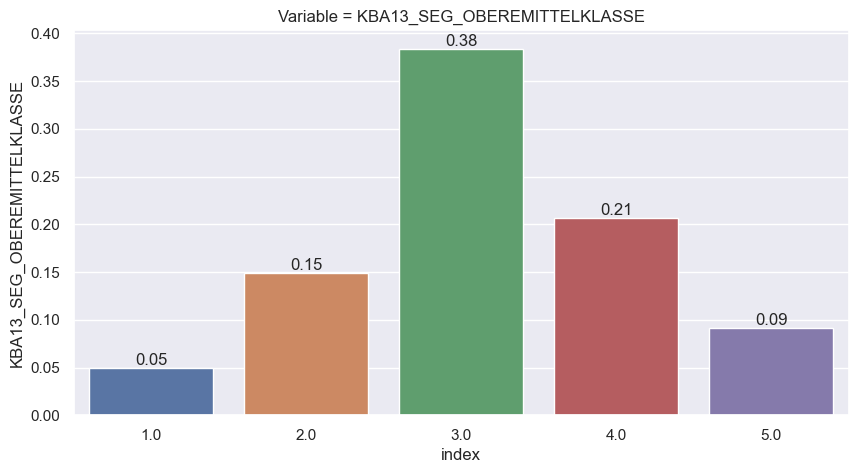

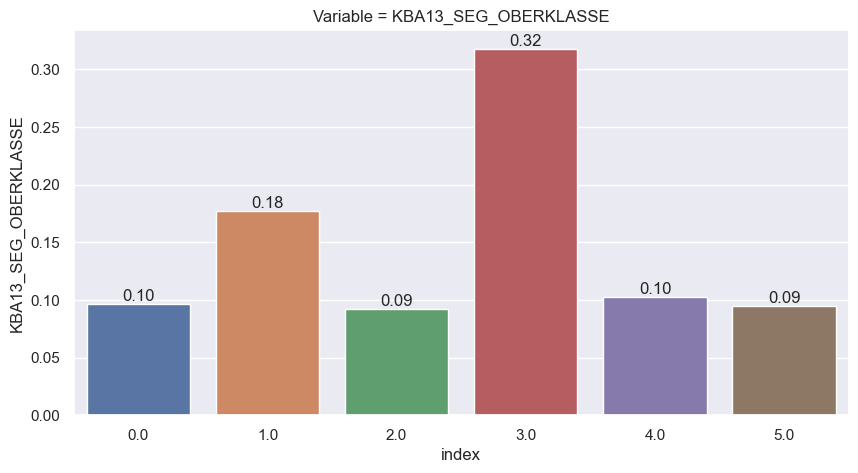

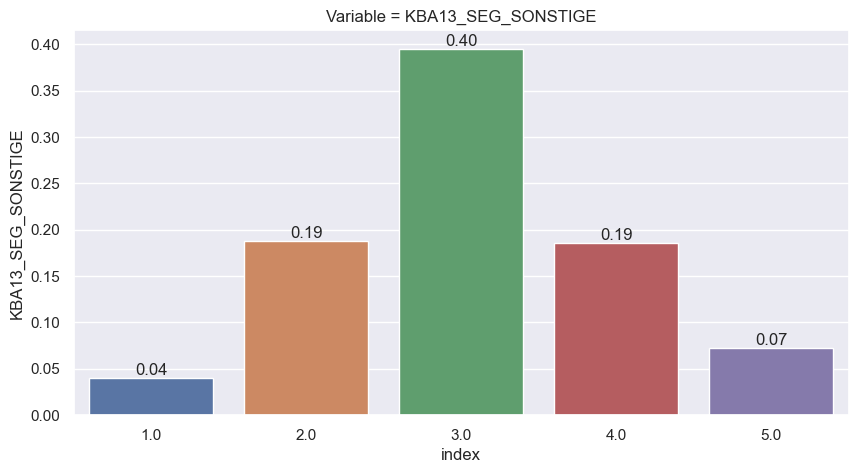

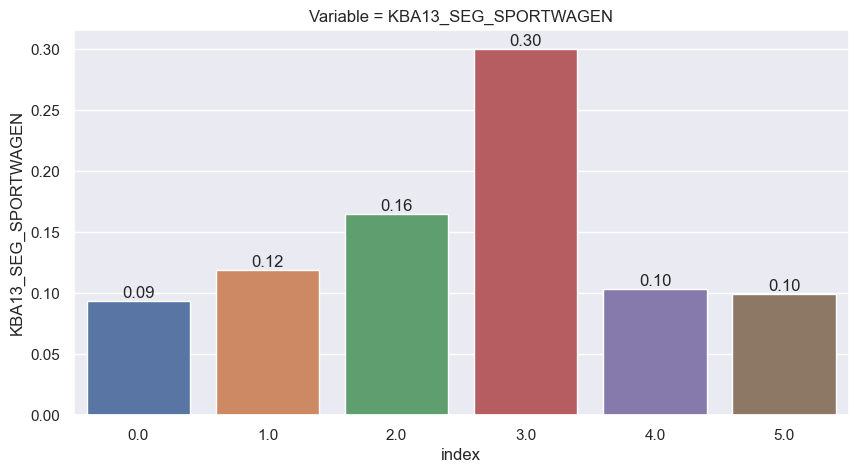

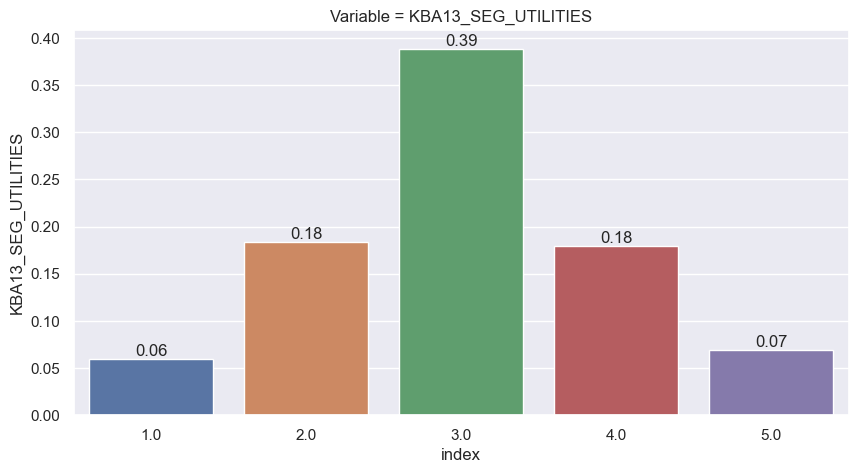

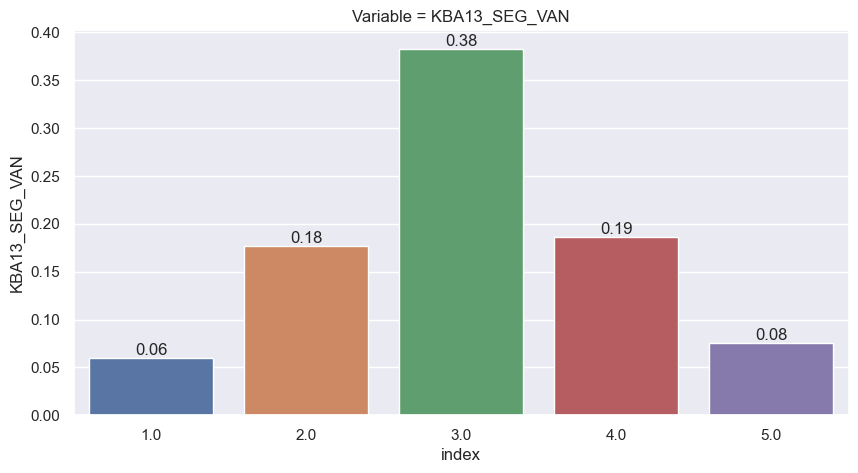

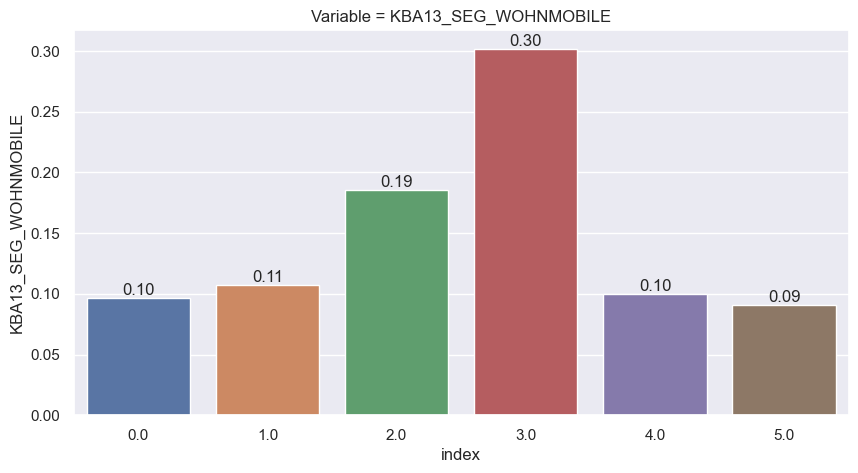

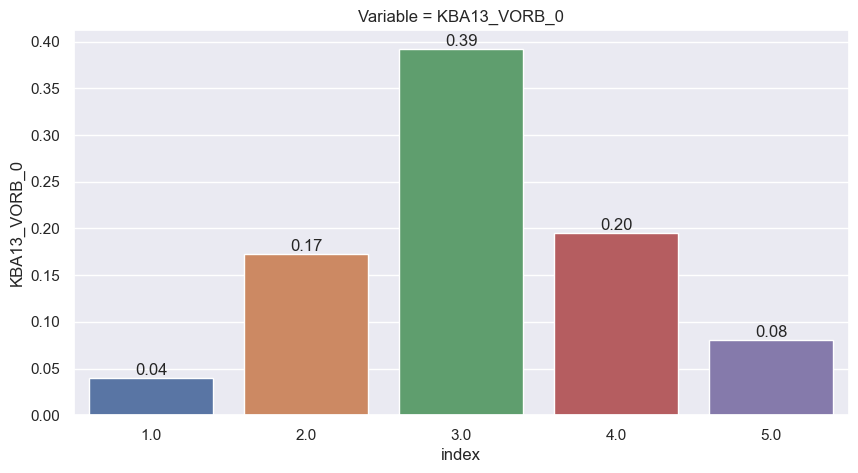

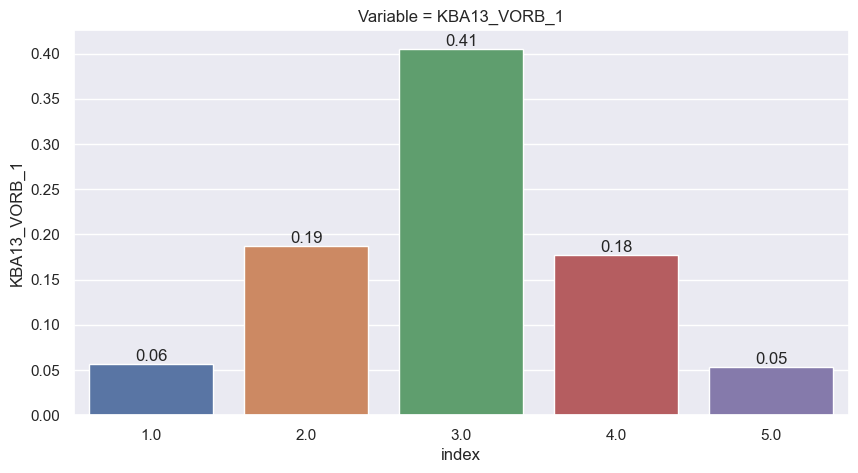

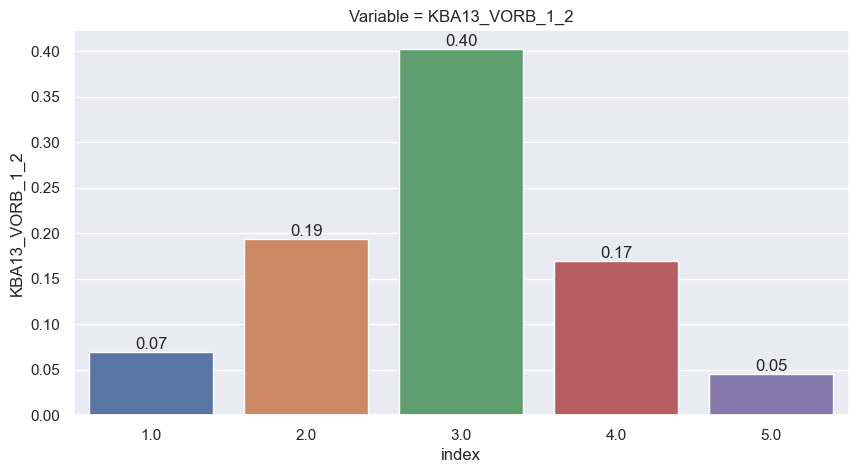

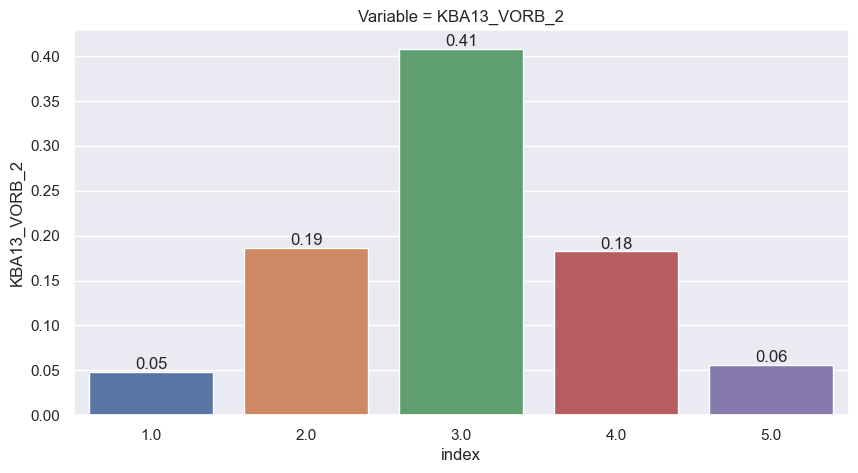

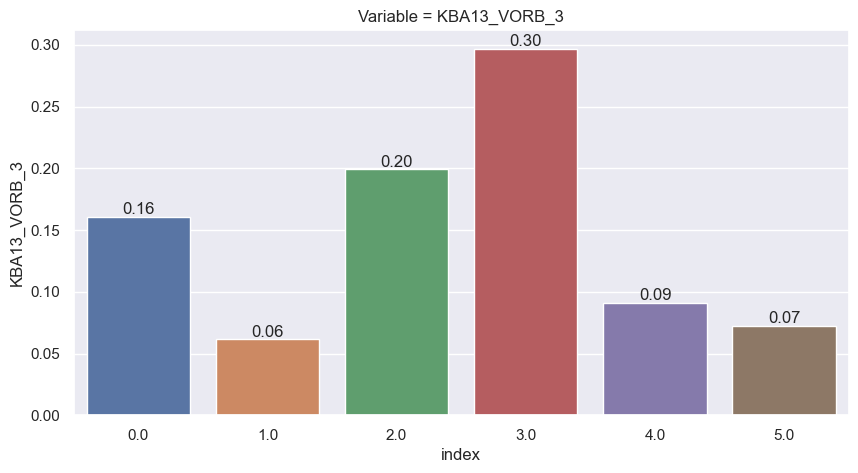

In [191]:
count_val_in_cols(census, sorted([col for col in plz8_col_list if col.startswith('KBA13')]), plot_count = True, normalize = True, dropna = False)

- All owners age-groups (Alterhalter) have similar distributions.
- There are two sets of variables for owner age and max speed of vehicles. Only one set of each variable will be kept, since they convey similar information.
    - For simplicity, sets with fewer variables will be selected

### Are owner age-group columns correlated?
If they are, they contain similar values. 

In [205]:
alterhalter_cols = [col for col in plz8_col_list if 'ALTERHALTER' in col]
halter_cols = [col for col in plz8_col_list if ('HALTER' in col) and ('ALTERHALTER' not in col)]

In [199]:
census[alterhalter_cols].head()

KBA13_ALTERHALTER_45  KBA13_ALTERHALTER_60  KBA13_ALTERHALTER_61  \
0                   NaN                   NaN                   NaN   
1                   2.0                   3.0                   4.0   
2                   2.0                   3.0                   3.0   
3                   3.0                   5.0                   2.0   
4                   3.0                   3.0                   3.0   

   KBA13_ALTERHALTER_30  
0                   NaN  
1                   3.0  
2                   3.0  
3                   2.0  
4                   3.0

In [201]:
census[alterhalter_cols].corr(method = 'spearman').style.background_gradient()

In [207]:
census[halter_cols].corr(method = 'spearman').style.background_gradient()

In [203]:
census[alterhalter_cols].isna().mean()

KBA13_ALTERHALTER_45    0.118714
KBA13_ALTERHALTER_60    0.118714
KBA13_ALTERHALTER_61    0.118714
KBA13_ALTERHALTER_30    0.118714
dtype: float64

In [208]:
census[halter_cols].isna().mean()

KBA13_HALTER_45    0.118714
KBA13_HALTER_55    0.118714
KBA13_HALTER_25    0.118714
KBA13_HALTER_50    0.118714
KBA13_HALTER_20    0.118714
KBA13_HALTER_35    0.118714
KBA13_HALTER_66    0.118714
KBA13_HALTER_30    0.118714
KBA13_HALTER_65    0.118714
KBA13_HALTER_40    0.118714
KBA13_HALTER_60    0.118714
dtype: float64

Not necessairly the columns are correlated amongst themselves. This indicates that even though they are generally equally distributed, a line in the file might not have similar categories for all classification.  
This being pointed out, since ALTERHALTER columns convey similar information to HALTER columns, but are less numerous and have a similar amount of NaN values and we already have better proxies for age-groups, the HALTER columns could be dropped.

## Postcode

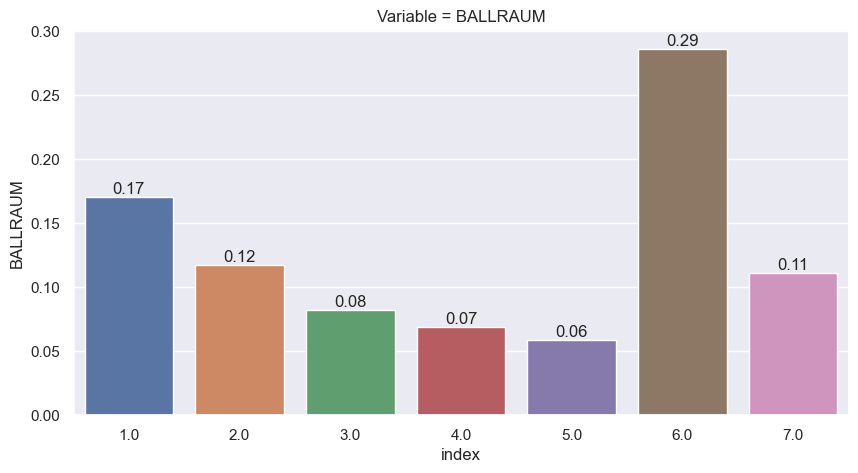

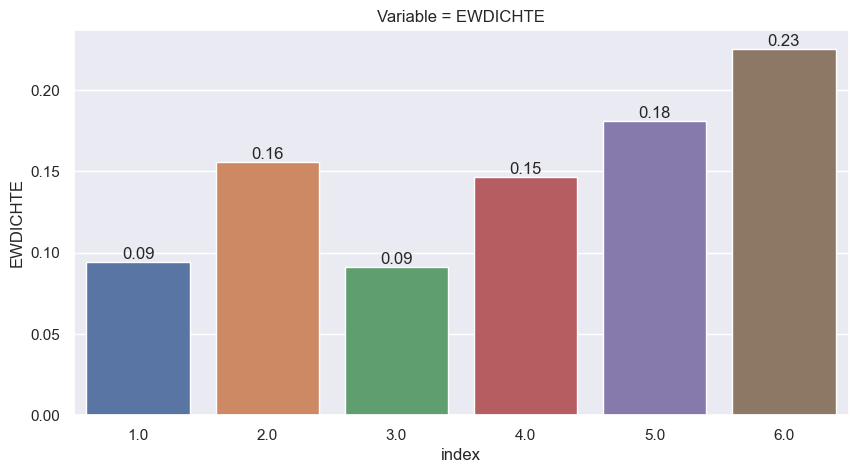

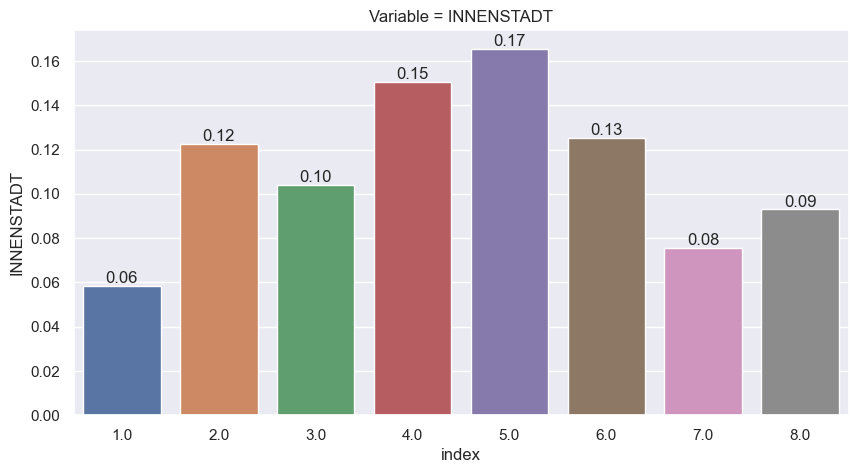

In [210]:
count_val_in_cols(census, postcode_col_list, plot_count = True, normalize = True, dropna = False)

## RR1 Cols

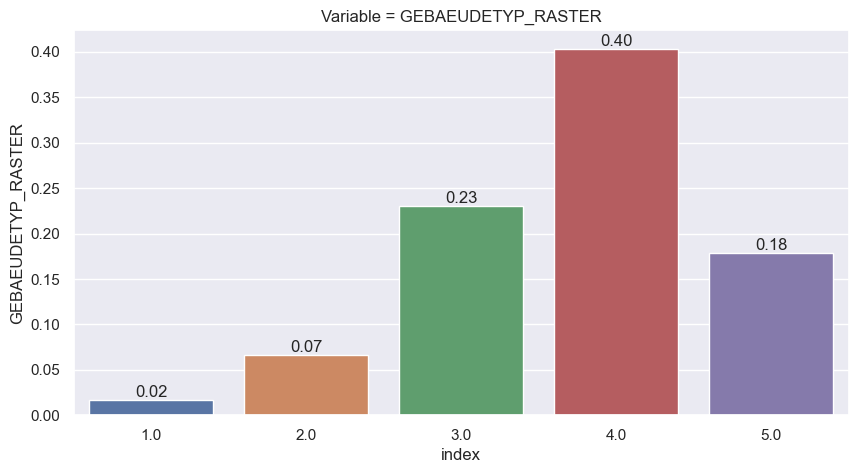

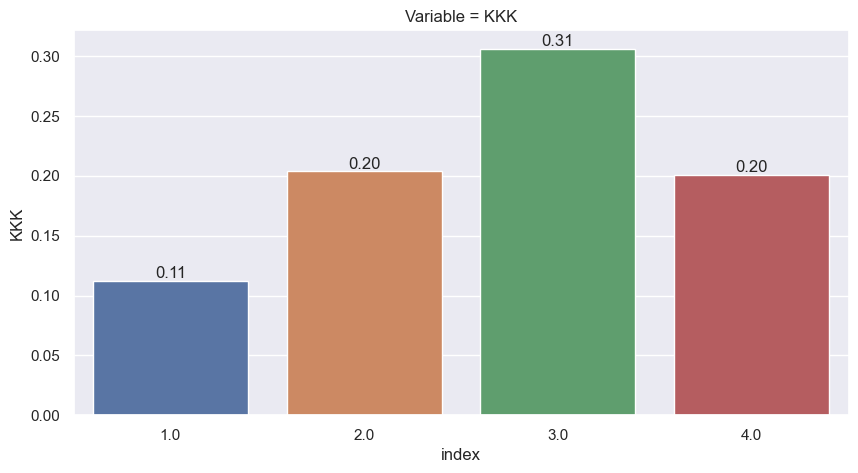

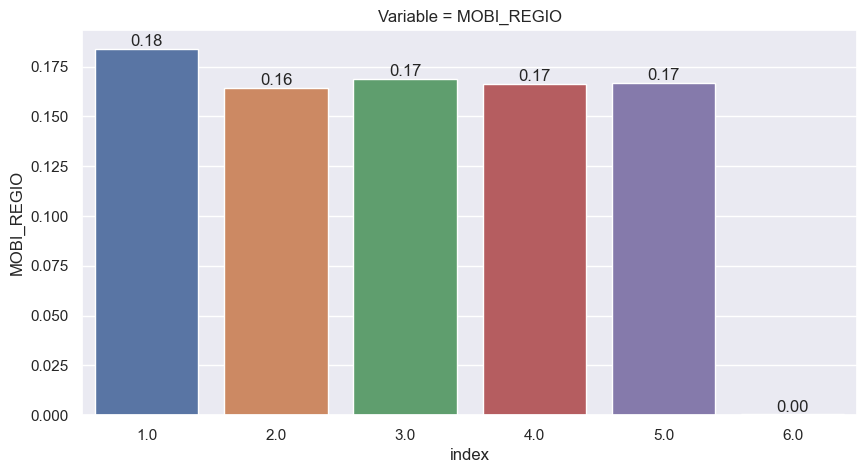

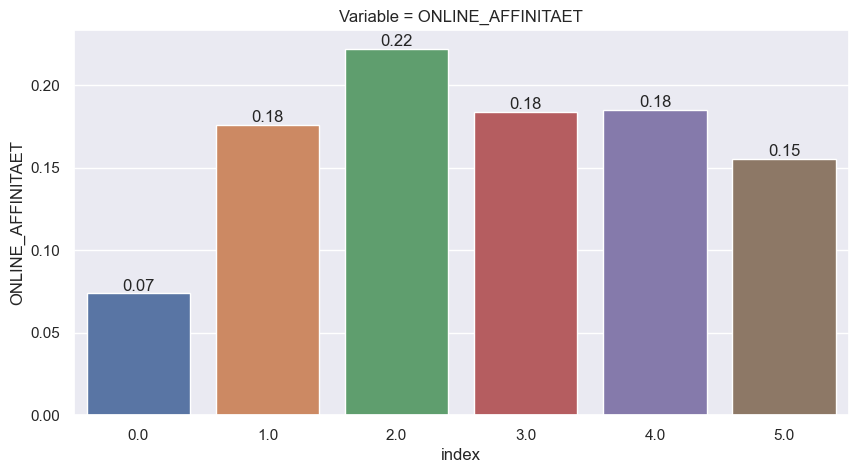

In [211]:
count_val_in_cols(census, rr1_cols, plot_count = True, normalize = True, dropna = False)

# Generating subset for preprocessing

In [123]:
print(len(selected_features), f'out of {census.shape[1]} features were selected to use in the segmentation')

196 out of 196 features were selected to use in the segmentation


In [130]:
cols_to_drop = ['GEBURTSJAHR',
                'SOHO_KZ',
                'KBA13_HALTER_20',
                'KBA13_HALTER_25',
                'KBA13_HALTER_30',
                'KBA13_HALTER_35',
                'KBA13_HALTER_40',
                'KBA13_HALTER_45',
                'KBA13_HALTER_50',
                'KBA13_HALTER_55',
                'KBA13_HALTER_60',
                'KBA13_HALTER_65',
                'KBA13_HALTER_66',
                'KBA13_CCM_1401_2500',
                'KBA13_KMH_110',
                'KBA13_KMH_140',
                'KBA13_KMH_180',
                'KBA13_KMH_210',
                'KBA13_KMH_250',
                'KBA13_KMH_251']

cols_to_drop.extend([col for col in person_col_list if 'FEIN' in col])

In [ ]:
census

In [133]:
census.drop(columns = cols_to_drop, inplace = True)

In [135]:
census.to_parquet('data/trusted/census_subset.parquet')